<a href="https://colab.research.google.com/github/ccg-esb/EvK/blob/main/py_pOXA48_SI2_parametrization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __SI:__ Differences in vertical and horizontal transmission dynamics shape plasmid distribution in clinical enterobacteria

### 2. Model parametrization

This notebook focuses on obtaining specific parameters for each bacterial strain used in our study, encompassing both plasmid-bearing and plasmid-free cells. We extract these parameters from experimental data of each strain grown in isolation. The parameters encapsulate elements of growth kinetics, drug susceptibility, and bacterial conjugation capabilities. The ultimate goal of this process is to obtain a robust set of parameters that can be used to accurately simulate the ecological dynamics of mixed co-cultures. By creating models that closely reflect the real-world dynamics of bacterial populations under various conditions, we aim to deepen our understanding of the interactions within these populations and the impacts of environmental stressors such as antibiotics.

In [28]:
import csv
import pandas as pd
from tabulate import tabulate
import numpy as np
import os
import colorcet as cc
import sys

File structure

In [29]:

# Define your paths
root='/content/drive/MyDrive/SYNC_Projects/pOXA48/2023/code/py-files/'

path='./'
figPath = path+'figures/'
envPath = path+'env/'
dataPath = path+'data/'

strains_subsetE = [1, 2, 6, 9, 11, 15, 18, 20, 21, 24]
strains_subsetK = [25, 26, 29, 34, 37, 38, 39, 41, 43, 45]

strains_subset = strains_subsetE + strains_subsetK

print("subset: ",strains_subset)

strains = ['C001', 'C002',  'C006',  'C011',  'C012',  'C021',  'C022',  'C031',  'C051',  'C063',  'C094',  'C107',  'C115',  'C131',  'C141',  'C201',  'C227',  'C232',  'C247',  'C261',  'C286',  'C290',  'C302',  'C309',  'C324',  'K037',  'K038',  'K087',  'K094',  'K112',  'K114',  'K125',  'K141',  'K168',  'K177',  'K200',  'K201',  'K209',  'K213',  'K216',  'K224',  'K225',  'K241',  'K248',  'K249',  'K253',  'K257',  'K275',  'K285',  'K300']
plasmids = ['WT','TC']

tot_strains = int(len(strains))
cmap_strains = cc.glasbey_light[:tot_strains]


subset:  [1, 2, 6, 9, 11, 15, 18, 20, 21, 24, 25, 26, 29, 34, 37, 38, 39, 41, 43, 45]


Model parameters

In [30]:

B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1 #Concentration of imiting resource
extinction_threshold=1 #Extinction threshold
alphas=[1e-10, 1e-12] #Antibiotic degradation rate

A_max=65536*2 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

expe_params = {
    'B0': B0, #Initial bacterial density
    'A_max': A_max, #Maximum drug concentration
    'alphas': np.array(alphas), #Antibiotic degradation rate
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'extinction_threshold': extinction_threshold,
}


In [31]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir(root)

sys.path.insert(0, 'src/')
from pOXA48_S1 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Growth-kinetic parameters

In a prior study, we used the Metropolis-Hastings Markov chain Monte Carlo (MCMC) method to estimate maximum likelihood estimates of growth parameters for our ecological model. This approach allowed us to characterize specific affinity ($V_{max}/K_m$) and resource conversion rate ($\rho$) for each strain, grown independently with or without plasmids. Through fitting the model to individual growth curves, we generated a parameter vector $\psi=(\rho, V_{max}/K_m)$ for each strain. We tested the model's robustness by considering different prior distributions (uniform, lognormal, beta, and gamma), which yielded consistent maximum likelihood estimates. Furthermore, by using a data cloning algorithm[ref], we confirmed the identifiability of our parameters, with the marginal posterior distribution consistently converging to the maximum likelihood estimate as the number of clones increased

In [32]:

def import_model_params(filename, expe_params):
    """
    Read model parameters from a CSV file.

    The function reads parameters from a CSV file and stores them into a pandas DataFrame. It also assigns
    experimental parameters (expe_params) as metadata to the DataFrame.

    Parameters:
    filename: string
        The name of the CSV file to read from.
    expe_params: dict
        The dictionary containing experimental parameters to be assigned as metadata to the DataFrame.

    Returns:
    df: pandas DataFrame
        The DataFrame containing model parameters.
    """

    model_params = {
         "strain_name": [], "strain_color": [], "specie": [], "strain": [], "type": [],
       "PCN": [], "MIC": [], "conj_rate": [],   "VKm": [], "rho": [], "seg_rate":[], "kappa": []}

    # Open the CSV file
    with open(filename, 'r') as csvfile:
        # Use the csv reader
        csvreader = csv.reader(csvfile)

        # Ignore the header
        headers = next(csvreader)

        # Read each row: name	color	specie	strain	type	PCN	MIC	conj_rate	VKm	rho	seg_rate	Kappa
        for row in csvreader:
            model_params["strain_name"].append(row[1])
            model_params["strain_color"].append(row[2])
            model_params["specie"].append(row[3])
            model_params["strain"].append(row[4])
            model_params["type"].append(row[5])
            model_params["PCN"].append(float(row[6]) if row[6] else np.nan)
            model_params["MIC"].append(float(row[7]) if row[7] else np.nan)
            model_params["conj_rate"].append(float(row[8]) if row[8] else np.nan)
            model_params["VKm"].append(float(row[9]) if row[9] else np.nan)
            model_params["rho"].append(float(row[10]) if row[10] else np.nan)
            model_params["seg_rate"].append(float(row[11]) if row[11] else np.nan)
            model_params["kappa"].append(float(row[12]) if row[12] else np.nan)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(model_params)

    # Assign the experimental parameters as metadata
    df.attrs = expe_params

    # Return the completed DataFrame
    return df


def export_model_params(model_params, filename):
    """
    Write model parameters to a CSV file.

    The function takes a dictionary of model parameters and exports them to a specified CSV file.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    filename: string
        The name of the CSV file to write to.
    """
    num_strains = int(len(model_params['specie']) / 2)

    # Prepare the header
    headers = ["", "name", "color", "specie", "strain", "type",
                "PCN", "MIC", "conj_rate", "VKm", "rho","seg_rate", "kappa"]

    # Prepare the rows
    rows = []
    for i in range(2 * num_strains):
        name = model_params['strain_name'][i]
        color = model_params['strain_color'][i]
        specie = model_params['specie'][i]
        strain = model_params['strain'][i]
        ptype = model_params['type'][i]
        pcn = model_params['PCN'][i]
        mic = model_params['MIC'][i]
        conj = model_params['conj_rate'][i]
        VKm = model_params['VKm'][i]
        rho = model_params['rho'][i]
        seg = model_params['seg_rate'][i]
        kappa = model_params['kappa'][i]
        row = [f"{i+1}", name, color, specie, strain, ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        rows.append(row)

    # Write to the CSV file
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(headers)
        csvwriter.writerows(rows)
    print("Data exported to %s"%filename)

model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)

In [33]:

def display_model_params(model_params):
    """
    Display model parameters in a table format.

    The function takes a dictionary of model parameters and formats it into a table using the tabulate module.
    The table is then printed to the console. The parameters are organized by strain type, first plasmid-free,
    then plasmid-bearing.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    """
    table = []
    num_strains=int(len(model_params['specie'])/2)
    for i in range(num_strains): #Plasmid-Free (TC)
        name = model_params['strain_name'][i]
        strain = model_params['strain'][i]
        specie = model_params['specie'][i]
        ptype = model_params['type'][i]
        pcn = model_params['PCN'][i]
        mic = model_params['MIC'][i]
        conj = model_params['conj_rate'][i]
        VKm = model_params['VKm'][i]
        rho = model_params['rho'][i]
        seg = model_params['seg_rate'][i]
        kappa = model_params['kappa'][i]
        row = [f"{i+1}", name, strain, specie,  ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    for i in range(num_strains): #Plasmid-bearing (WT)
        name = model_params['strain_name'][i+num_strains]
        strain = model_params['strain'][i+num_strains]
        specie = model_params['specie'][i+num_strains]
        ptype = model_params['type'][i+num_strains]
        pcn = model_params['PCN'][i+num_strains]
        mic = model_params['MIC'][i+num_strains]
        conj = model_params['conj_rate'][i+num_strains]
        VKm = model_params['VKm'][i+num_strains]
        rho = model_params['rho'][i+num_strains]
        seg = model_params['seg_rate'][i+num_strains]
        kappa = model_params['kappa'][i+num_strains]
        row = [f"{num_strains+i+1}", name, strain, specie,  ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    headers = ["", "name", "strain", "specie",  "type", "PCN", "MIC", "conj_rate", "VKm", "rho", "seg_rate",  "kappa"]
    print(tabulate(table, headers, tablefmt="fancy_grid"))

This function plots the model parameters related to bacterial growth - the resource conversion rate (rho) and specific affinity (VKm), for both plasmid-free (TC) and plasmid-bearing (WT) strains. This scatter plot provides a visual comparison of these parameters across different bacterial strains, giving insights into their growth characteristics and how they may influence the dynamics of the system.

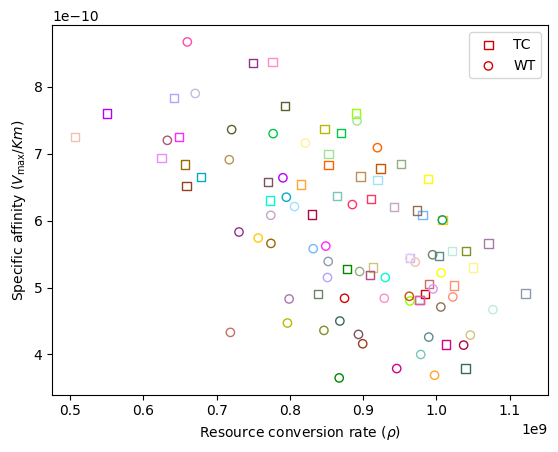

In [34]:

def plot_growthParams(model_params):
    """
    Plot the resource conversion rate (rho) against the specific affinity (VKm) for all bacterial strains.

    This function creates a scatter plot, where each point represents a bacterial strain.
    The x-coordinate of the point corresponds to the strain's resource conversion rate (rho),
    and the y-coordinate corresponds to its specific affinity (VKm).
    The points corresponding to plasmid-free (TC) and plasmid-bearing (WT) strains are marked differently to distinguish between them.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    """

    VKm_values = model_params['VKm']
    rho_values = model_params['rho']
    num_half = int(len(VKm_values)/2)

    # Create a scatter plot of VKm against rho
    plt.scatter(rho_values[:num_half], VKm_values[:num_half], marker='s', edgecolors=cmap_strains[:num_half], facecolors='none', label='TC')
    plt.scatter(rho_values[num_half:], VKm_values[num_half:], edgecolors=cmap_strains[:num_half], facecolors=cmap_strains[num_half:], label='WT')
    plt.xlabel(r'Resource conversion rate ($\rho$)')
    plt.ylabel(r'Specific affinity ($V_{\mathrm{max}}/Km$)')
    plt.legend()
    plt.show()

plot_growthParams(model_params)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'facecolor'
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'facecolor'
  cset = contour_func(


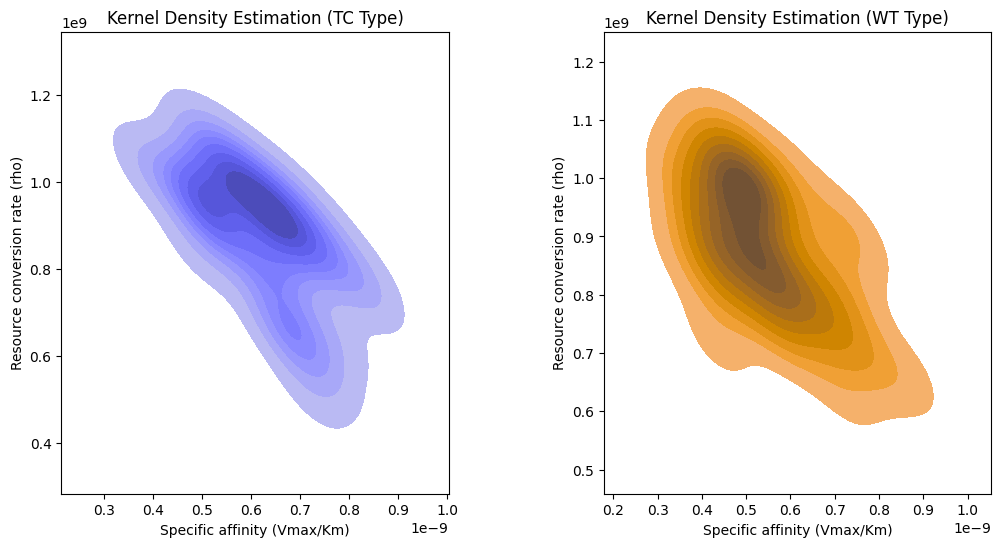

In [35]:
import seaborn as sns

from sklearn.neighbors import KernelDensity

def plot_contour(model_params, type, fill_color):
    VKm_values = model_params['VKm']
    rho_values = model_params['rho']
    type_values = model_params['type']

    # Filter data points based on the given type
    filtered_VKm = np.array(VKm_values)[np.array(type_values) == type]
    filtered_rho = np.array(rho_values)[np.array(type_values) == type]

    if len(filtered_VKm) == 0:
        print(f"No data points of type '{type}' found.")
        return

    # Create a grid of coordinates
    x_grid, y_grid = np.meshgrid(filtered_VKm, filtered_rho)

    # Combine VKm and rho values into a single array
    data = np.vstack([filtered_VKm, filtered_rho]).T

    # Fit kernel density estimation to the filtered data
    kde = KernelDensity(bandwidth=0.2)  # Adjust the bandwidth parameter as needed
    kde.fit(data)

    # Calculate density estimates for the grid points
    log_density = kde.score_samples(np.vstack([x_grid.ravel(), y_grid.ravel()]).T)
    density = np.exp(log_density)
    z_values = density.reshape(x_grid.shape)

    # KDE plot with custom fill color
    plt.subplot(1, 2, 1 if type == 'TC' else 2)
    sns.kdeplot(data=data, x=filtered_VKm, y=filtered_rho, fill=True, facecolor=fill_color)
    plt.xlabel('Specific affinity (Vmax/Km)')
    plt.ylabel('Resource conversion rate (rho)')
    plt.title(f'Kernel Density Estimation ({type} Type)')

# Create a figure to contain the subplots
fig = plt.figure(figsize=(12, 6))

# Plot KDE plots for TC and WT types side-by-side with different fill colors
plot_contour(model_params, 'TC', fill_color='blue')
plot_contour(model_params, 'WT', fill_color='orange')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()


E:
  Slope:      -550041048140254976.00
  Intercept:  1176726170.96
  R-squared:  0.30
K:
  Slope:      -754547982321422976.00
  Intercept:  1337150525.87
  R-squared:  0.45


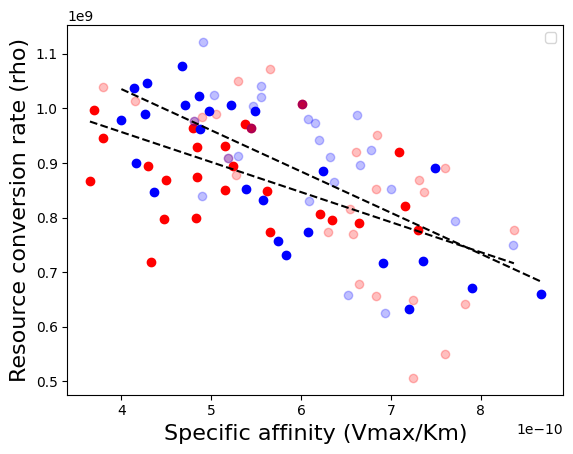

In [36]:
from matplotlib.patches import Ellipse
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

def plot_2D_combined(model_params):
    VKm_values = model_params['VKm']
    rho_values = model_params['rho']
    specie_values = model_params['specie']
    type_values = model_params['type']

    # Group data by 'specie'
    grouped_data = {}
    for VKm, rho, specie, type_ in zip(VKm_values, rho_values, specie_values, type_values):
        if specie not in grouped_data:
            grouped_data[specie] = {'VKm': [], 'rho': [], 'type': []}
        grouped_data[specie]['VKm'].append(VKm)
        grouped_data[specie]['rho'].append(rho)
        grouped_data[specie]['type'].append(type_)

    # Calculate mean and standard deviation for each group
    means = {}
    stds = {}
    for specie, data in grouped_data.items():
        VKm_values = data['VKm']
        rho_values = data['rho']
        means[specie] = np.mean(VKm_values), np.mean(rho_values)
        stds[specie] = np.std(VKm_values), np.std(rho_values)

    # Perform linear regression for each group
    regressions = {}
    for specie, data in grouped_data.items():
        VKm_values = data['VKm']
        rho_values = data['rho']
        type_values = data['type']
        X = np.array(VKm_values).reshape(-1, 1)
        y = np.array(rho_values)

        # Fit linear regression model
        reg = LinearRegression().fit(X, y)
        slope = reg.coef_[0]
        intercept = reg.intercept_
        r2 = r2_score(y, reg.predict(X))

        regressions[specie] = {
            'reg': reg,
            'slope': slope,
            'intercept': intercept,
            'r2': r2
        }

    # Compute principal components of the data
    pca = PCA(n_components=2)
    data = np.array([VKm_values, rho_values]).T
    pca.fit(data)

    # Define quantile for ellipse
    quantile = 0.99

    # Set up plot
    plt.xlabel('Specific affinity (Vmax/Km)', fontsize=16)
    plt.ylabel('Resource conversion rate (rho)', fontsize=16)

    # Plot data points for each group
    for specie, data in grouped_data.items():
        VKm_values = data['VKm']
        rho_values = data['rho']
        type_values = data['type']

        # Determine color and marker style based on 'specie' and 'type'
        if specie == 'E':
            color = 'red'
        else:
            color = 'blue'

        # Plot data points
        for VKm, rho, type_ in zip(VKm_values, rho_values, type_values):
            marker = 'o' if type_ == 'TC' else 'o'
            alpha = 0.25 if type_ == 'TC' else 1.0
            plt.scatter(VKm, rho, color=color, marker=marker, alpha=alpha)

    # Plot best-fitted line for each group
    for specie, data in grouped_data.items():
        VKm_values = data['VKm']
        rho_values = data['rho']
        reg = regressions[specie]['reg']
        line_x = np.array([min(VKm_values), max(VKm_values)]).reshape(-1, 1)
        line_y = reg.predict(line_x)
        plt.plot(line_x, line_y, '--', color='black')

    # Print statistics for each group
    for specie, data in grouped_data.items():
        slope = regressions[specie]['slope']
        intercept = regressions[specie]['intercept']
        r2 = regressions[specie]['r2']

        print(f'{specie}:')
        print(f'  Slope:      {slope:.2f}')
        print(f'  Intercept:  {intercept:.2f}')
        print(f'  R-squared:  {r2:.2f}')

    plt.legend()
    plt.show()

plot_2D_combined(model_params)


This function plots the resource uptake rate as a function of resource concentration for both plasmid-free (TC) and plasmid-bearing (WT) strains. The plot depicts the mean uptake rate for the TC and WT groups as well as individual uptake rates for strains within the specified istrains_values.

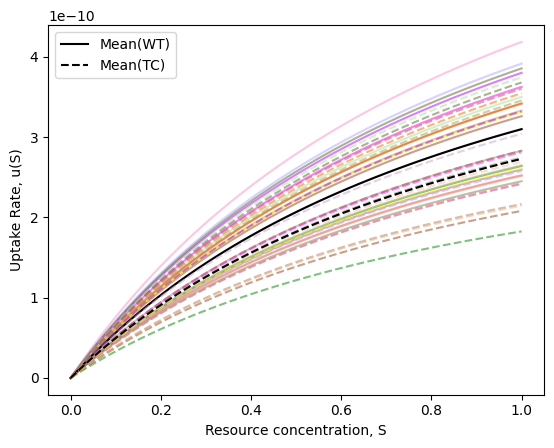

In [37]:

def plot_uptake(istrains_values, S_values, VKm_values):
    """
    Plot the resource uptake rate (u(S)) as a function of resource concentration (S) for all bacterial strains.

    This function creates a plot where each line represents a bacterial strain.
    The x-coordinate corresponds to the resource concentration (S), and the y-coordinate corresponds to the uptake rate (u(S)).
    The lines corresponding to plasmid-free (TC) and plasmid-bearing (WT) strains are marked differently to distinguish between them.
    In addition to the individual strain lines, the plot also includes the mean uptake rate lines for the TC and WT groups.

    Parameters:
    istrains_values: list
        The indices of the strains to be included in the plot.
    S_values: list
        The resource concentration values.
    VKm_values: list
        The specific affinity (VKm) values for all bacterial strains.
    """
    num_strains = int(len(VKm_values)/2)
    cmap_strains = cc.glasbey_light[:num_strains]
    WT_growth_rates=[]
    for i in range(num_strains):
        growth_rates = [uS(S, VKm_values[i]) for S in S_values]
        if i in istrains_values:
          plt.plot(S_values, growth_rates, alpha=0.5, color=cmap_strains[i]) #, label=f'{codes[i+1]}'
        WT_growth_rates.append(growth_rates)

    WT_mean_growth_rates=np.mean(WT_growth_rates, axis=0)
    plt.plot(S_values, WT_mean_growth_rates, 'k-', label='Mean(WT)')

    TC_growth_rates=[]
    for i in range(num_strains):
        growth_rates = [uS(S, VKm_values[num_strains+i]) for S in S_values]
        if i in istrains_values:
          plt.plot(S_values, growth_rates, '--', alpha=0.5, color=cmap_strains[i]) #, label=f'{codes[i+1]}'
        TC_growth_rates.append(growth_rates)

    TC_mean_growth_rates=np.mean(TC_growth_rates, axis=0)
    plt.plot(S_values, TC_mean_growth_rates, 'k--', label='Mean(TC)')

    plt.xlabel('Resource concentration, S')
    plt.ylabel('Uptake Rate, u(S)')
    plt.legend()
    plt.show()


istrains_values = strains_subset #np.arange(len(strains_subset))
S_values = np.linspace(0, 1, 100)  # Example S values from 0 to 10
VKm_values = model_params['VKm']  # List of V values for each strain
plot_uptake(istrains_values, S_values, VKm_values)

## Parametrizing Plasmid Segregation Rate
Upon bacterial cell division, plasmids need to segregate between the two daughter cells to maintain their presence in the population. However, this process isn't infallible, and sometimes a cell may divide without passing the plasmid to one of the offspring, resulting in what we call segregational loss.

The rate of segregational loss can depend on various factors. If plasmids were to segregate randomly upon division, we could model the segregational loss rate as a function of the Plasmid Copy Number (PCN) in the cell, using a formulation like seg_rate=1/2**(PCN-1).
However,, the plasmid we are examining in our model, pOXA-48, possesses an active partitioning system. This mechanism ensures a more balanced distribution of plasmids between daughter cells during division, thereby decreasing the segregational loss rate. Typically, plasmids with such a system have segregational loss rates in the range of 0.01 to 0.02.

In our model, we simplify by adopting a consistent segregational loss rate across all plasmid-host associations. Although this approximation might not capture every nuanced real-world scenario, it allows us to focus on the broader dynamics of plasmid propagation and antibiotic resistance within bacterial communities.

In [38]:
def fit_seg_rates(model_params, strains_to_update):
    seg_rates = []
    for strain in strains_to_update:
        PCN = model_params.loc[strain, 'PCN']  # Get PCN value for the current strain
        seg_rate = 1 / 2 ** (PCN - 1)  # Calculate the new seg_rate based on PCN
        seg_rates.append(seg_rate)
    return seg_rates


def assign_strain_seg_rate(model_params, seg_rates=None, strains_to_update=None):
    if strains_to_update is None:
        strains_to_update = strains  # if no specific strains are specified, update all

    num_strains = len(strains_to_update)

    j = 0
    for i, strain in enumerate(strains):
      if i in strains_to_update:
        model_params.loc[i, 'seg_rate'] = seg_rates[j]
        j += 1


In [39]:

#new_seg_rates = fit_seg_rates(model_params, strains_to_update)  # new seg_rate values for these strains

seg_rate=0.02
strains_to_update = np.arange(tot_strains)  # strains we want to update
new_seg_rates=seg_rate * np.ones(len(strains_to_update))
assign_strain_seg_rate(model_params, new_seg_rates, strains_to_update)




## Parametrizing the Rate of Horizontal Plasmid Transfer

Horizontal gene transfer (HGT) allows for the transfer of genetic material, such as the plasmids that confer antibiotic resistance, between distinct bacterial cells, and hence, between different bacterial strains. This exchange often occurs via a process known as conjugation.

An important aspect of our model is the assumption of mass action kinetics for the process of conjugation. This implies that the rate of plasmid transfer is proportional to the product of the densities of the donor and recipient populations. This is a reasonable assumption in a well-mixed environment where all individuals have an equal chance of encountering each other, and it greatly simplifies the mathematical description of the model.

In our model, we incorporate the rate of HGT, measured in conjugation events per donor cell per hour, by introducing a parameter that quantifies the propensity of a bacterial cell to accept a plasmid from another cell. This is what we refer to as permissiveness. By defining permissiveness, we acknowledge that not all bacterial cells are equally competent to receive and maintain foreign plasmids. This parameter, therefore, has the potential to significantly influence the overall dynamics of the bacterial community by modulating the spread of antibiotic resistance.

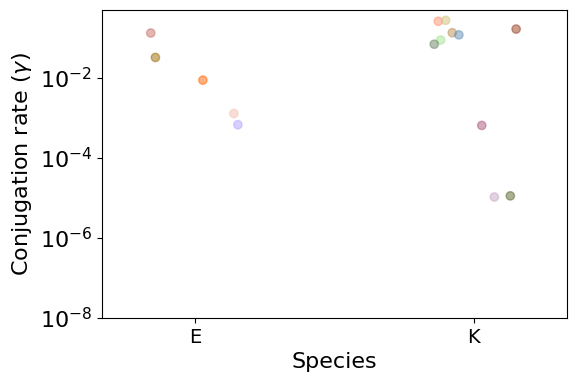

In [40]:

def plot_conj_rate_scatter(model_params):
    """
    Generate a scatter plot displaying the conjugation rates of different bacterial species.

    The scatter plot is used to visualize the distribution of conjugation rates (γ) for different species of bacteria.
    The y-axis is displayed on a logarithmic scale to account for the large range of possible conjugation rates.

    Parameters:
    model_params: dict
        The parameters of the bacterial strains, including species, type, and conjugation rates.
    """

    df = pd.DataFrame(model_params)

    fig, ax = plt.subplots(figsize=(6, 4))

    # Filter data for each combination of 'specie' and 'type' and plot scatter points
    positions = [1.2, 1.8]
    species = ['E', 'K']
    types = ['WT']

    for i, specie in enumerate(species):
        for j, type_ in enumerate(types):
            specie_type_data = df[(df['specie'] == specie) & (df['type'] == type_)]

            # Calculate the jitter for scatter points
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(specie_type_data))

            # Calculate the x-position for scatter points
            x = positions[i * len(types) + j] + jitter

            # Set the color and alpha based on 'specie' and 'type'
            color = specie_type_data['strain_color']
            alpha = 0.5 if type_ == 'WT' else 0.5

            # Get the conj_rate values and handle NaN as 0
            conj_rate = specie_type_data['conj_rate'].fillna(0)

            # Get the strain names as labels
            #labels = specie_type_data['strain_name']

            # Plot the scatter points with y-axis in log2 scale
            ax.scatter(x, conj_rate, label=f'{specie} - {type_}', color=color, alpha=alpha)


    ax.set_xticks(positions)
    ax.set_xticklabels([f'{specie}' for specie in species for type_ in types], fontsize=14)
    ax.set_xlabel('Species', fontsize=16)
    ax.set_ylabel('Conjugation rate ($\gamma$)', fontsize=16)
    ax.set_ylim([1e-8,5e-1])

    ax.set_xlim([1,2])

    ax.set_yscale('log', base=10)

    #ax.set_yticks(y_ticks)

    #
    #ax.yaxis.set_major_formatter(FixedFormatter([f'2^{i}' for i in range(17)]))

    ax.tick_params(axis='y', labelsize=16)


    #ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02), title='Strain')

    # Show the plot
    plt.show()

plot_conj_rate_scatter(model_params)



---



In [41]:
def get_selected_strains_params(model_params, istrains):
    num_strains = int(len(model_params['specie']) / 2)

    indices_tc = model_params.loc[(model_params.index.isin(istrains)) & (model_params['type'] == 'TC')].index
    indices_wt = indices_tc + num_strains

    output = pd.DataFrame()

    for key in model_params.columns:
        if key == 'type':
            output[key] = ['TC'] * len(indices_tc) + ['WT'] * len(indices_wt)
        else:
            output[key] = model_params.loc[indices_tc, key].tolist() + model_params.loc[indices_wt, key].tolist()

    output.attrs = model_params.attrs
    return output


  strain_name strain_color specie strain type    PCN      MIC  conj_rate  \
0    PF_KPN13      #916e56      K   K241   TC  2.144  28672.0        NaN   
1    PF_KPN13      #916e56      K   K241   WT    NaN    128.0        NaN   

            VKm           rho  seg_rate     kappa  
0  6.150000e-10  9.735538e+08      0.02  0.250000  
1  4.710000e-10  1.006027e+09       NaN  0.000977  


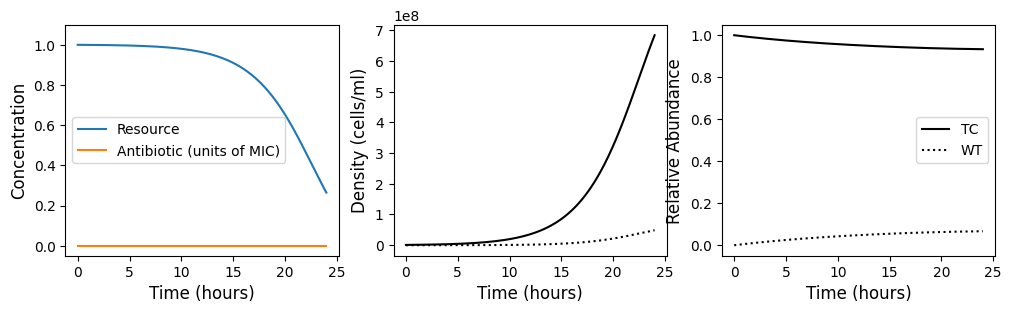

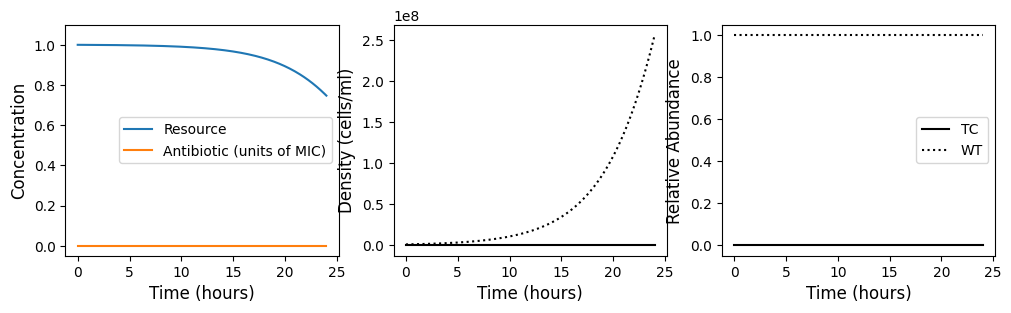

In [42]:

cmap_strains = cc.glasbey_light[:tot_strains]

# Set initial conditions
A = 0. #65536. #Environmental drug concentration

#y0 = #np.concatenate(([S0],[Amax], B0 * np.ones(2 * len(istrains_values)) / (len(istrains_values) * 2)))

y0_TC = np.concatenate(([S0], [A], [B0, 0]))
y0_WT = np.concatenate(([S0], [A], [0, B0]))

# Prepare parameters for the new function
istrains_values = [42] #np.arange(len(strains_subset)) #6
#this_params =get_selected_strains_params(istrains_values, model_params)
this_params=get_selected_strains_params(model_params, istrains_values)
print(this_params)

# Run the simulation using the new function (drug free)
times_TC, ys_TC = simulate_model(this_params, y0_TC)
times_WT, ys_WT = simulate_model(this_params, y0_WT)

plot_simulation(times_TC, ys_TC)
plot_simulation(times_WT, ys_WT)

In [43]:
# This function plots the state variables of a simulation over time.
# It takes the time points (t) and state variables (ys) as input.
# The function plots the plasmid-bearing subpopulation, plasmid-free subpopulation,
# and total bacterial density as a function of time.
def plot_state(t, ys, color='black', show_legend=False, ax=None):
    if ax is None:
      fig, ax = plt.subplots()



    S = ys[0]
    B_TC = ys[2]
    B_WT = ys[3]
    B_sum = B_TC + B_WT

    # Plot plasmid-bearing subpopulation (solid line)
    ax.plot(t, B_TC.flatten(), '-', label='Plasmid-bearing', color=color)

    # Plot plasmid-free subpopulation (dotted line)
    ax.plot(t, B_WT.flatten(), ':', label='Plasmid-free', color=color)

    # Plot total bacterial density (black line)
    ax.plot(t, B_sum.flatten(), color='black', linewidth=2, label='Total')

    ax.set_xlabel('Time (hours)', fontsize=12)
    ax.set_ylabel('Density (cells/mL)', fontsize=12)
    if show_legend:
      ax.legend()

# Numerical simulations: Drug-response experiment

In [44]:
def plot_DR_simulations(results, istrains, Amax_values):
    # Create subplots
    fig, axs = plt.subplots(1, len(results), figsize=(12, 2), sharey=True)

    for i, result in enumerate(results):
        # Unpack the simulation results
        times, ys, _, _, _, _ = result

        color=cmap_strains[istrains[0]]

        # Plot the simulation
        plot_state(times, ys, color=color, show_legend=False, ax=axs[i])
        axs[i].set_ylabel('')

        #axs[i].set_yscale('log')

        axs[i].set_xticks([0, 24])
        if i==0:
          axs[i].set_title(f'A={int(Amax_values[i])}', fontsize=12)
        else:
          axs[i].set_title(f'{int(Amax_values[i])}', fontsize=12)
          axs[i].set_xlabel('')


    # Set the common y-axis label
    fig.text(0.04, 0.5, 'Density (cells/mL)', va='center', rotation='vertical', fontsize=12)

    plt.show()

def plot_DR_BT(results, istrains, Amax_values, MIC=None, expe_MIC=None):

    extinction_threshold = model_params.attrs['extinction_threshold']

    if MIC is None:
      MIC = calculate_MIC(results, Amax_values)

    # Unpack final densities from results
    final_densities_pb = [result[3] for result in results]
    final_densities_pf = [result[4] for result in results]
    final_densities_total = [result[5] for result in results]

    # Plot Amax vs Density for plasmid-bearing subpopulation (colored solid line)
    plt.plot(Amax_values, final_densities_pb, color=cmap_strains[istrains[0]], linestyle='-',  label=r'$B_p$')

    # Plot Amax vs Density for plasmid-free subpopulation (colored dotted line)
    plt.plot(Amax_values, final_densities_pf, color=cmap_strains[istrains[0]], linestyle=':',  label=r'$B_\emptyset$')

    # Plot Amax vs Density for total bacterial population (solid black line)
    plt.plot(Amax_values, final_densities_total, color='black', marker='*', linestyle='-', label='$B_\emptyset$ + $B_p$')

    if expe_MIC is not None:
      plt.axvline(x=expe_MIC, color='blue', linestyle=':')

    # Plot horizontal line at the extinction_threshold
    plt.axhline(y=extinction_threshold, color='gray', linestyle=':')

    # Plot a red dot at (MIC, extinction_threshold)
    if MIC is not None:
      plt.plot(MIC, extinction_threshold, 'ro')

    # Set labels and title
    plt.xlabel('Drug concentration', fontsize=16)
    plt.ylabel('Density at T=24 (cells/mL)', fontsize=16)

    # Set the x-axis to logarithmic scale, base 2
    plt.xscale('log', base=2)
    plt.xlim([2**0, 2**30])
    plt.yscale('log')
    plt.ylim([10**-2, 10**9])


    plt.legend()

    # Show the plot
    plt.show()




In [45]:

def calculate_MIC(results, Amax_values):

    extinction_threshold = model_params.attrs['extinction_threshold']

    prev_final_total_density = None
    prev_Amax = None

    # Loop over the results for each antibiotic concentration
    for Amax, res in zip(Amax_values, results):
        # Extract the final total bacterial density
        final_total_density = res[-1].sum()

        # If the final total bacterial density is below the threshold, interpolate MIC
        if final_total_density < extinction_threshold:
            if prev_final_total_density is not None:
                # Linear interpolation formula in log space:
                # MIC = prev_Amax + (Amax - prev_Amax) * ((np.log(extinction_threshold) - np.log(prev_final_total_density)) / (np.log(final_total_density) - np.log(prev_final_total_density)))
                return prev_Amax + (Amax - prev_Amax) * ((np.log(extinction_threshold) - np.log(prev_final_total_density)) / (np.log(final_total_density) - np.log(prev_final_total_density)))
            else:
                return Amax

        prev_final_total_density = final_total_density
        prev_Amax = Amax

    # If no MIC was found (i.e., the bacteria survived all tested concentrations), return None
    return None

<ipython-input-46-b5ff42233fe7>:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0,60000])


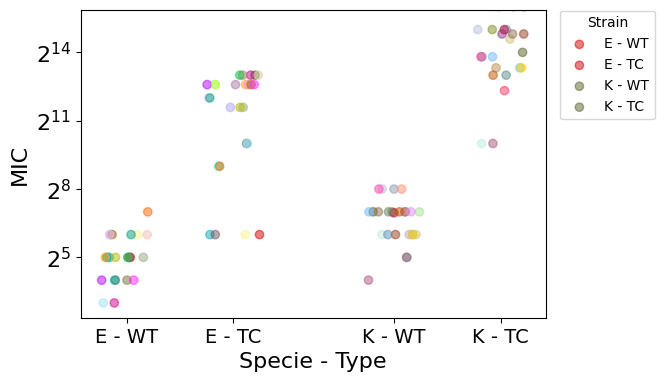

In [46]:
from matplotlib.ticker import ScalarFormatter, LogLocator

def plot_expe_MIC_scatter(model_params):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(model_params)

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define the positions for scatter points
    positions = [0.8, 1.2, 1.8, 2.2]

    # Filter data for each combination of 'specie' and 'type' and plot scatter points
    species = ['E', 'K']
    types = ['WT', 'TC']

    for i, specie in enumerate(species):
        for j, type_ in enumerate(types):
            specie_type_data = df[(df['specie'] == specie) & (df['type'] == type_)]

            # Calculate the jitter for scatter points
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(specie_type_data))

            # Calculate the x-position for scatter points
            x = positions[i * len(types) + j] + jitter

            # Set the color and alpha based on 'specie' and 'type'
            color = specie_type_data['strain_color']
            alpha = 0.5 if type_ == 'WT' else 0.5

            # Plot the scatter points with y-axis in log2 scale
            ax.scatter(x, specie_type_data['MIC'], label=f'{specie} - {type_}', color=color, alpha=alpha)

    ax.set_xticks(positions)
    ax.set_xticklabels([f'{specie} - {type_}' for specie in species for type_ in types], fontsize=14)
    ax.set_xlabel('Specie - Type', fontsize=16)
    ax.set_ylabel('MIC', fontsize=16)

    # Set the y-axis to log2 scale
    ax.set_yscale('log', base=2)
    ax.set_ylim([0,60000])
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.set_major_locator(LogLocator(base=2))
    ax.yaxis.set_minor_locator(LogLocator(base=2, subs=np.arange(0.1, 1.0, 0.1), numticks=10))

    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02), title='Strain')

    # Show the plot
    plt.show()

# Example usage
plot_expe_MIC_scatter(model_params)


In [47]:

from scipy.optimize import minimize

def fit_DR1(Amax_values, istrains, kappas, strain_type='WT', toPlot=False):

    # Set type index based on strain_type
    itype = 1 if strain_type == 'WT' else 0

    def calculate_diff(kappa):
        # Set initial conditions
        iniB = np.zeros(2)
        iniB[itype] = model_params.attrs['B0']
        y0 = np.concatenate(([S0], [0], iniB))

        expe_MIC = model_params['MIC'][this_istrain + itype*tot_strains]

        sf = np.ones(2)
        sf[itype]=kappa
        if itype==0: #TC
          sf[1]=kappas[1]

        # Run the simulations and store the results
        Amax_results, results = simulate_DR(model_params, y0, [this_istrain], Amax_values, sf)
        model_MIC = calculate_MIC(results, Amax_results)

        return abs(model_MIC - expe_MIC)

    # initial guess for kappa
    kappa_init = 1./25000.

    # Use scipy's minimize function to find the best kappa
    result = minimize(calculate_diff, kappa_init, bounds=[(0, np.inf)])

    best_kappa = result.x
    print(">> Best kappa=%s"%best_kappa)


    # Rerun the model with the best kappa to get the output
    sf = np.ones(2)
    sf[itype]=best_kappa
    if itype==0: #TC
      sf[1]=kappas[1]

    # Set initial conditions
    iniB = np.zeros(2)
    iniB[itype] = model_params.attrs['B0']
    y0 = np.concatenate(([S0], [0], iniB))

    best_Amax_results, best_results = simulate_DR(model_params, y0, [this_istrain], Amax_values, sf)
    best_MIC = calculate_MIC(best_results, best_Amax_results)
    expe_MIC = model_params['MIC'][this_istrain + itype*tot_strains]
    final_totals=0 #tmp

    if toPlot:
      plot_DR_simulations(best_results, [this_istrain], best_Amax_results)
      plot_DR_BT(best_results, [this_istrain], best_Amax_results, best_MIC, expe_MIC)

    return Amax_values, final_totals, best_kappa

In [48]:
def simulate_DR(model_params, y0, Amax_values, kappa=None):

    extinction_threshold = model_params.attrs['extinction_threshold']

    results = []
    Amax_results = []

    # Loop over the different Amax values
    for Amax in Amax_values:
        y0[1] = Amax  # initial antibiotic concentration

        # Run the simulation
        if kappa is not None:
            model_params.iloc[0, model_params.columns.get_loc('kappa')] = kappa[0]
            model_params.iloc[1, model_params.columns.get_loc('kappa')] = kappa[1]

            #model_params.loc[i+tot_strains, 'kappa'] = kappa[1]
            #model_params.loc[i, 'kappa'] = kappa[0]

        times, ys = simulate_model(model_params, y0)

        B_TC = ys[2]
        B_WT = ys[3]
        B_total = B_TC + B_WT

        #if Amax == Amax_values[-1]:
        #    print("\t", Amax, ">", B_total[-1])

        final_densities_pb = B_TC[-1]
        final_densities_pf = B_WT[-1]
        final_densities_total = B_total[-1]

        # Add results to list
        results.append((times, ys, model_params, final_densities_pb, final_densities_pf, final_densities_total))
        Amax_results.append(Amax)

        if final_densities_total<extinction_threshold/10:
          break

    return Amax_results, results


In [49]:
def fit_DR(strain_params, Amax_values, this_strain, kappas, strain_type='WT', toPlot=False):
    # Set type index based on strain_type
    itype = 1 if strain_type == 'WT' else 0
    kappa_values_TC = kappas[:,0]
    kappa_values_WT = kappas[:,1]

    expe_MIC = None
    best_MIC = np.inf
    best_kappa = np.inf
    best_results = []
    best_Amax = []
    final_totals = []  # list to store final_densities_total for each Amax

    for this_kappa in zip(kappa_values_TC, kappa_values_WT):
        # Set initial conditions
        iniB = np.zeros(2)
        iniB[itype] = strain_params.attrs['B0']
        y0 = np.concatenate(([S0], [0], iniB))

        expe_MIC = strain_params['MIC'][itype]


        # Run the simulations and store the results
        Amax_results, results = simulate_DR(strain_params, y0, Amax_values, this_kappa)
        model_MIC = calculate_MIC(results, Amax_results)

        # Update best MIC and kappa factor if current model MIC is closer to experimental MIC
        if model_MIC is None:
            best_MIC = None
            print("\t***expe_MIC = %s\tmodel_MIC = %s\tkappa = %s ___" % (expe_MIC, model_MIC, this_kappa))
        else:
            if abs(model_MIC - expe_MIC) <= abs(best_MIC - expe_MIC):
                best_MIC = model_MIC
                best_kappa = this_kappa[itype]
                best_results = results
                best_Amax = Amax_results
                print("\t*expe_MIC = %s\tmodel_MIC = %s\tkappa = %s -> %s*" % (expe_MIC, model_MIC, this_kappa, best_kappa))
            else:
                print("\t**expe_MIC = %s\tmodel_MIC = %s\tkappa = %s" % (expe_MIC, model_MIC, this_kappa))
                break

        this_totals = []
        for ir, r in enumerate(results):
            this_totals.append(r[5])

        final_totals.append(this_totals)

    # Plot the final densities as a function of Amax
    if toPlot:
        plot_DR_simulations(best_results, [this_strain], best_Amax)
        plot_DR_BT(best_results, [this_strain], best_Amax, best_MIC, expe_MIC)

    return Amax_values, final_totals, best_kappa


In [50]:




def fit_kappa(kappas, this_istrain, toPlot=False):
  #First WT then TC. This way TC also considers the parameters of the WT segregants
  types=['WT','TC']
  best_kappas=[]

  for i, this_type in enumerate(types):

    if i==0: #WT
      kappa_values = np.column_stack((np.ones_like(kappas), kappas))
    else: #TC (Adjust parameters of WT segregants)
      kappa_values = np.column_stack((kappas, best_kappa*np.ones_like(kappas)))

    expe_MIC = model_params['MIC'][this_istrain]
    this_name = model_params['strain_name'][this_istrain]
    #print("\n%s: %s [%s]"%(this_istrain, this_name, this_type))


    powers = np.arange(-1,30.0)  # array of powers of two exponents
    this_Amax=np.power(2, powers)  # calculate 2 raised to each exponent

    this_params=get_selected_strains_params(model_params, [this_istrain])
    Amax_values, final_totals, best_kappa = fit_DR(this_params, this_Amax, this_istrain, kappa_values, this_type, toPlot=toPlot)

    print("* best_kappa=%s"%best_kappa)
    best_kappas.append(best_kappa)


  return best_kappas

def assign_strain_kappa(model_params, kappa=None, strains_to_update=None):
    if strains_to_update is None:
        strains_to_update = strains  # if no specific strains are specified, update all

    num_strains=len(strains_to_update)

    j=0
    for i, strain in enumerate(strains):
      if i in strains_to_update:
        model_params.loc[i+tot_strains, 'kappa'] = kappa[j]
        model_params.loc[i, 'kappa'] = kappa[j+num_strains]

        j+=1




## Parametrization of Drug Resistance Parameter

A critical parameters in our model is the drug susceptibility parameter, denoted as $\kappa$. This parameter is a measure of a strain's inherent resistance to a given antibiotic, with higher values indicating increased resistance. In our model, drug susceptibility of each strain plays a crucial role in determining how antibiotic concentration impacts the growth and survival of bacterial populations. It also influences the dynamics of plasmid transfer as it can determine the selective advantage conferred by the plasmid in environments with varying antibiotic concentrations.

Experimentally, we can expose the population to increasing antibiotic concentrations to identify the lowest concentration of the antibiotic at which bacterial growth is effectively inhibited, a quantity referred to as the Minimum Inhibitory Concentration (MIC).
In our model, the parameter $\kappa$ is inferred by fitting in silico dose-response experiments to the MIC values obtained experimentally. By plotting the growth rate as a function of the drug concentration, we can generate a theoretical dose-response curve associated with each value of $\kappa$. We the perform a grid algorithm to identify $\kappa^*$, the parameter that best describes the experimental dose-response experiment.

Strain 0:
	*expe_MIC = 32.0	model_MIC = 50.38437358142136	kappa = (1.0, 0.00048828125) -> 0.00048828125*
	*expe_MIC = 32.0	model_MIC = 25.19219183696355	kappa = (1.0, 0.000244140625) -> 0.000244140625*


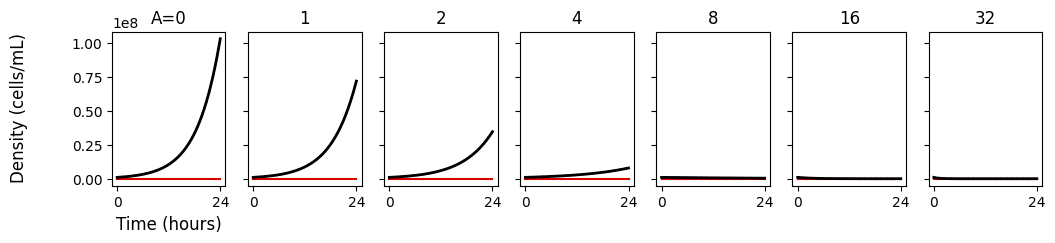

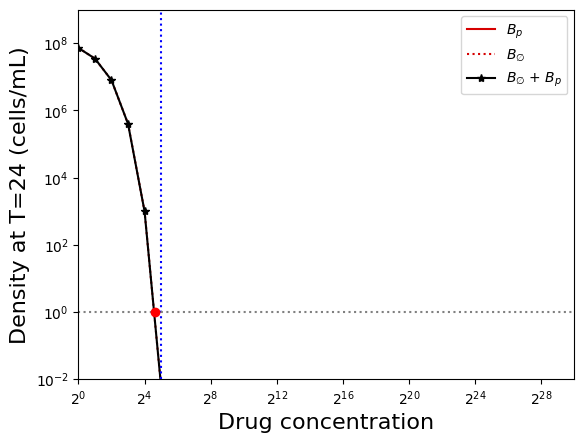

* best_kappa=0.000244140625
	*expe_MIC = 64.0	model_MIC = 52.29877224849154	kappa = (0.00048828125, 0.000244140625) -> 0.00048828125*
	**expe_MIC = 64.0	model_MIC = 26.247230699756486	kappa = (0.000244140625, 0.000244140625)


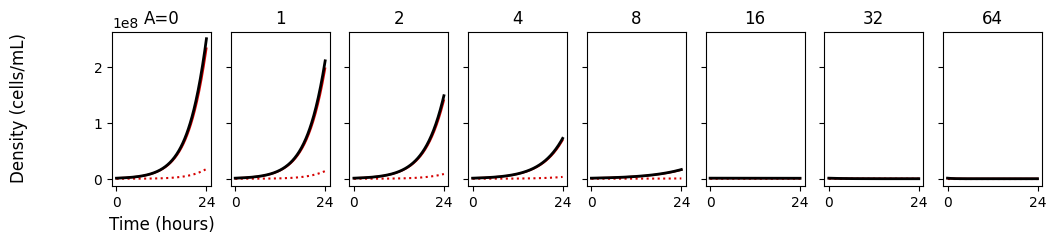

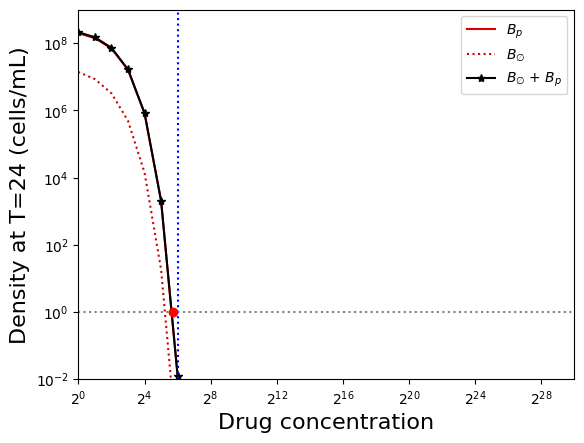

* best_kappa=0.00048828125
Strain 1:
	*expe_MIC = 32.0	model_MIC = 6012.1697507442595	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 32.0	model_MIC = 23.485040776338277	kappa = (1.0, 0.000244140625) -> 0.000244140625*


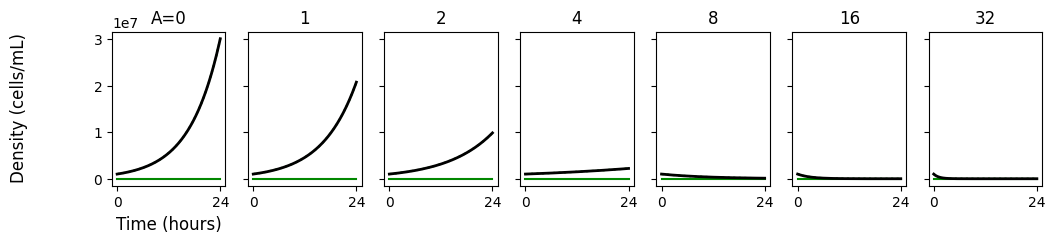

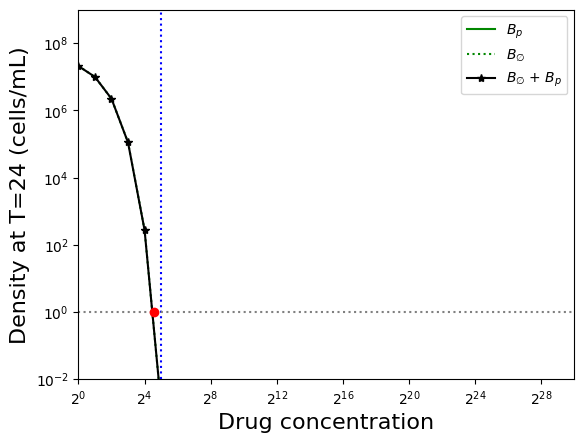

* best_kappa=0.000244140625
	*expe_MIC = 8192.0	model_MIC = 6614.222965672612	kappa = (0.0625, 0.000244140625) -> 0.0625*
	**expe_MIC = 8192.0	model_MIC = 25.904723780278673	kappa = (0.000244140625, 0.000244140625)


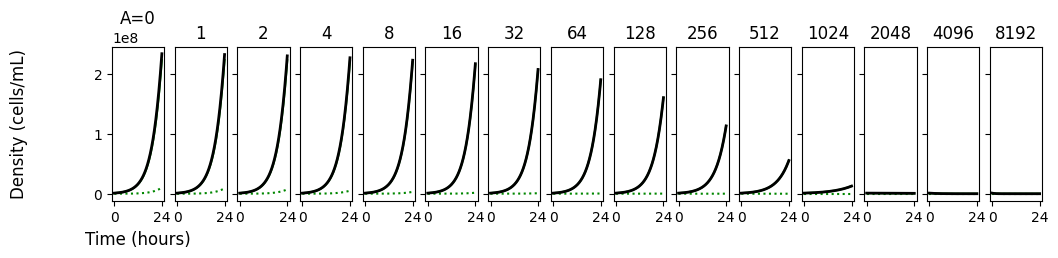

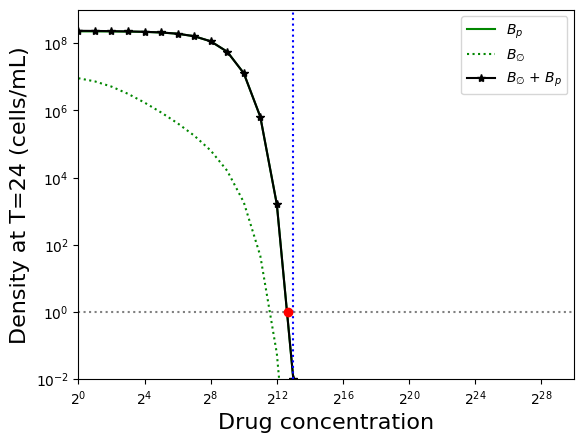

* best_kappa=0.0625
Strain 2:
	*expe_MIC = 16.0	model_MIC = 6865.0151707206205	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 16.0	model_MIC = 13.408233041080575	kappa = (1.0, 0.0001220703125) -> 0.0001220703125*


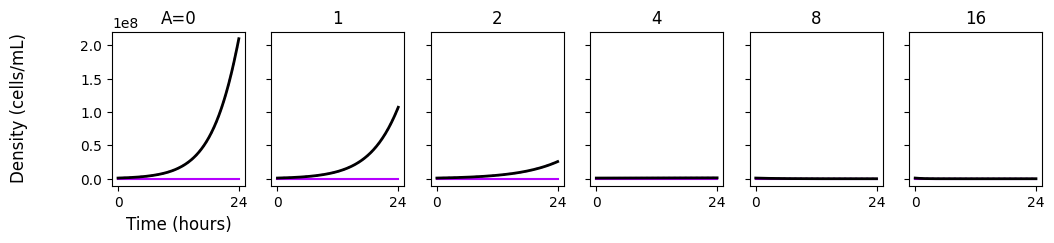

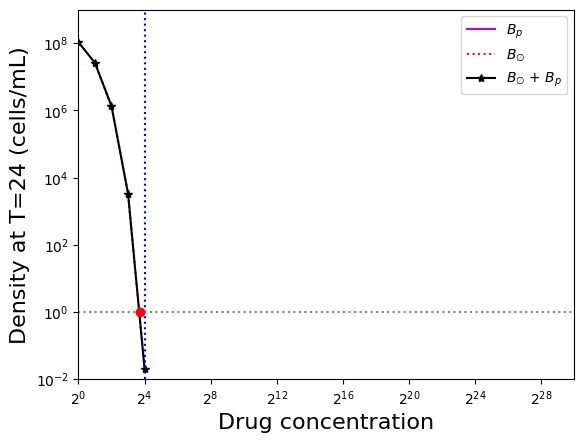

* best_kappa=0.0001220703125
	*expe_MIC = 6144.0	model_MIC = 6429.464561351085	kappa = (0.0625, 0.0001220703125) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 12.681017899782663	kappa = (0.0001220703125, 0.0001220703125)


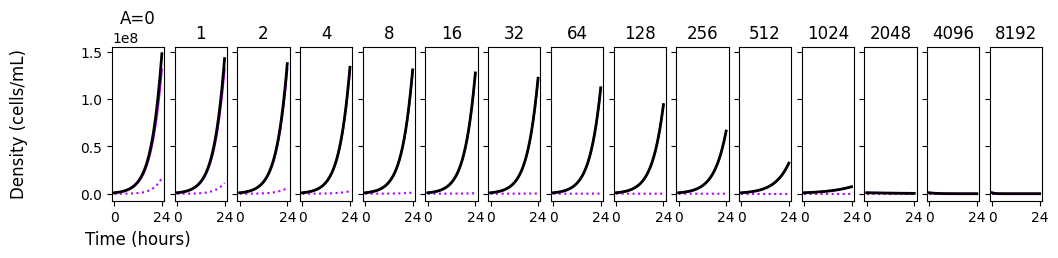

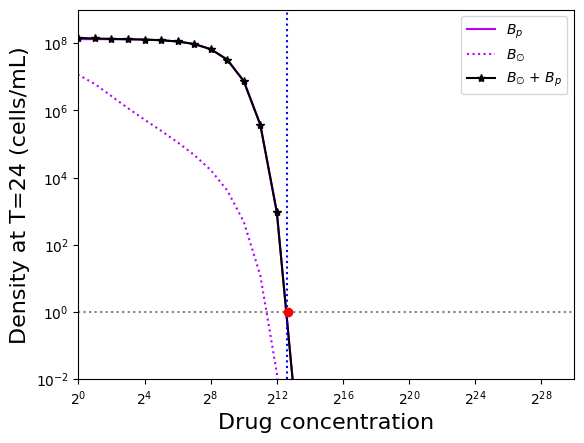

* best_kappa=0.0625
Strain 3:
	*expe_MIC = 32.0	model_MIC = 52.994496969724985	kappa = (1.0, 0.00048828125) -> 0.00048828125*
	*expe_MIC = 32.0	model_MIC = 26.497248484349416	kappa = (1.0, 0.000244140625) -> 0.000244140625*


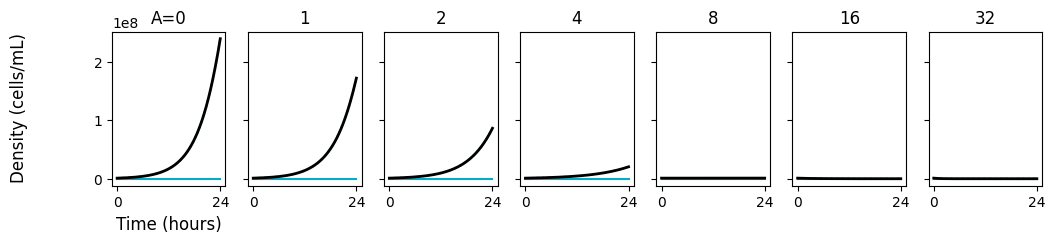

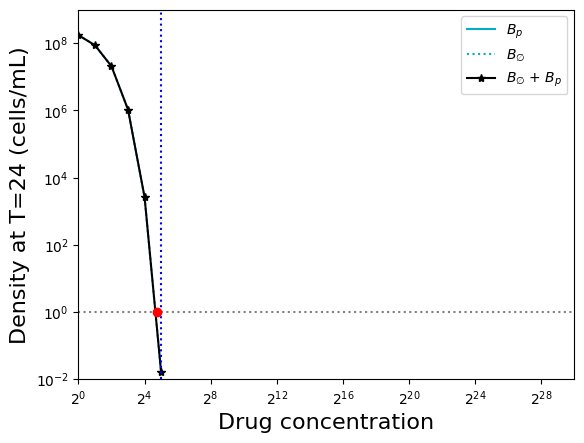

* best_kappa=0.000244140625
	*expe_MIC = 64.0	model_MIC = 51.30355916866083	kappa = (0.00048828125, 0.000244140625) -> 0.00048828125*
	**expe_MIC = 64.0	model_MIC = 25.83168049280946	kappa = (0.000244140625, 0.000244140625)


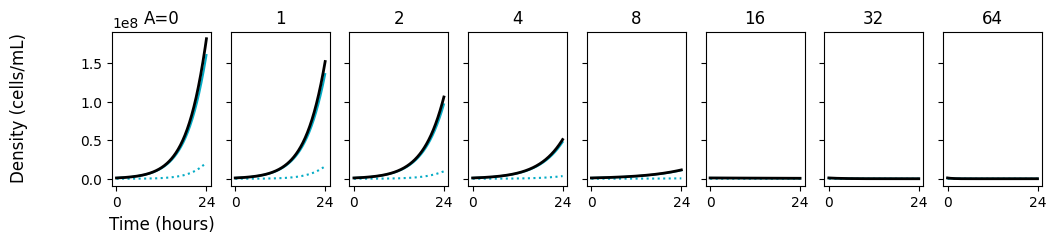

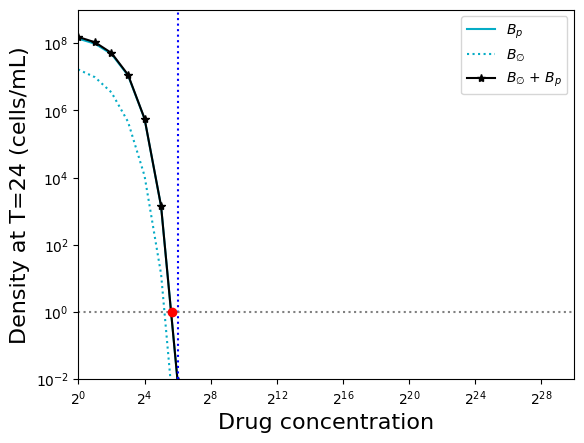

* best_kappa=0.00048828125
Strain 4:
	*expe_MIC = 16.0	model_MIC = 6610.397869395997	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 16.0	model_MIC = 12.910932032419538	kappa = (1.0, 0.0001220703125) -> 0.0001220703125*


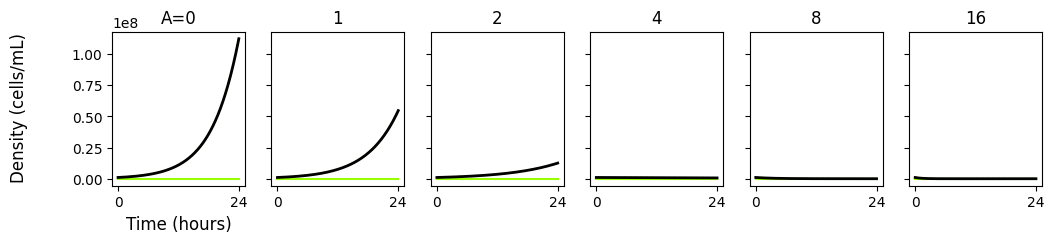

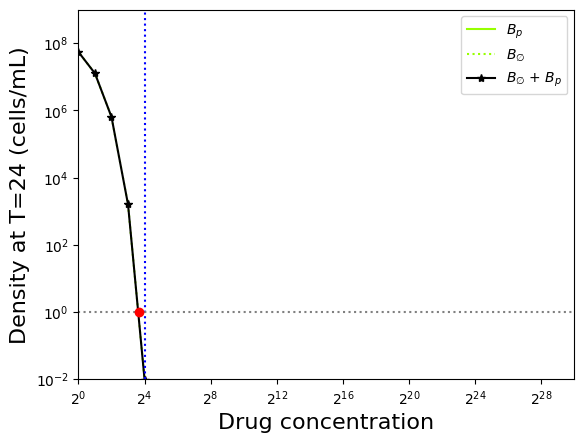

* best_kappa=0.0001220703125
	*expe_MIC = 6144.0	model_MIC = 7486.534465548037	kappa = (0.0625, 0.0001220703125) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 14.659987364839981	kappa = (0.0001220703125, 0.0001220703125)


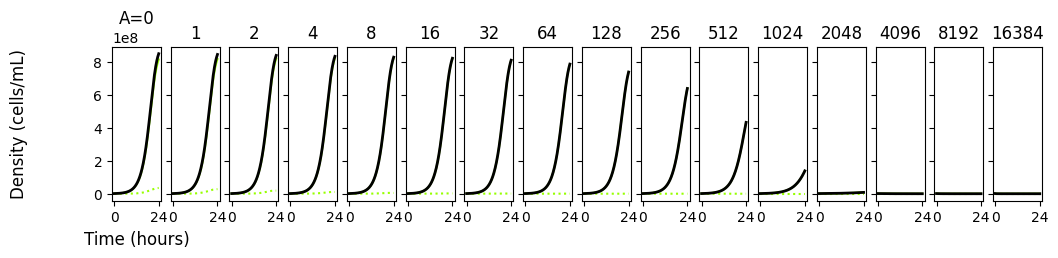

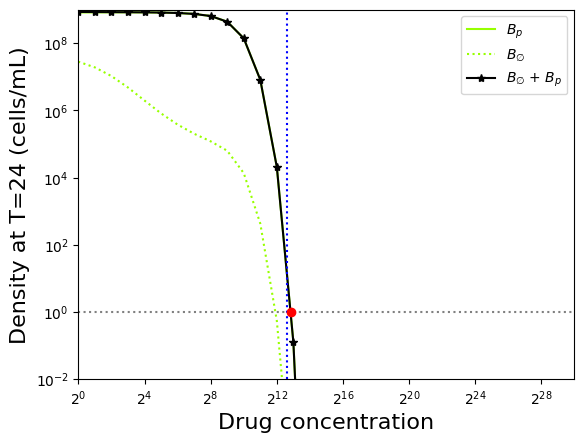

* best_kappa=0.0625
Strain 5:
	*expe_MIC = 32.0	model_MIC = 6223.049431376319	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 32.0	model_MIC = 24.308792419589274	kappa = (1.0, 0.000244140625) -> 0.000244140625*


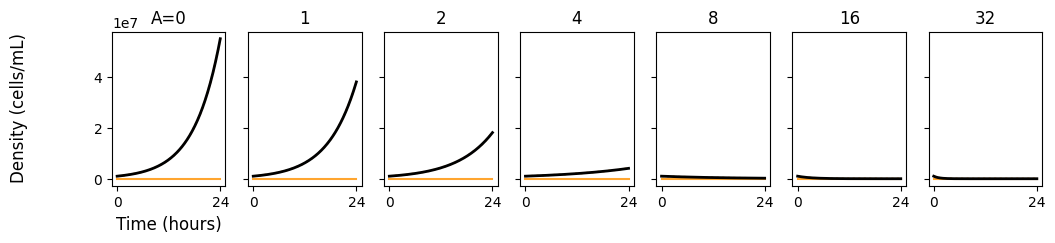

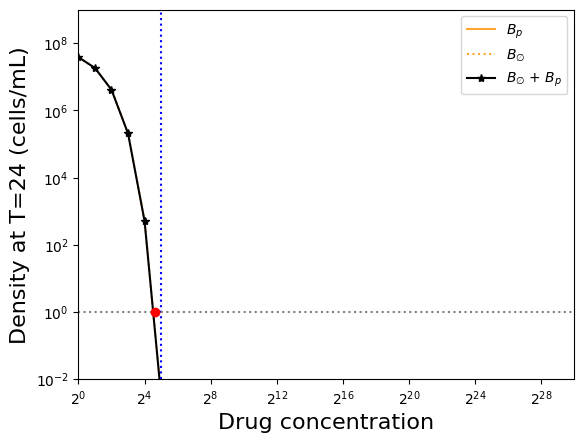

* best_kappa=0.000244140625
	*expe_MIC = 6144.0	model_MIC = 6899.768364665018	kappa = (0.0625, 0.000244140625) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 27.02442805217967	kappa = (0.000244140625, 0.000244140625)


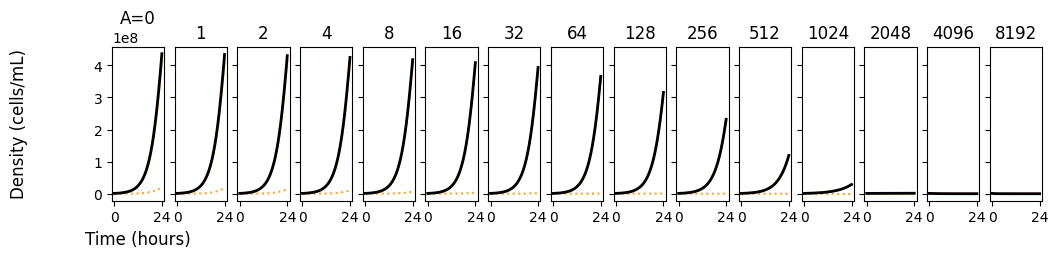

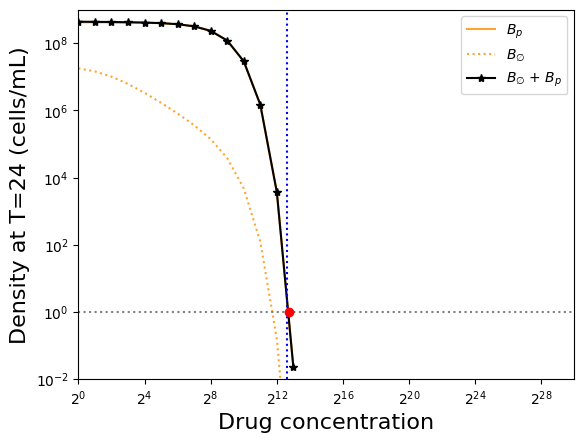

* best_kappa=0.0625
Strain 6:
	*expe_MIC = 64.0	model_MIC = 6556.5443888766895	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 64.0	model_MIC = 51.222997249671735	kappa = (1.0, 0.00048828125) -> 0.00048828125*


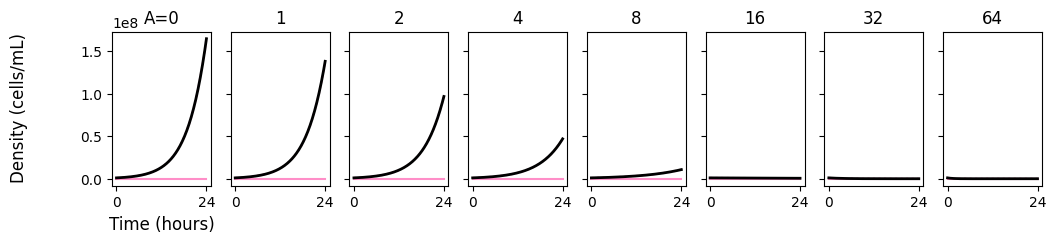

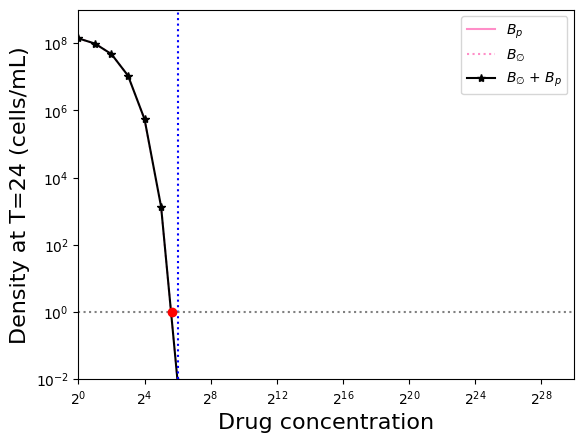

* best_kappa=0.00048828125
	*expe_MIC = 6144.0	model_MIC = 7377.551869764671	kappa = (0.0625, 0.00048828125) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 57.78988071559091	kappa = (0.00048828125, 0.00048828125)


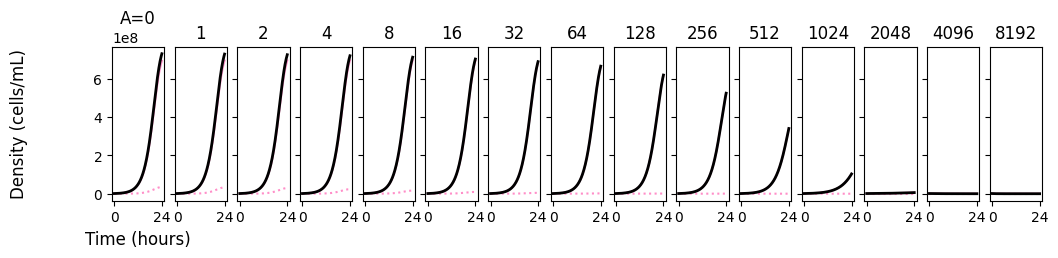

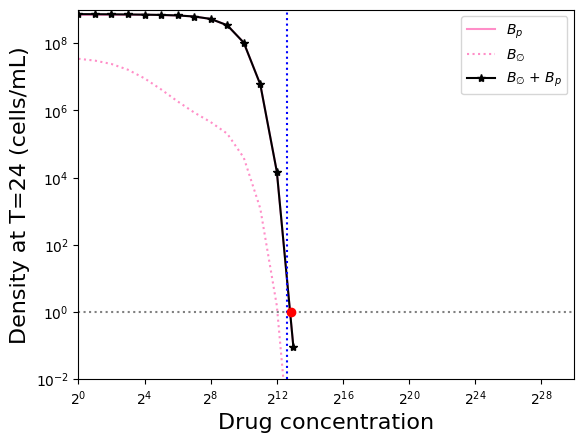

* best_kappa=0.0625
Strain 7:
	*expe_MIC = 32.0	model_MIC = 49.13523691501474	kappa = (1.0, 0.00048828125) -> 0.00048828125*
	*expe_MIC = 32.0	model_MIC = 24.567625913408698	kappa = (1.0, 0.000244140625) -> 0.000244140625*


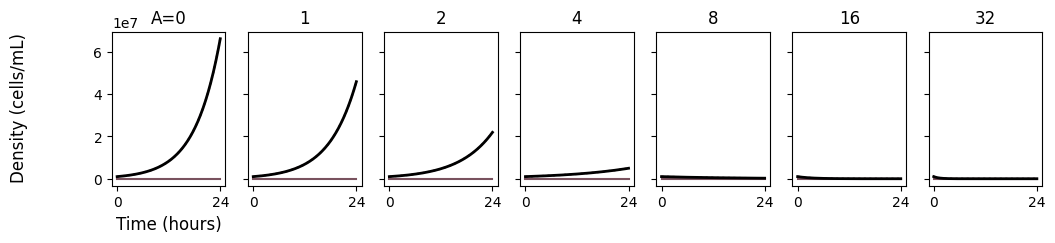

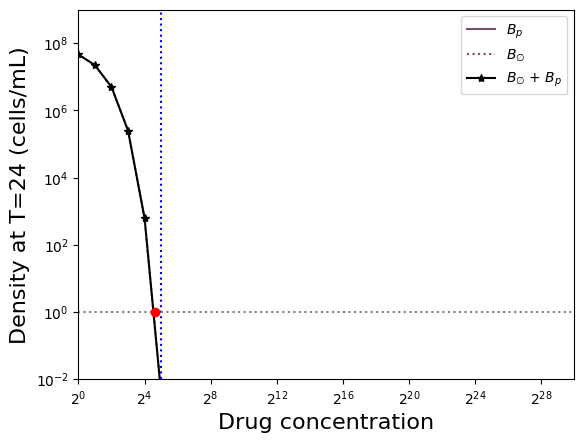

* best_kappa=0.000244140625
	*expe_MIC = 64.0	model_MIC = 53.079835686330014	kappa = (0.00048828125, 0.000244140625) -> 0.00048828125*
	**expe_MIC = 64.0	model_MIC = 26.613972829539414	kappa = (0.000244140625, 0.000244140625)


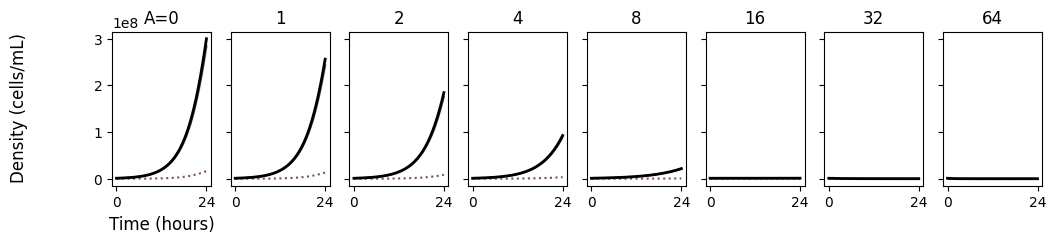

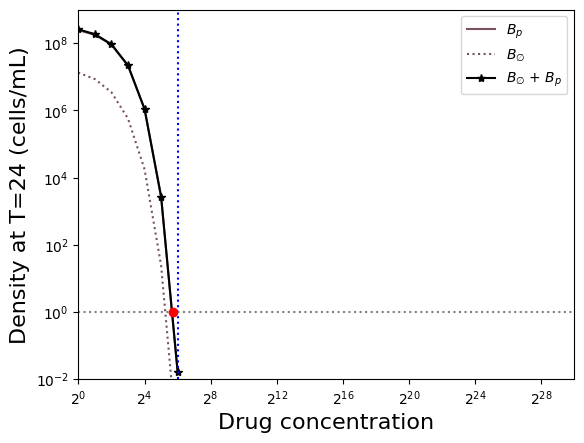

* best_kappa=0.00048828125
Strain 8:
	*expe_MIC = 16.0	model_MIC = 417.346529318017	kappa = (1.0, 0.00390625) -> 0.00390625*
	*expe_MIC = 16.0	model_MIC = 13.042080054946037	kappa = (1.0, 0.0001220703125) -> 0.0001220703125*


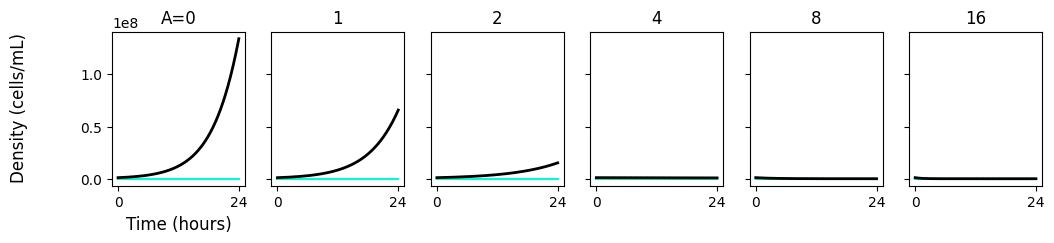

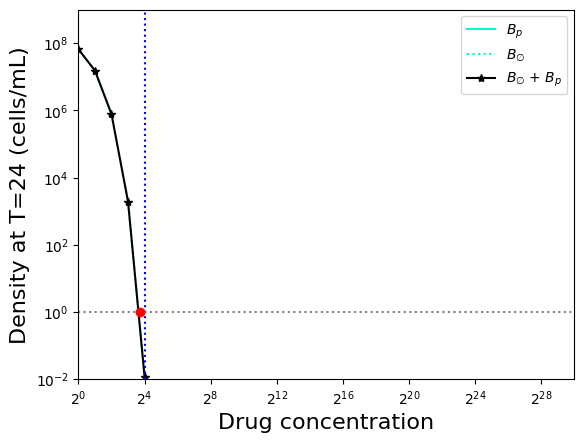

* best_kappa=0.0001220703125
	*expe_MIC = 512.0	model_MIC = 419.3963383613446	kappa = (0.00390625, 0.0001220703125) -> 0.00390625*
	**expe_MIC = 512.0	model_MIC = 13.176487937487014	kappa = (0.0001220703125, 0.0001220703125)


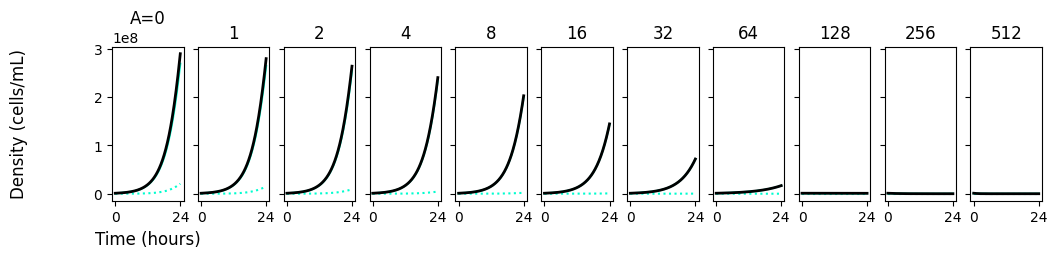

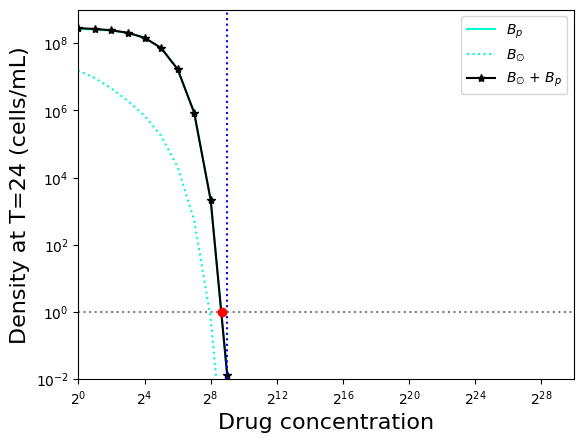

* best_kappa=0.00390625
Strain 9:
	*expe_MIC = 64.0	model_MIC = 3255.5114334994614	kappa = (1.0, 0.03125) -> 0.03125*
	*expe_MIC = 64.0	model_MIC = 50.867357741268634	kappa = (1.0, 0.00048828125) -> 0.00048828125*


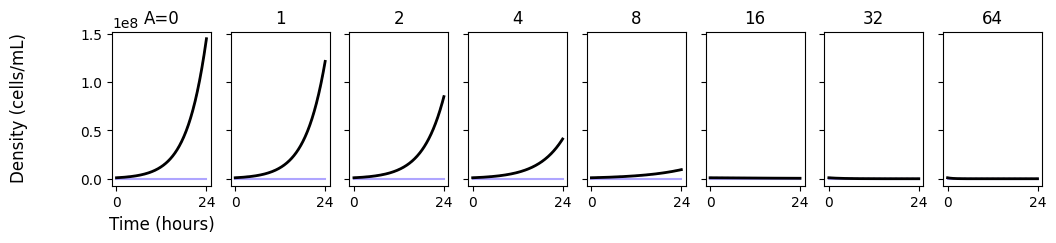

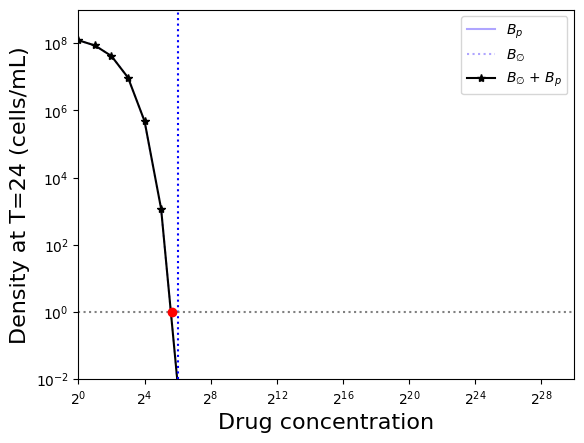

* best_kappa=0.00048828125
	*expe_MIC = 3072.0	model_MIC = 3392.383350447275	kappa = (0.03125, 0.00048828125) -> 0.03125*
	**expe_MIC = 3072.0	model_MIC = 53.212669881946496	kappa = (0.00048828125, 0.00048828125)


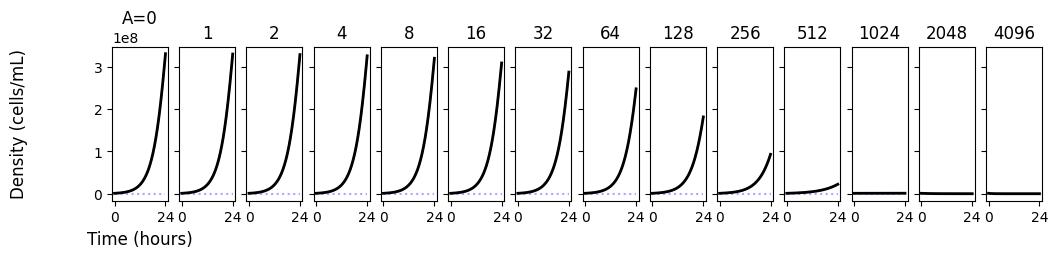

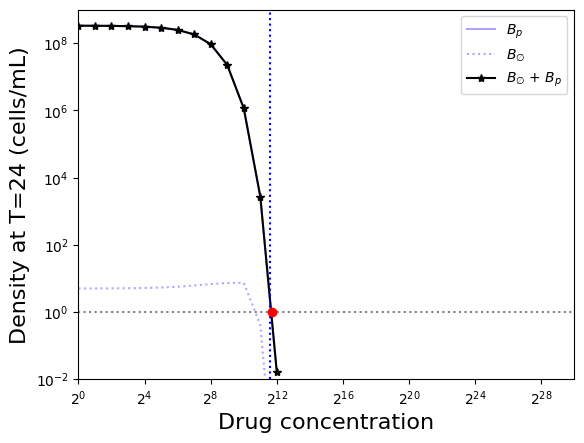

* best_kappa=0.03125
Strain 10:
	*expe_MIC = 32.0	model_MIC = 3318.3084296552825	kappa = (1.0, 0.03125) -> 0.03125*
	*expe_MIC = 32.0	model_MIC = 25.924283820987057	kappa = (1.0, 0.000244140625) -> 0.000244140625*


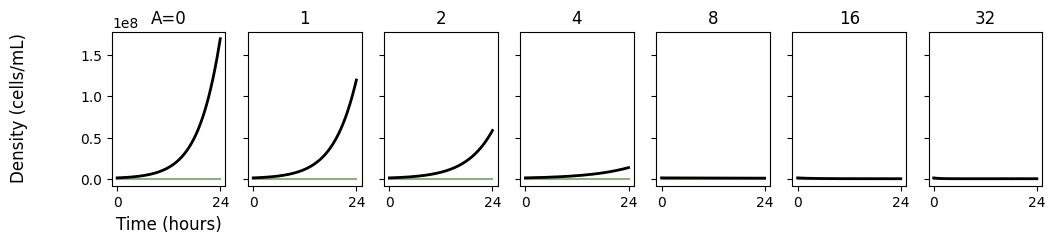

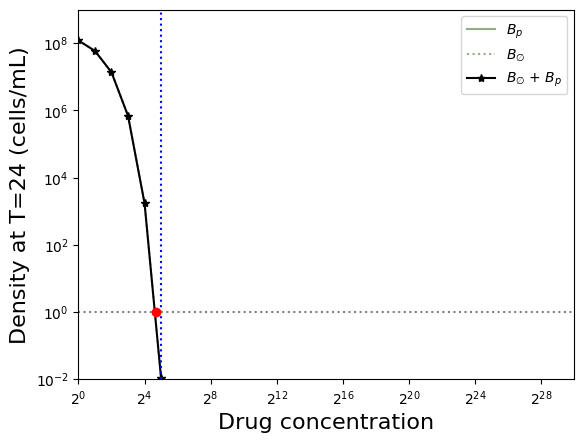

* best_kappa=0.000244140625
	*expe_MIC = 3072.0	model_MIC = 3693.295441408576	kappa = (0.03125, 0.000244140625) -> 0.03125*
	**expe_MIC = 3072.0	model_MIC = 28.935687131715063	kappa = (0.000244140625, 0.000244140625)


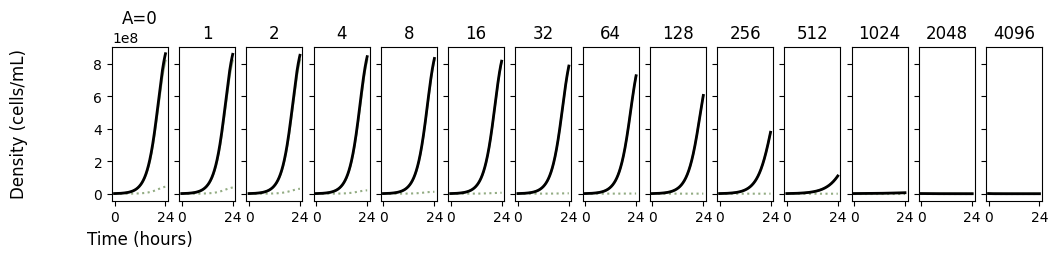

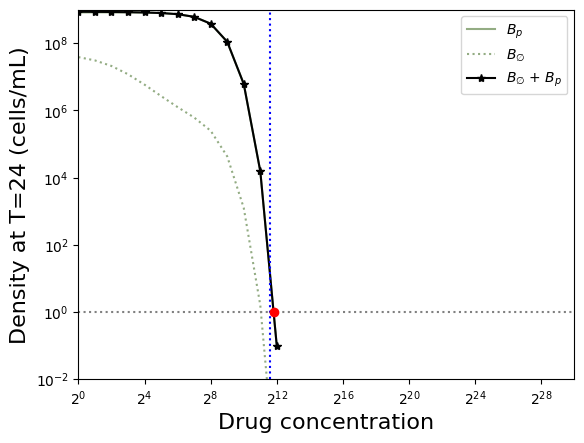

* best_kappa=0.03125
Strain 11:
	*expe_MIC = 64.0	model_MIC = 6510.0184533449265	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 64.0	model_MIC = 50.859517013067986	kappa = (1.0, 0.00048828125) -> 0.00048828125*


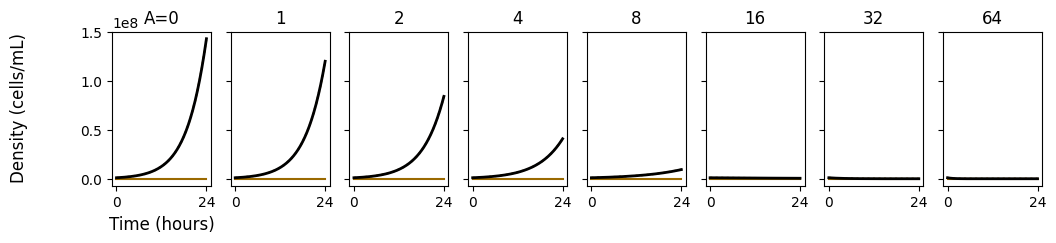

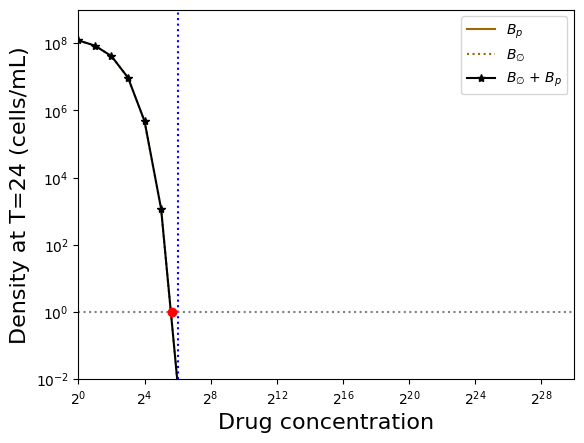

* best_kappa=0.00048828125
	*expe_MIC = 6144.0	model_MIC = 6575.25411138643	kappa = (0.0625, 0.00048828125) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 51.50243797474113	kappa = (0.00048828125, 0.00048828125)


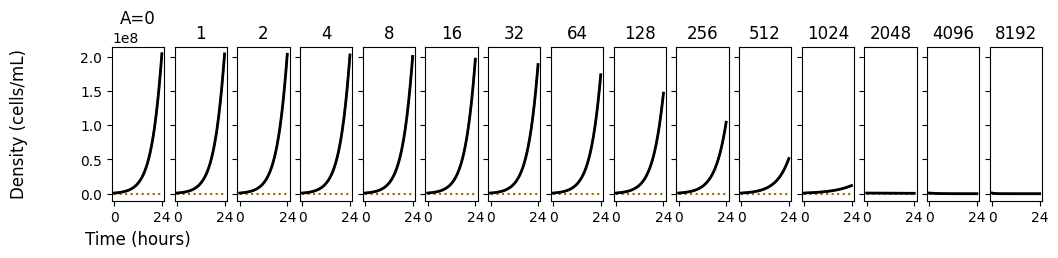

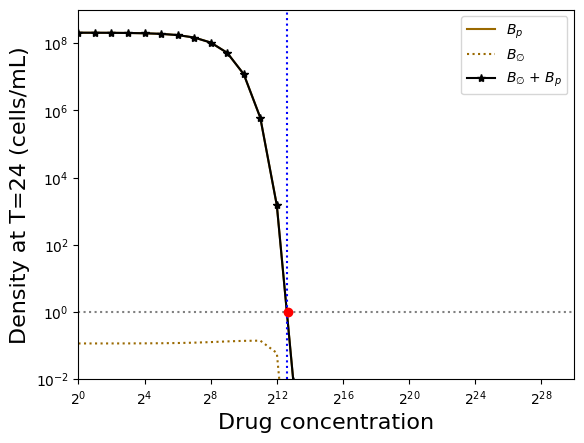

* best_kappa=0.0625
Strain 12:
	*expe_MIC = 16.0	model_MIC = 789.460109086757	kappa = (1.0, 0.0078125) -> 0.0078125*
	*expe_MIC = 16.0	model_MIC = 12.335314015390352	kappa = (1.0, 0.0001220703125) -> 0.0001220703125*


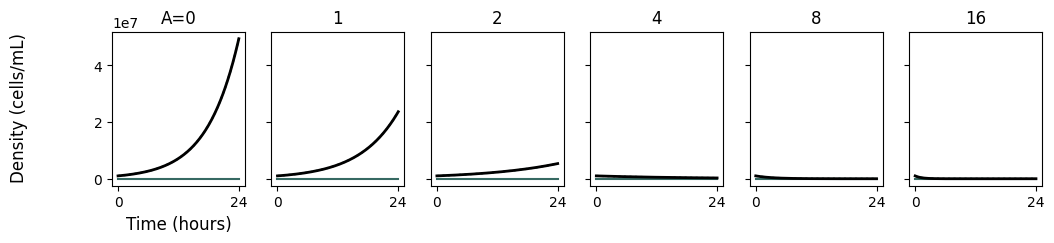

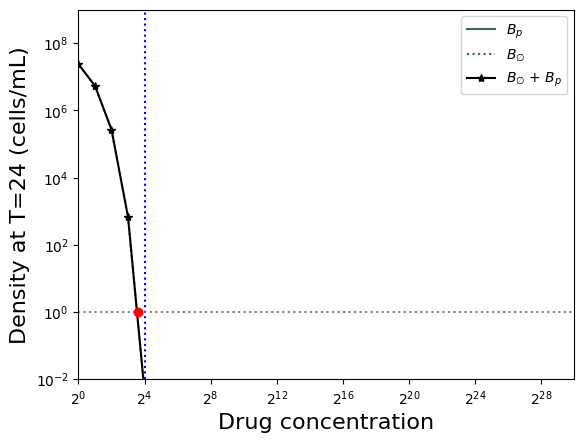

* best_kappa=0.0001220703125
	*expe_MIC = 1024.0	model_MIC = 791.2841775436306	kappa = (0.0078125, 0.0001220703125) -> 0.0078125*
	**expe_MIC = 1024.0	model_MIC = 12.422853242196105	kappa = (0.0001220703125, 0.0001220703125)


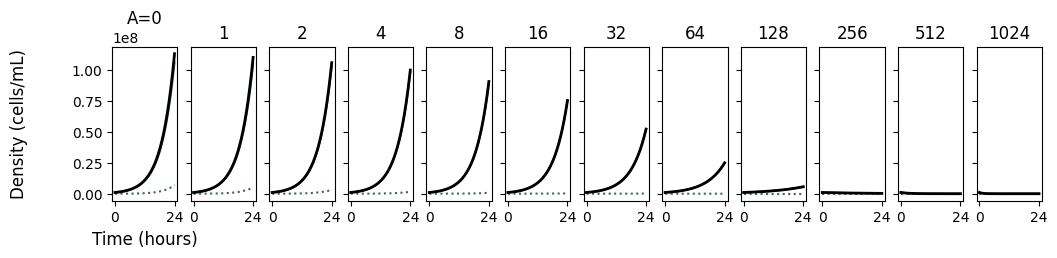

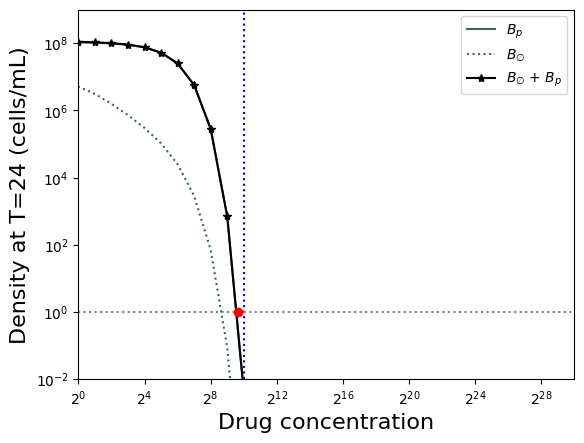

* best_kappa=0.0078125
Strain 13:
	*expe_MIC = 8.0	model_MIC = 6183.679712367351	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 8.0	model_MIC = 6.038751051964189	kappa = (1.0, 6.103515625e-05) -> 6.103515625e-05*


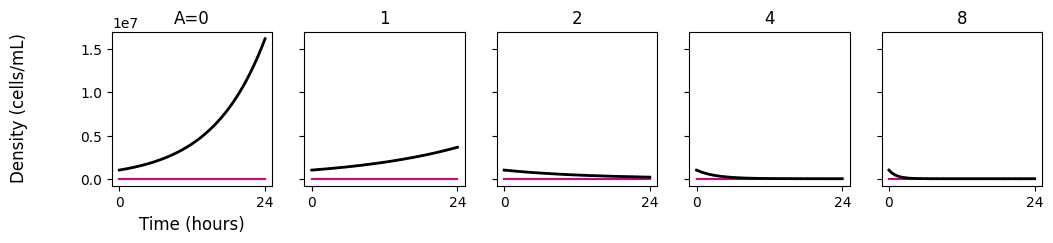

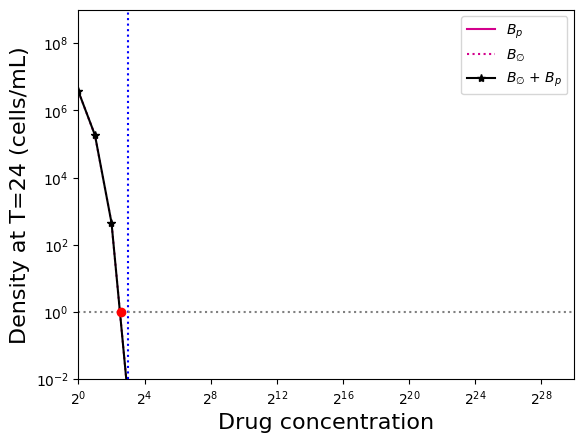

* best_kappa=6.103515625e-05
	*expe_MIC = 8192.0	model_MIC = 6438.745494631603	kappa = (0.0625, 6.103515625e-05) -> 0.0625*
	**expe_MIC = 8192.0	model_MIC = 6.3107593049724136	kappa = (6.103515625e-05, 6.103515625e-05)


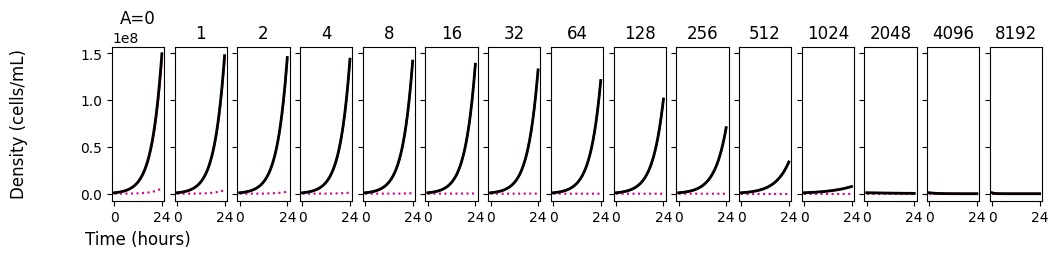

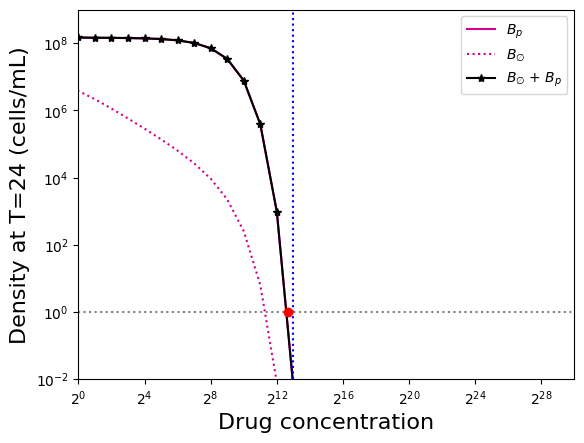

* best_kappa=0.0625
Strain 14:
	*expe_MIC = 64.0	model_MIC = 55.64782212550065	kappa = (1.0, 0.00048828125) -> 0.00048828125*
	*expe_MIC = 64.0	model_MIC = 55.64782212550065	kappa = (1.0, 0.00048828125) -> 0.00048828125*


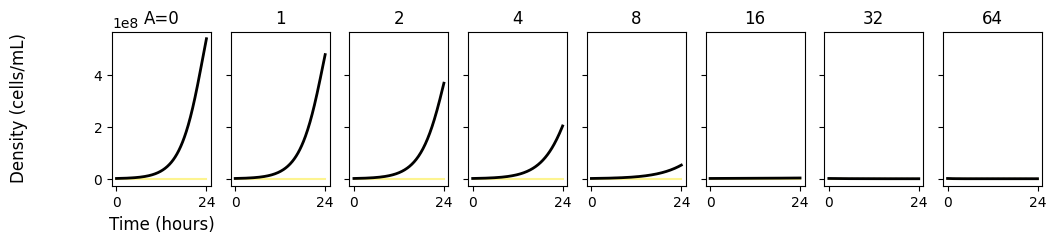

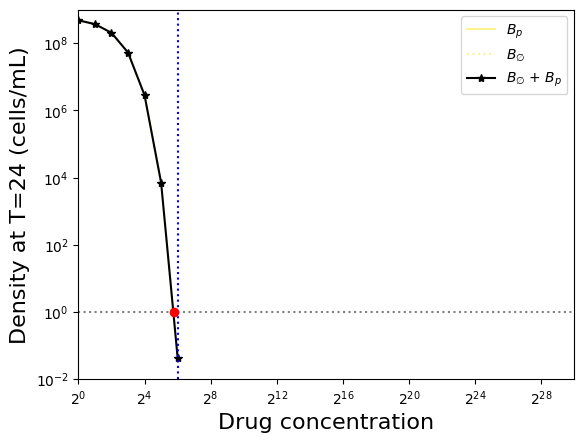

* best_kappa=0.00048828125
	*expe_MIC = 64.0	model_MIC = 55.050660092317784	kappa = (0.00048828125, 0.00048828125) -> 0.00048828125*
	*expe_MIC = 64.0	model_MIC = 55.050660092317784	kappa = (0.00048828125, 0.00048828125) -> 0.00048828125*


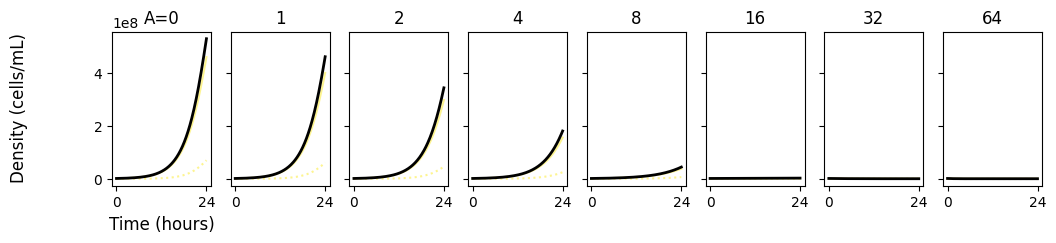

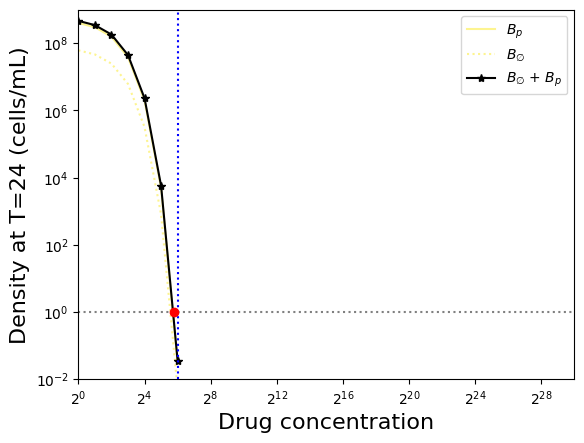

* best_kappa=0.00048828125
Strain 15:
	*expe_MIC = 32.0	model_MIC = 5990.288843714841	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 32.0	model_MIC = 23.399567468902873	kappa = (1.0, 0.000244140625) -> 0.000244140625*


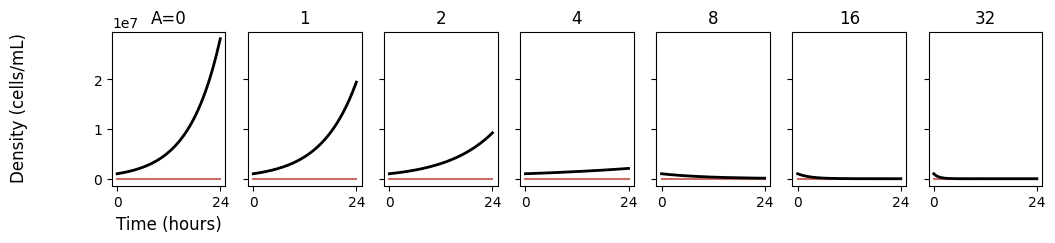

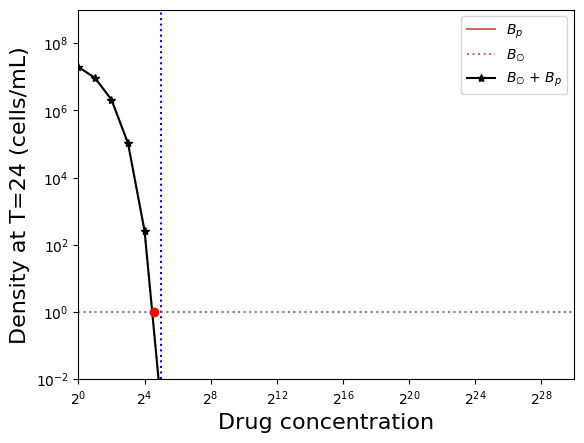

* best_kappa=0.000244140625
	*expe_MIC = 8192.0	model_MIC = 6786.789284402277	kappa = (0.0625, 0.000244140625) -> 0.0625*
	**expe_MIC = 8192.0	model_MIC = 26.57199697385793	kappa = (0.000244140625, 0.000244140625)


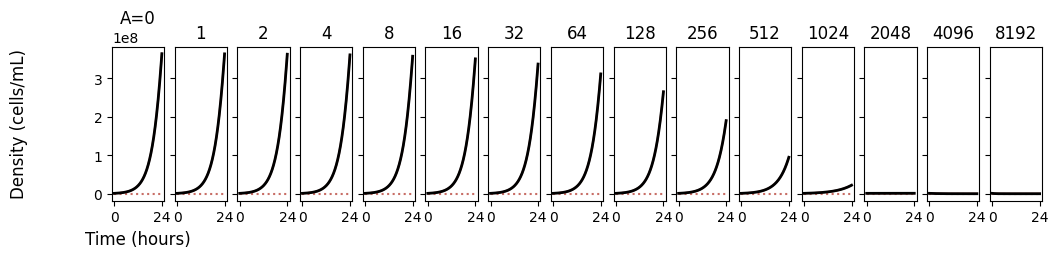

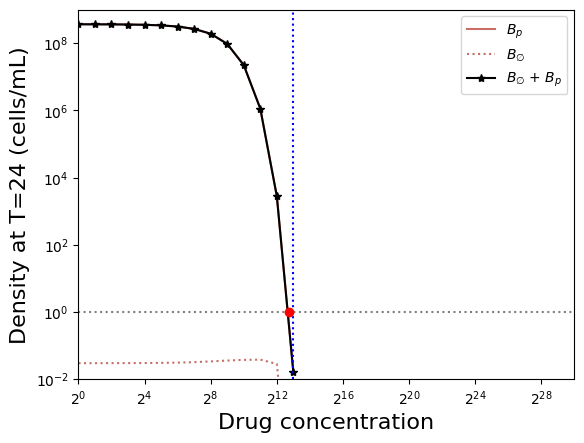

* best_kappa=0.0625
Strain 16:
	*expe_MIC = 8.0	model_MIC = 845.772669133464	kappa = (1.0, 0.0078125) -> 0.0078125*
	*expe_MIC = 8.0	model_MIC = 6.607599188757922	kappa = (1.0, 6.103515625e-05) -> 6.103515625e-05*


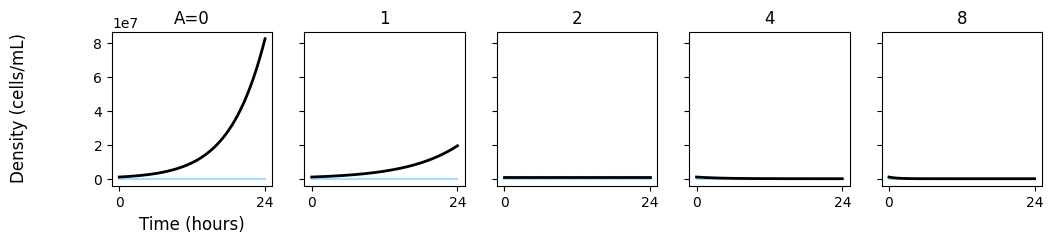

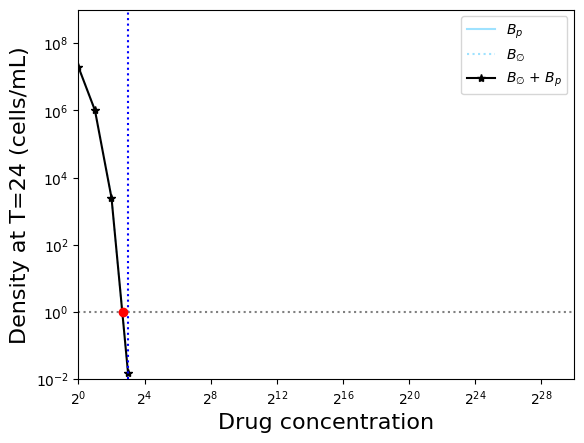

* best_kappa=6.103515625e-05
	*expe_MIC = 1024.0	model_MIC = 900.6890164446434	kappa = (0.0078125, 6.103515625e-05) -> 0.0078125*
	**expe_MIC = 1024.0	model_MIC = 7.062921879039165	kappa = (6.103515625e-05, 6.103515625e-05)


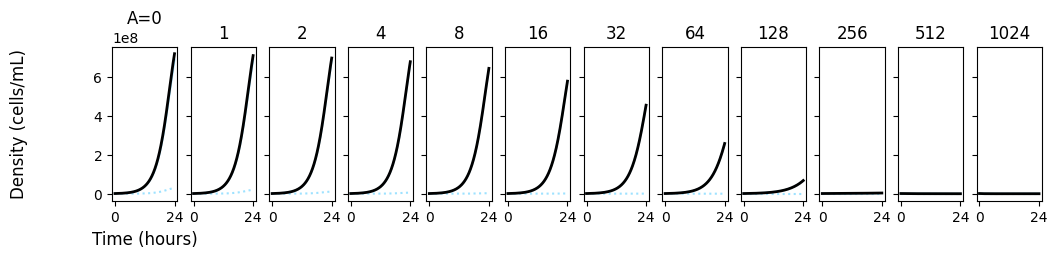

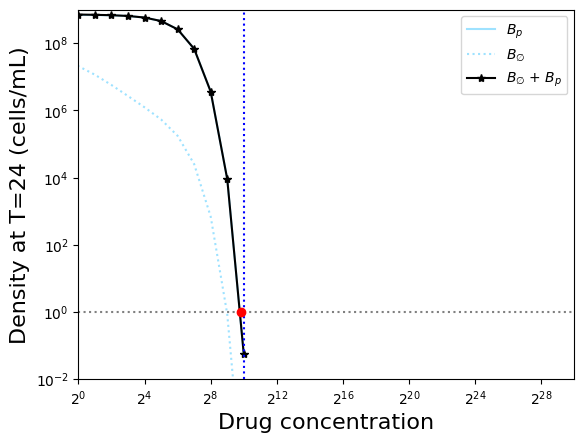

* best_kappa=0.0078125
Strain 17:
	*expe_MIC = 32.0	model_MIC = 7038.629750587225	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 32.0	model_MIC = 27.49464615497658	kappa = (1.0, 0.000244140625) -> 0.000244140625*


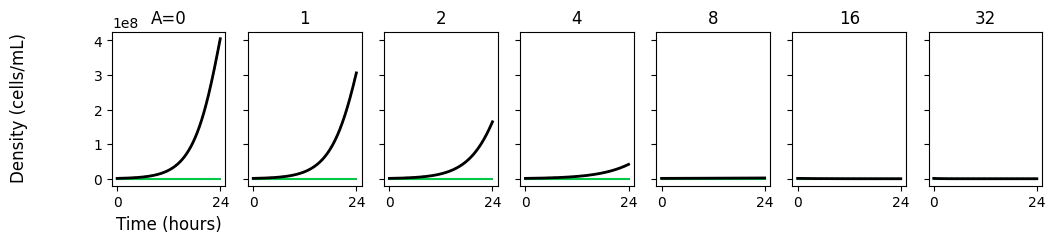

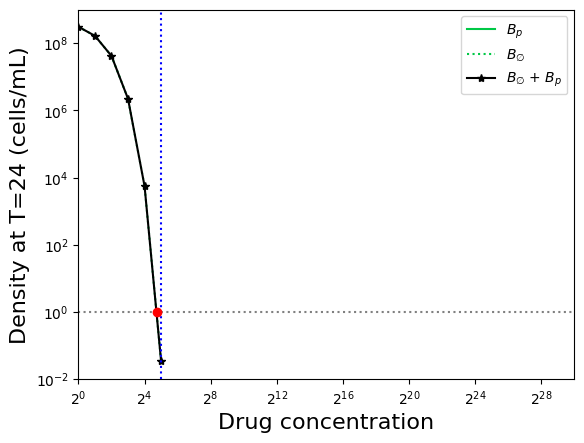

* best_kappa=0.000244140625
	*expe_MIC = 8192.0	model_MIC = 7319.047587058725	kappa = (0.0625, 0.000244140625) -> 0.0625*
	**expe_MIC = 8192.0	model_MIC = 28.722085418565996	kappa = (0.000244140625, 0.000244140625)


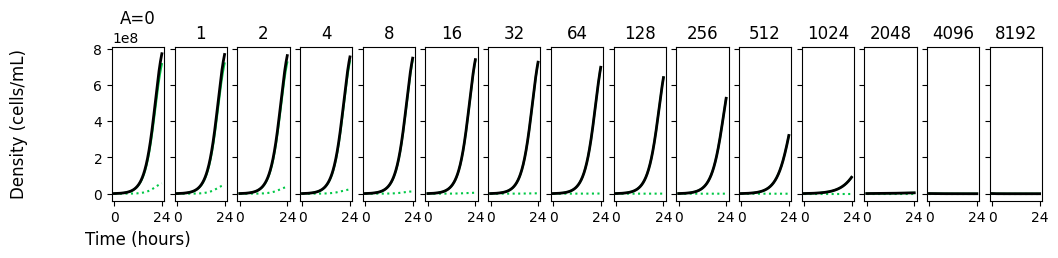

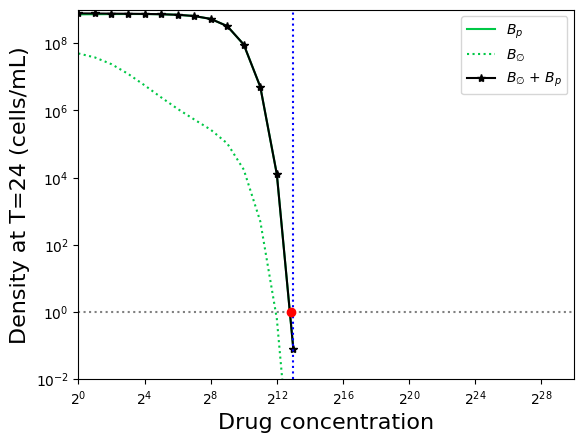

* best_kappa=0.0625
Strain 18:
	*expe_MIC = 16.0	model_MIC = 6296.0463600163375	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 16.0	model_MIC = 12.296964878776047	kappa = (1.0, 0.0001220703125) -> 0.0001220703125*


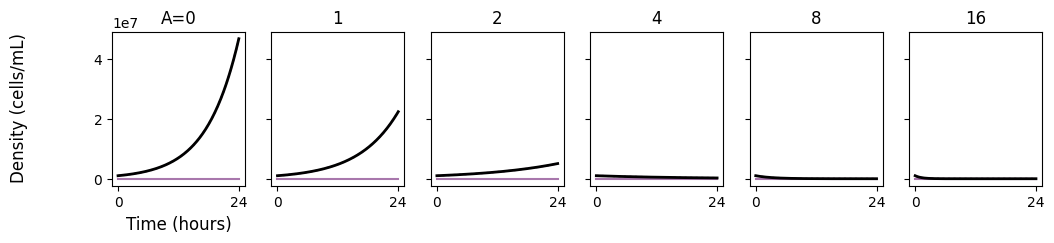

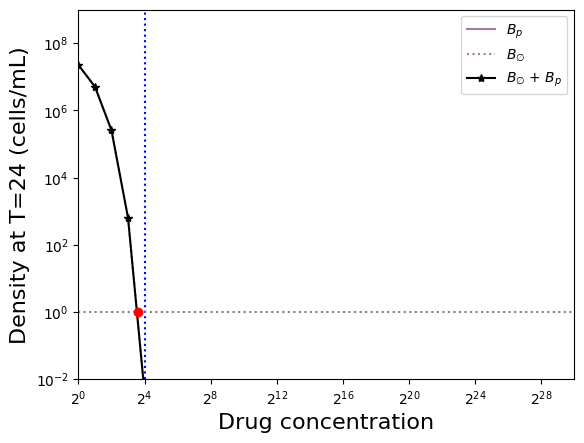

* best_kappa=0.0001220703125
	*expe_MIC = 6144.0	model_MIC = 7199.826302275209	kappa = (0.0625, 0.0001220703125) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 14.095371854037076	kappa = (0.0001220703125, 0.0001220703125)


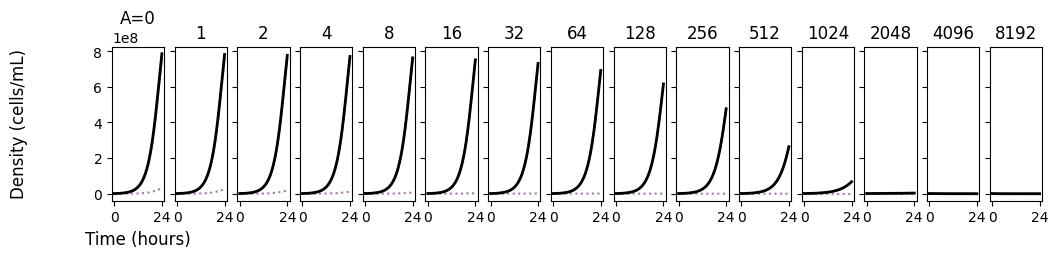

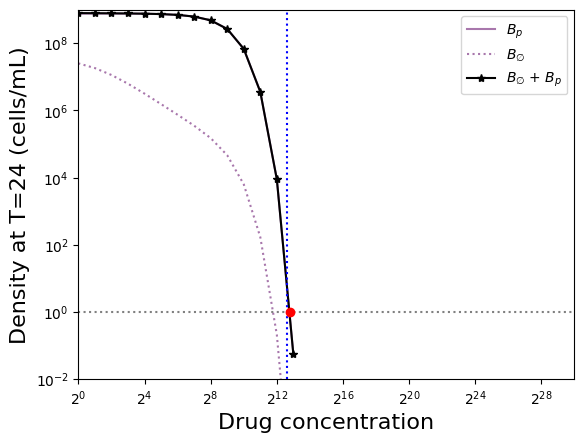

* best_kappa=0.0625
Strain 19:
	*expe_MIC = 32.0	model_MIC = 3087.052417329193	kappa = (1.0, 0.03125) -> 0.03125*
	*expe_MIC = 32.0	model_MIC = 24.117589443170964	kappa = (1.0, 0.000244140625) -> 0.000244140625*


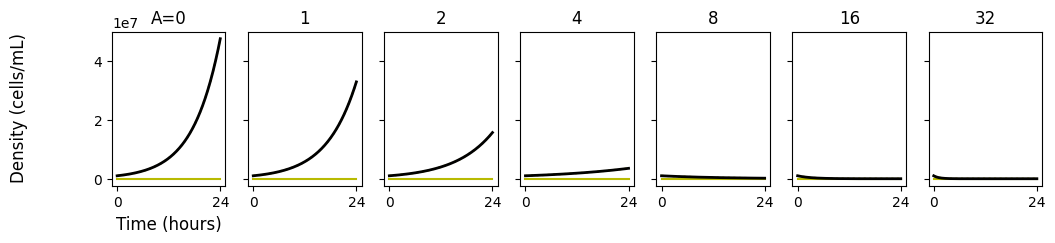

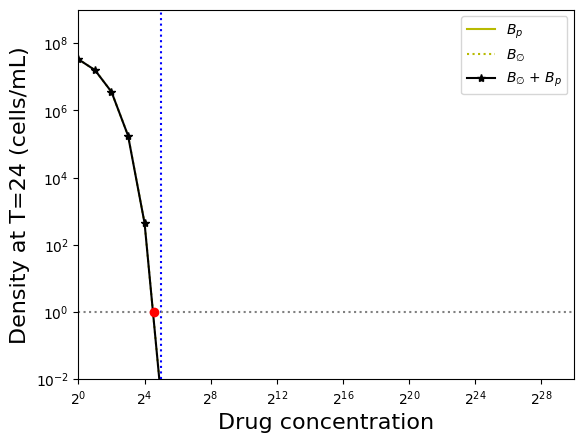

* best_kappa=0.000244140625
	*expe_MIC = 3072.0	model_MIC = 3636.775650008166	kappa = (0.03125, 0.000244140625) -> 0.03125*
	**expe_MIC = 3072.0	model_MIC = 28.470525329839276	kappa = (0.000244140625, 0.000244140625)


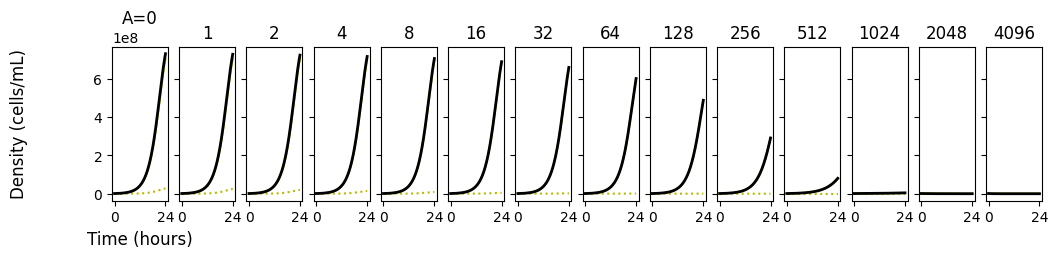

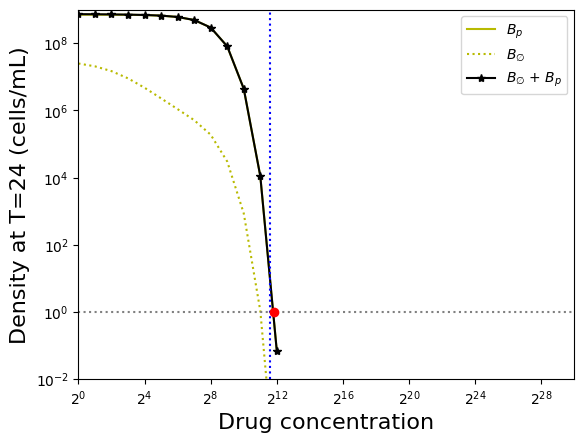

* best_kappa=0.03125
Strain 20:
	*expe_MIC = 64.0	model_MIC = 6854.958594835152	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 64.0	model_MIC = 53.55436402214963	kappa = (1.0, 0.00048828125) -> 0.00048828125*


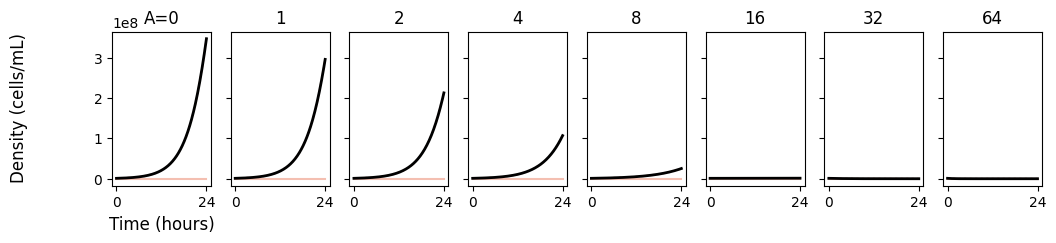

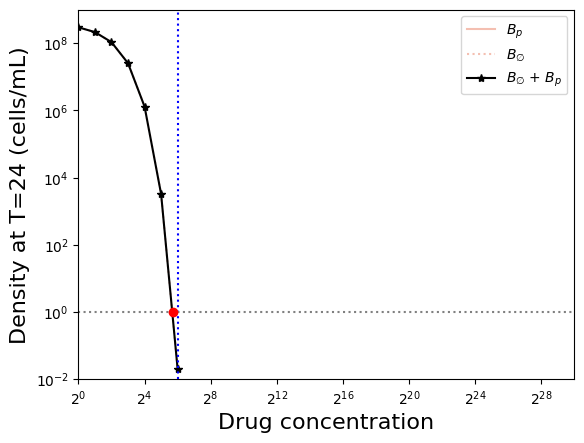

* best_kappa=0.00048828125
	*expe_MIC = 8192.0	model_MIC = 6227.6837504792675	kappa = (0.0625, 0.00048828125) -> 0.0625*
	**expe_MIC = 8192.0	model_MIC = 48.886594279638715	kappa = (0.00048828125, 0.00048828125)


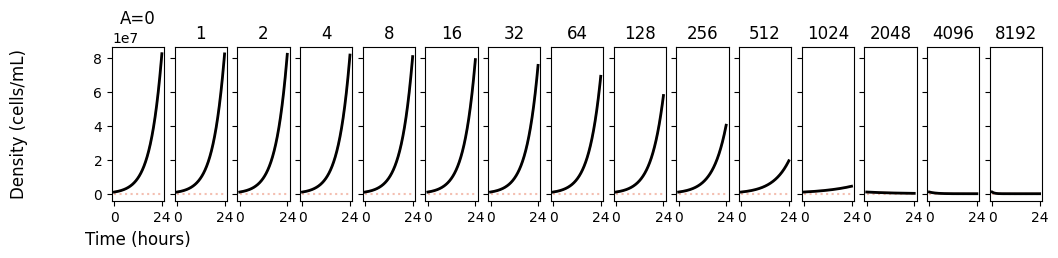

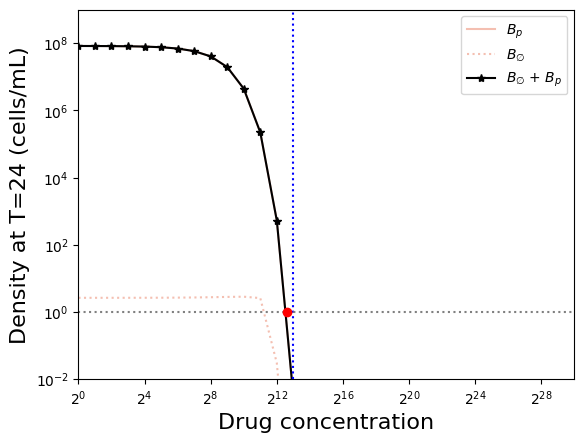

* best_kappa=0.0625
Strain 21:
	*expe_MIC = 16.0	model_MIC = 6669.542115646211	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 16.0	model_MIC = 13.026447900160958	kappa = (1.0, 0.0001220703125) -> 0.0001220703125*


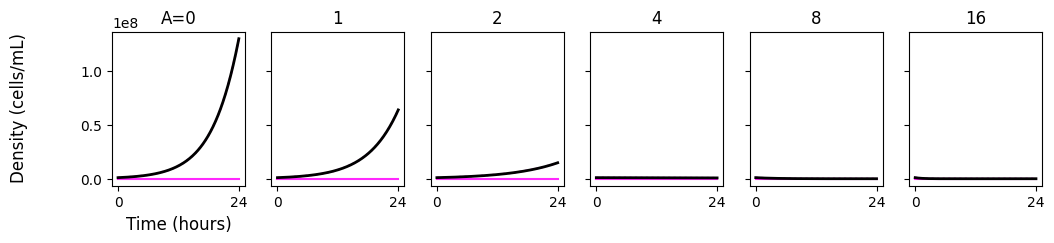

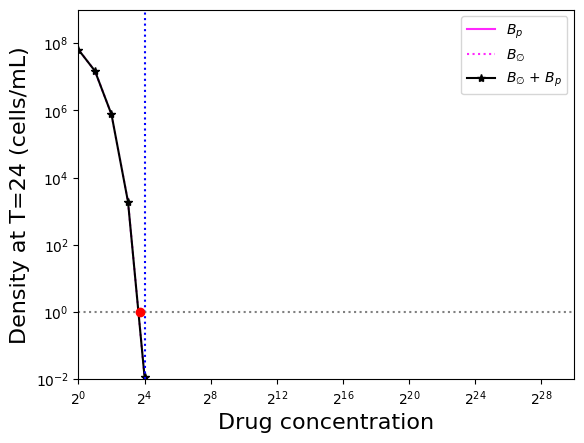

* best_kappa=0.0001220703125
	*expe_MIC = 6144.0	model_MIC = 6641.301345947766	kappa = (0.0625, 0.0001220703125) -> 0.0625*
	**expe_MIC = 6144.0	model_MIC = 13.045489252706819	kappa = (0.0001220703125, 0.0001220703125)


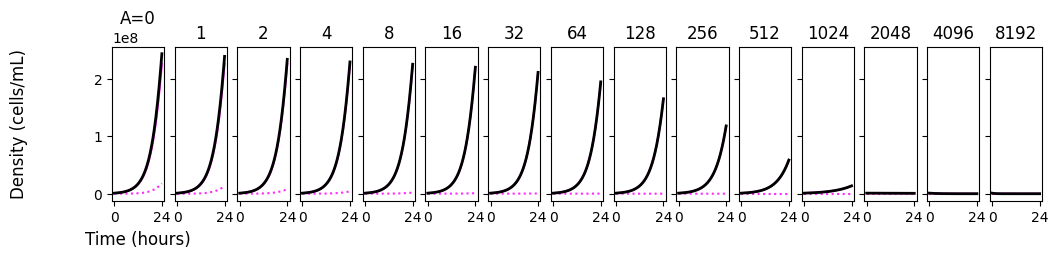

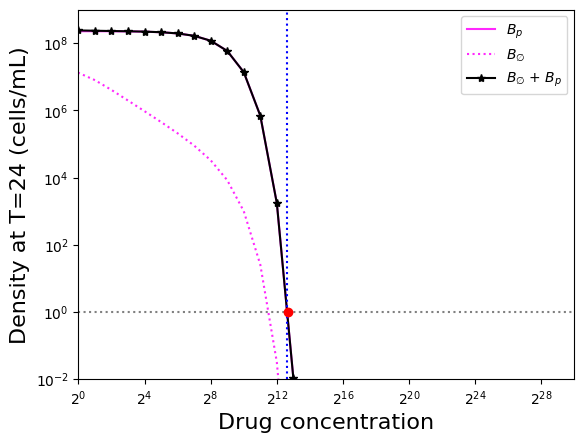

* best_kappa=0.0625
Strain 22:
	*expe_MIC = 64.0	model_MIC = 3431.014184971911	kappa = (1.0, 0.03125) -> 0.03125*
	*expe_MIC = 64.0	model_MIC = 53.609598683817616	kappa = (1.0, 0.00048828125) -> 0.00048828125*


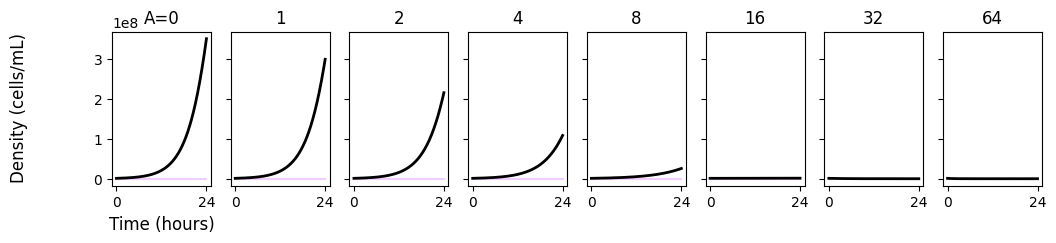

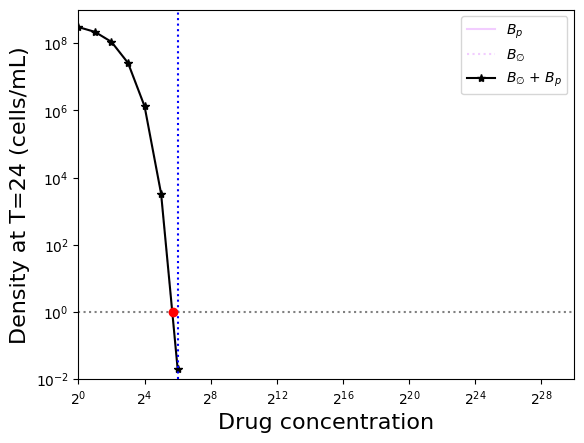

* best_kappa=0.00048828125
	*expe_MIC = 4096.0	model_MIC = 3324.740810611722	kappa = (0.03125, 0.00048828125) -> 0.03125*
	**expe_MIC = 4096.0	model_MIC = 52.33860561093542	kappa = (0.00048828125, 0.00048828125)


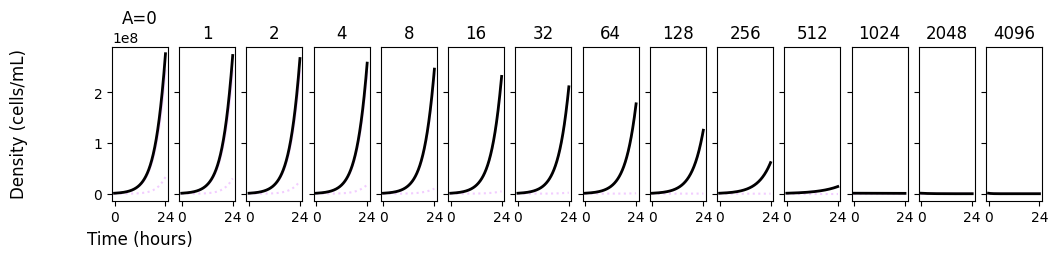

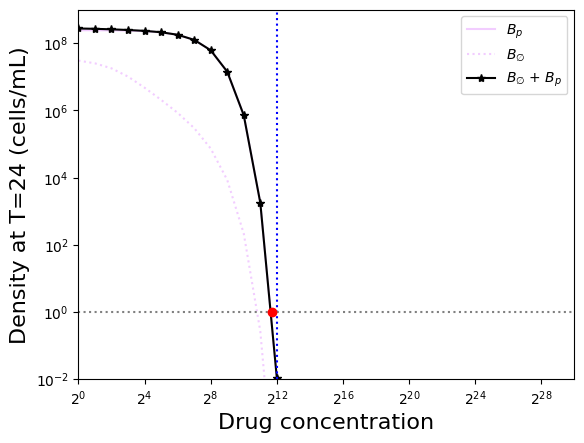

* best_kappa=0.03125
Strain 23:
	*expe_MIC = 64.0	model_MIC = 3598.390454574012	kappa = (1.0, 0.03125) -> 0.03125*
	*expe_MIC = 64.0	model_MIC = 56.22485085271894	kappa = (1.0, 0.00048828125) -> 0.00048828125*


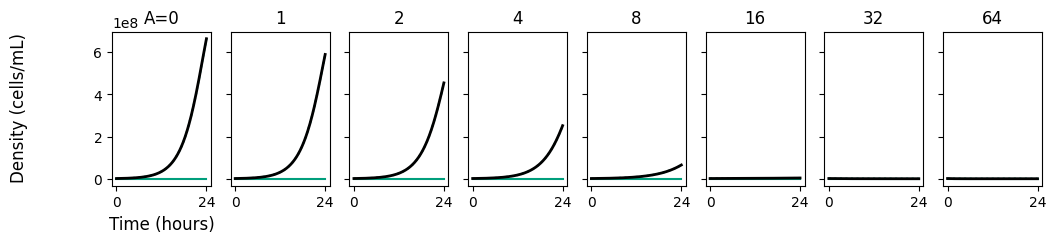

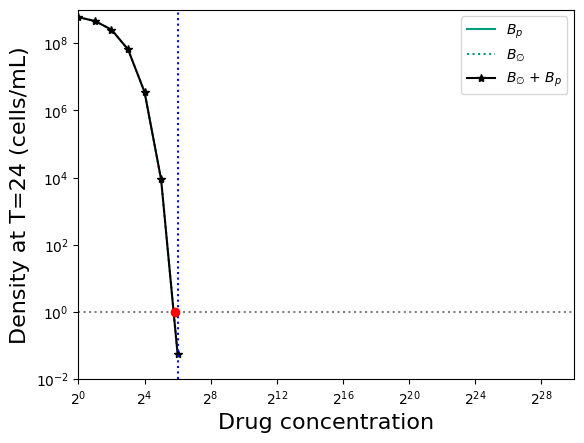

* best_kappa=0.00048828125
	*expe_MIC = 4096.0	model_MIC = 3320.4260933074465	kappa = (0.03125, 0.00048828125) -> 0.03125*
	**expe_MIC = 4096.0	model_MIC = 52.54855942495547	kappa = (0.00048828125, 0.00048828125)


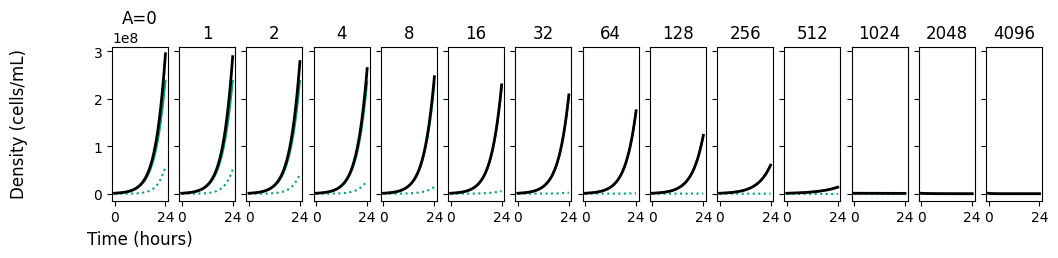

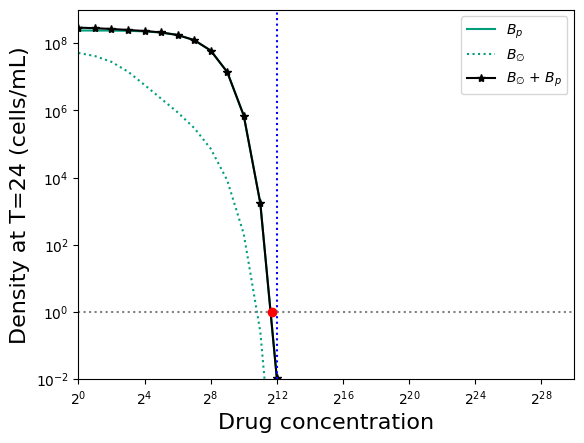

* best_kappa=0.03125
Strain 24:
	*expe_MIC = 128.0	model_MIC = 461.5619839006363	kappa = (1.0, 0.00390625) -> 0.00390625*
	*expe_MIC = 128.0	model_MIC = 115.39049597515907	kappa = (1.0, 0.0009765625) -> 0.0009765625*


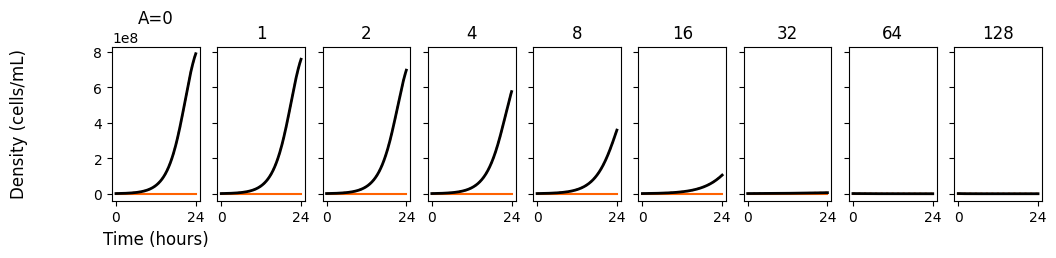

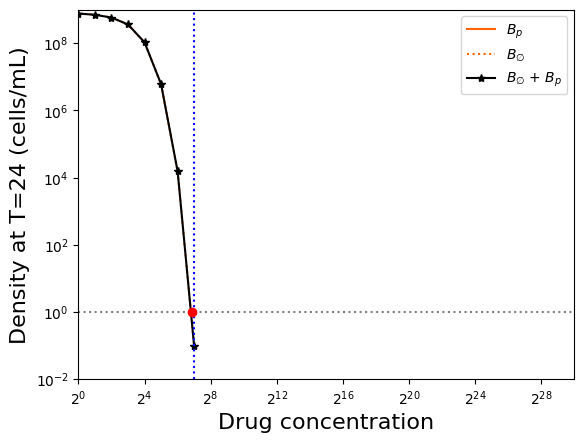

* best_kappa=0.0009765625
	*expe_MIC = 512.0	model_MIC = 445.6882803758378	kappa = (0.00390625, 0.0009765625) -> 0.00390625*
	**expe_MIC = 512.0	model_MIC = 111.74848254127585	kappa = (0.0009765625, 0.0009765625)


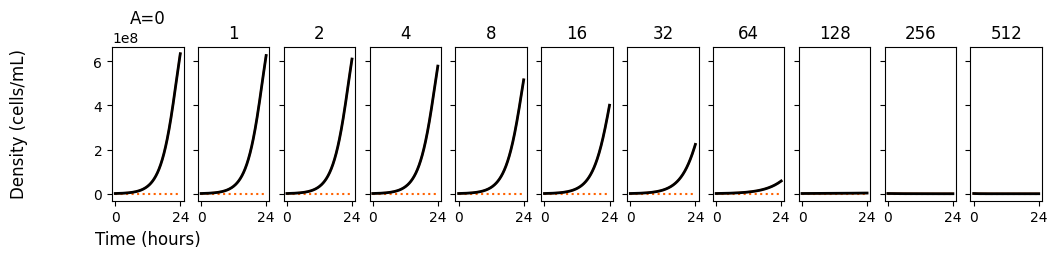

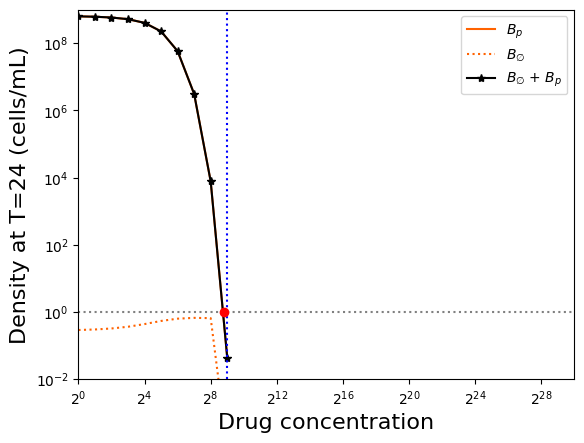

* best_kappa=0.00390625
Strain 25:
	*expe_MIC = 128.0	model_MIC = 13774.319421660546	kappa = (1.0, 0.125) -> 0.125*
	*expe_MIC = 128.0	model_MIC = 107.61186823955008	kappa = (1.0, 0.0009765625) -> 0.0009765625*


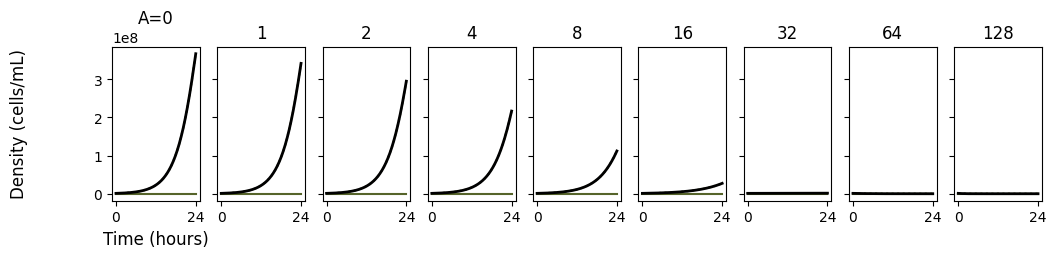

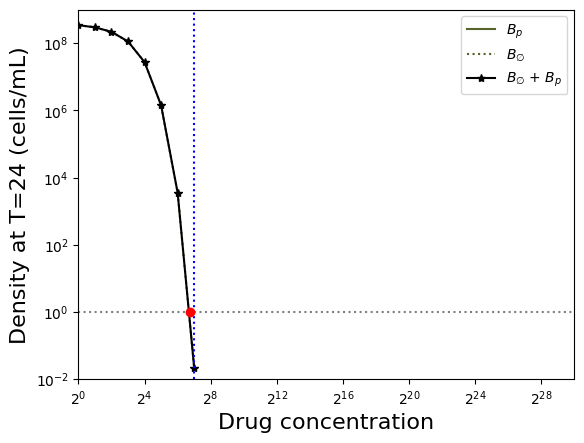

* best_kappa=0.0009765625
	*expe_MIC = 16384.0	model_MIC = 14443.359631351927	kappa = (0.125, 0.0009765625) -> 0.125*
	**expe_MIC = 16384.0	model_MIC = 113.43810555689177	kappa = (0.0009765625, 0.0009765625)


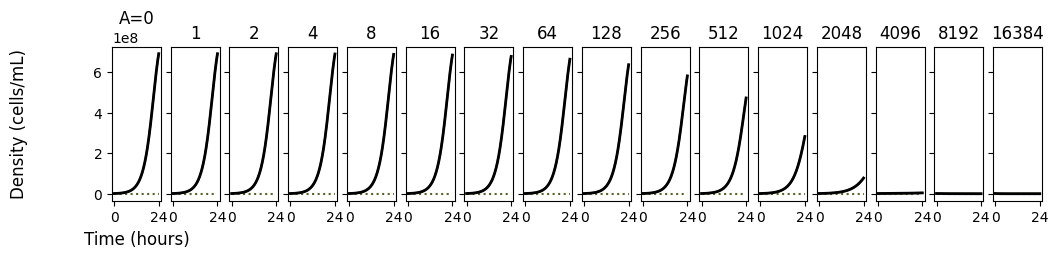

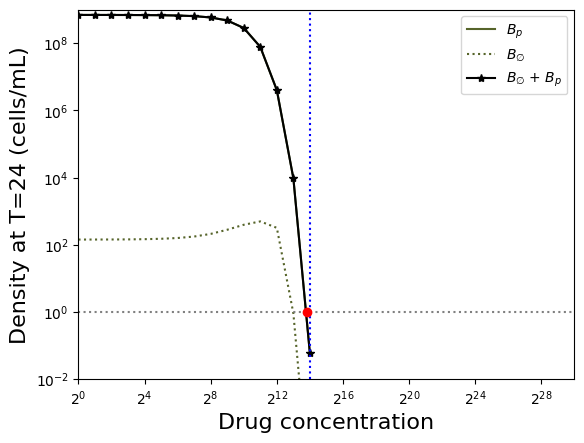

* best_kappa=0.125
Strain 26:
	*expe_MIC = 64.0	model_MIC = 24991.732499952326	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 64.0	model_MIC = 48.811991161131715	kappa = (1.0, 0.00048828125) -> 0.00048828125*


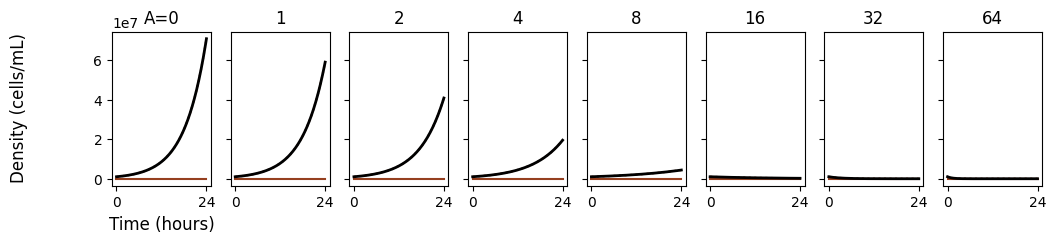

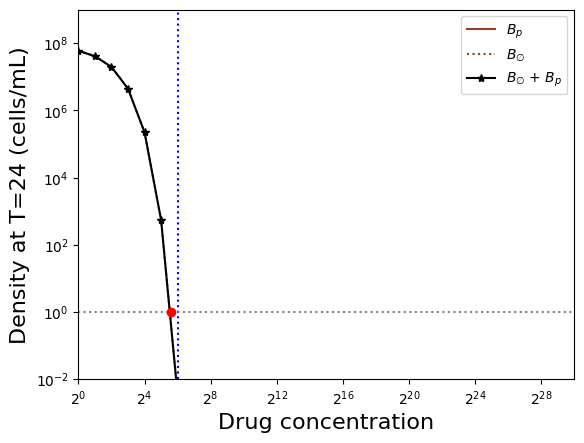

* best_kappa=0.00048828125
	*expe_MIC = 28672.0	model_MIC = 25979.627774708744	kappa = (0.25, 0.00048828125) -> 0.25*
	**expe_MIC = 28672.0	model_MIC = 50.86070587564552	kappa = (0.00048828125, 0.00048828125)


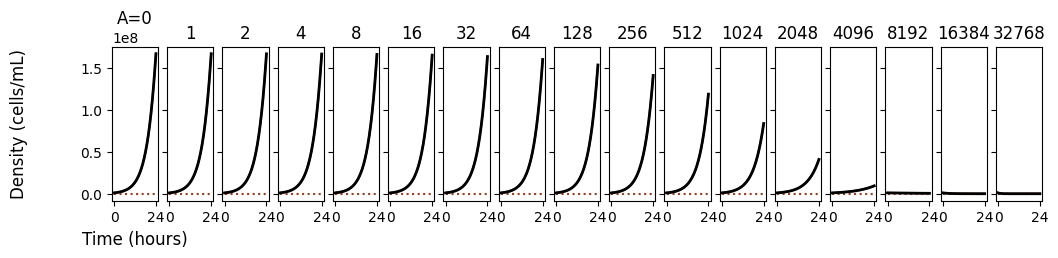

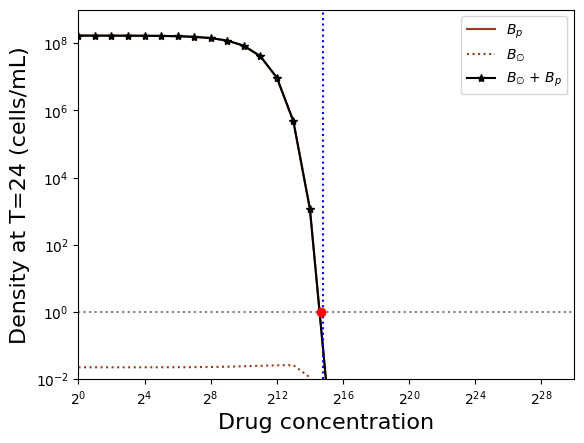

* best_kappa=0.25
Strain 27:
	*expe_MIC = 128.0	model_MIC = 25839.26690584539	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 128.0	model_MIC = 100.93462262277244	kappa = (1.0, 0.0009765625) -> 0.0009765625*


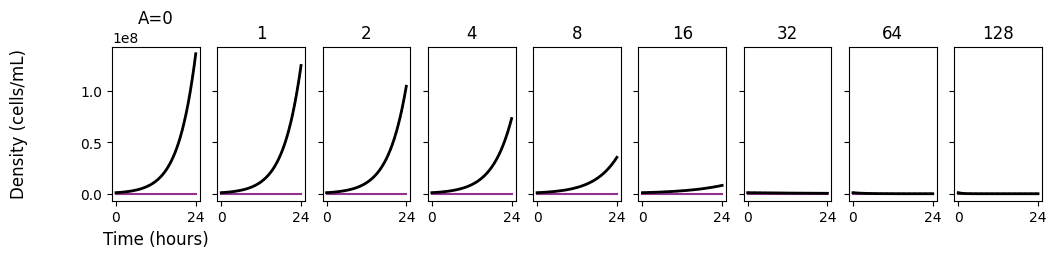

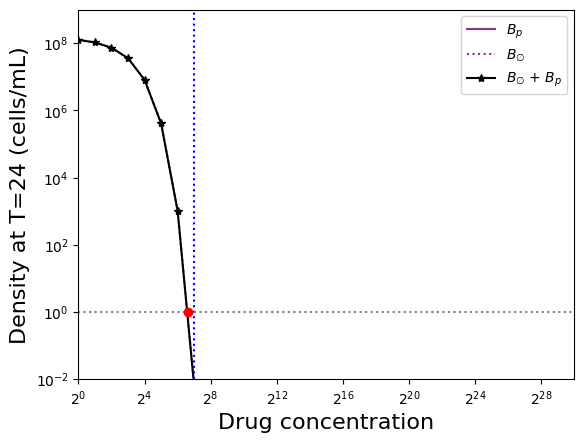

* best_kappa=0.0009765625
	*expe_MIC = 28672.0	model_MIC = 29136.036877238304	kappa = (0.25, 0.0009765625) -> 0.25*
	**expe_MIC = 28672.0	model_MIC = 114.10707974601127	kappa = (0.0009765625, 0.0009765625)


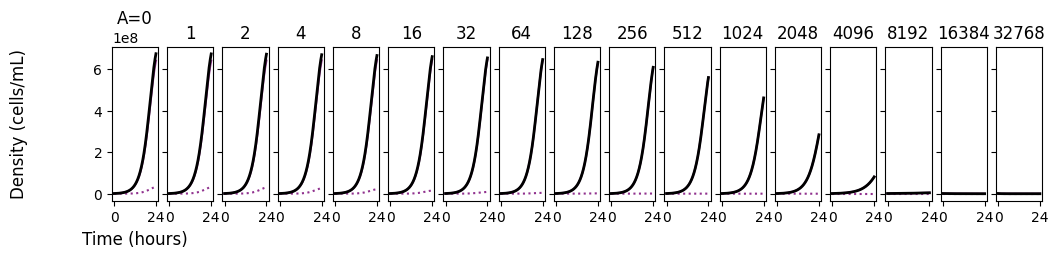

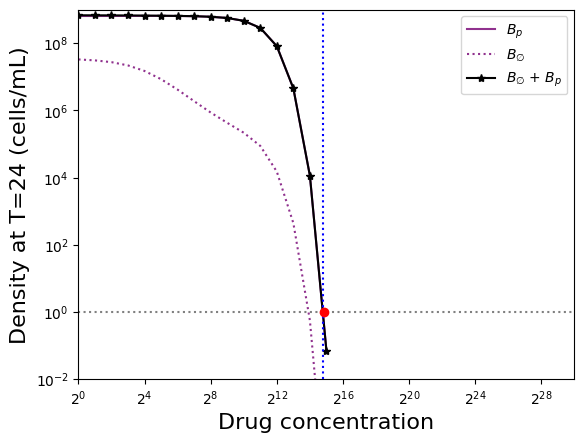

* best_kappa=0.25
Strain 28:
	*expe_MIC = 32.0	model_MIC = 3488.9347647959466	kappa = (1.0, 0.03125) -> 0.03125*
	*expe_MIC = 32.0	model_MIC = 27.257302384341063	kappa = (1.0, 0.000244140625) -> 0.000244140625*


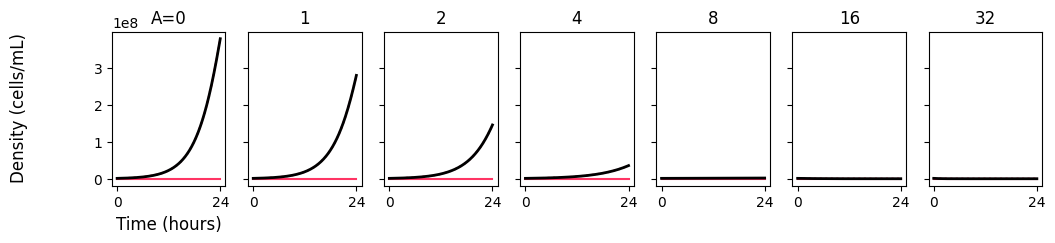

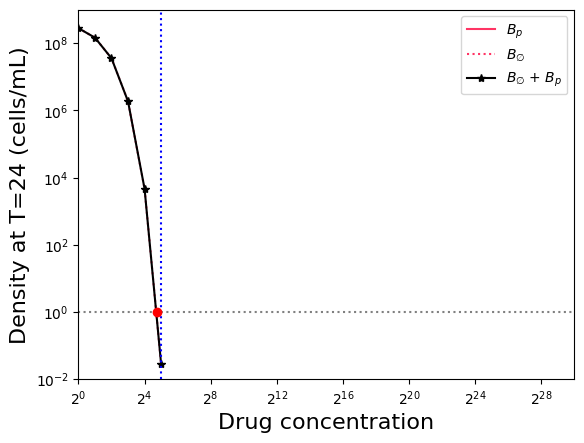

* best_kappa=0.000244140625
	*expe_MIC = 5120.0	model_MIC = 3536.7433759301257	kappa = (0.03125, 0.000244140625) -> 0.03125*
	**expe_MIC = 5120.0	model_MIC = 27.782585967779816	kappa = (0.000244140625, 0.000244140625)


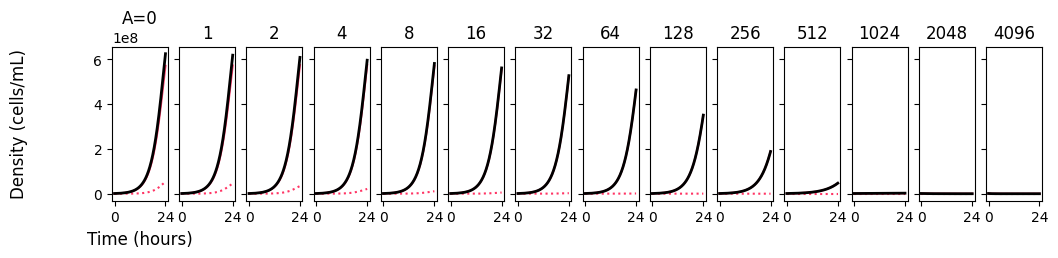

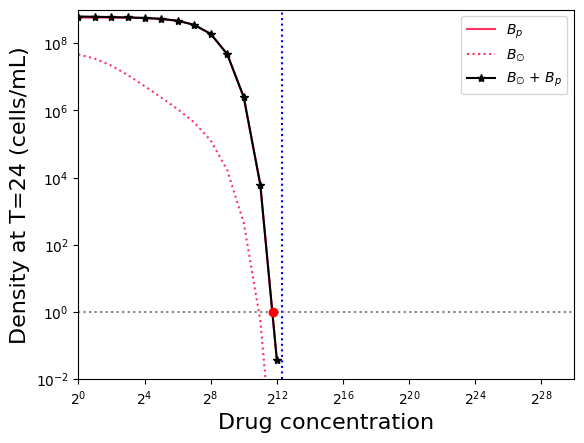

* best_kappa=0.03125
Strain 29:
	*expe_MIC = 128.0	model_MIC = 59602.54637614741	kappa = (1.0, 0.5) -> 0.5*
	*expe_MIC = 128.0	model_MIC = 116.41122261987144	kappa = (1.0, 0.0009765625) -> 0.0009765625*


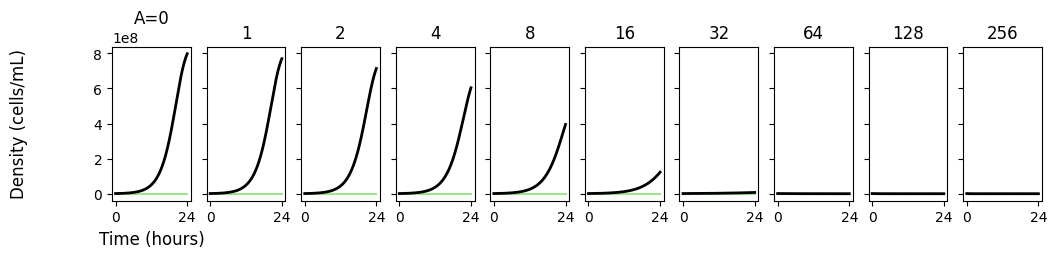

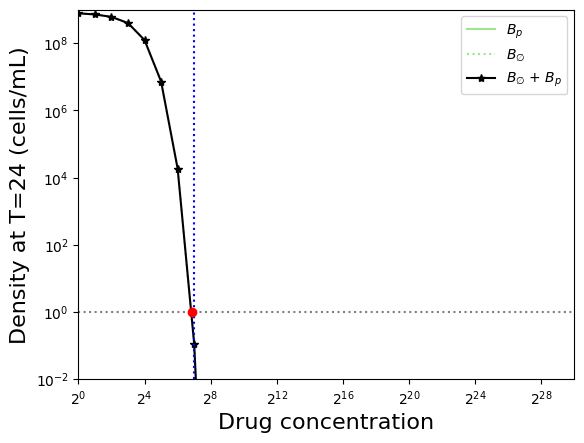

* best_kappa=0.0009765625
	*expe_MIC = 65536.0	model_MIC = 57470.904006605444	kappa = (0.5, 0.0009765625) -> 0.5*
	**expe_MIC = 65536.0	model_MIC = 112.67610767804852	kappa = (0.0009765625, 0.0009765625)


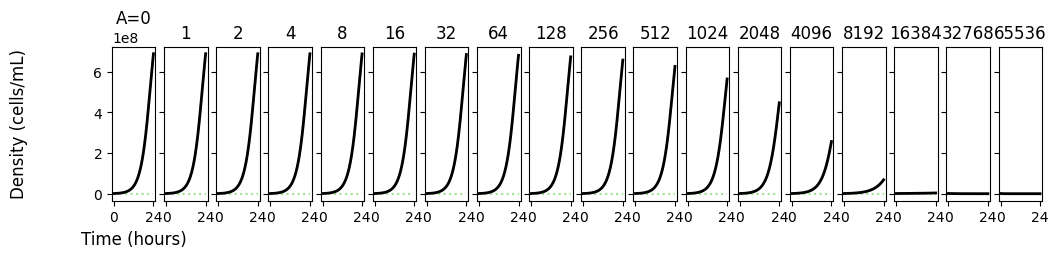

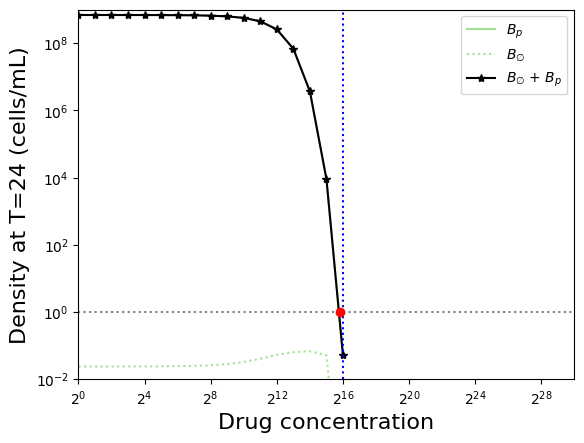

* best_kappa=0.5
Strain 30:
	*expe_MIC = 256.0	model_MIC = 26387.790065695634	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 256.0	model_MIC = 206.15460988824717	kappa = (1.0, 0.001953125) -> 0.001953125*


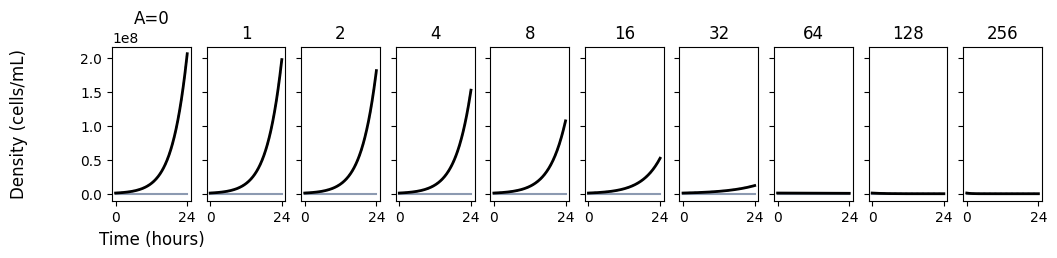

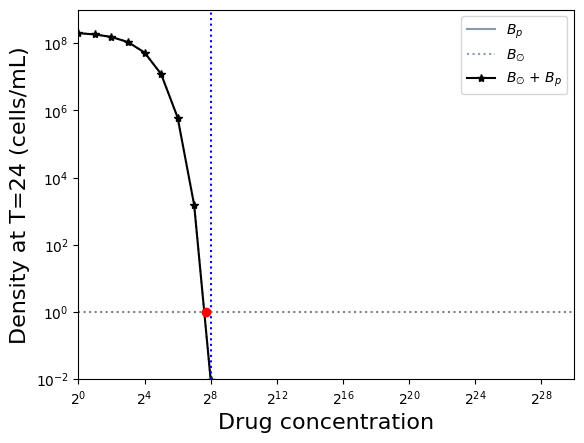

* best_kappa=0.001953125
	*expe_MIC = 32768.0	model_MIC = 27889.09553987323	kappa = (0.25, 0.001953125) -> 0.25*
	**expe_MIC = 32768.0	model_MIC = 218.70651033033207	kappa = (0.001953125, 0.001953125)


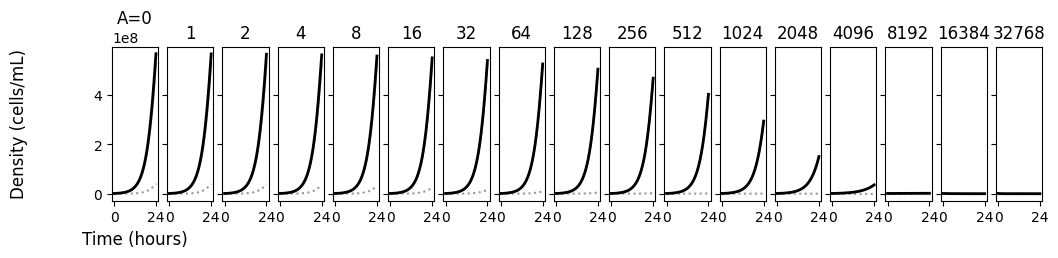

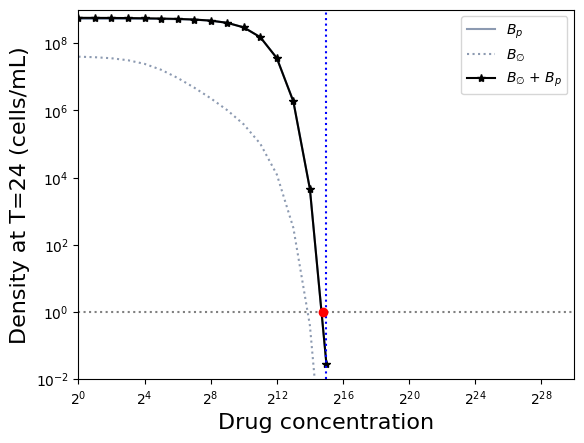

* best_kappa=0.25
Strain 31:
	*expe_MIC = 128.0	model_MIC = 24908.37131338473	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 128.0	model_MIC = 97.2983254429091	kappa = (1.0, 0.0009765625) -> 0.0009765625*


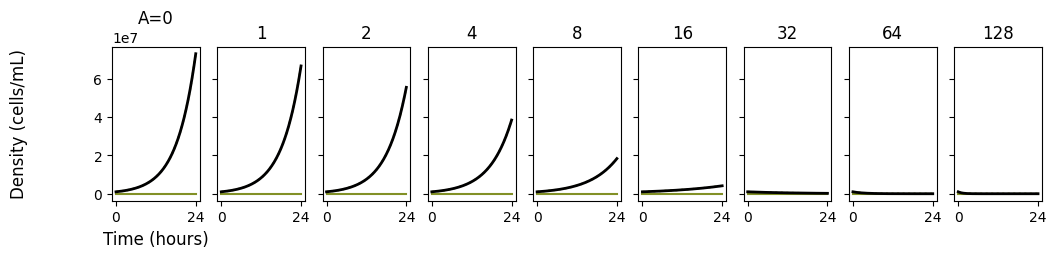

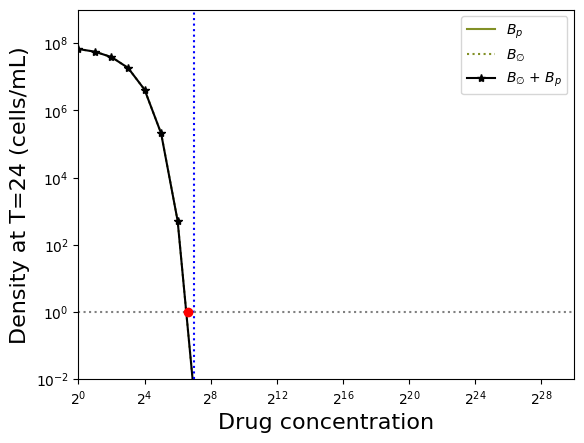

* best_kappa=0.0009765625
	*expe_MIC = 32768.0	model_MIC = 28323.398546695476	kappa = (0.25, 0.0009765625) -> 0.25*
	**expe_MIC = 32768.0	model_MIC = 110.90281464972648	kappa = (0.0009765625, 0.0009765625)


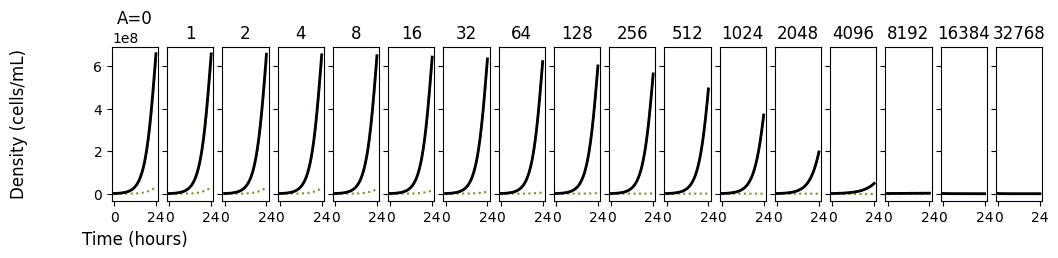

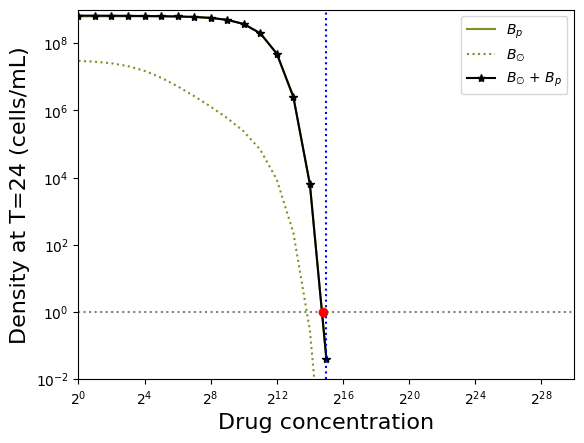

* best_kappa=0.25
Strain 32:
	*expe_MIC = 124.0	model_MIC = 25896.258210681633	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 124.0	model_MIC = 101.15725863547513	kappa = (1.0, 0.0009765625) -> 0.0009765625*


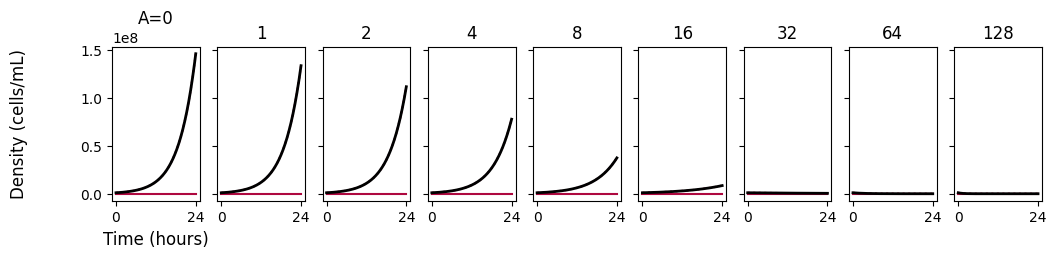

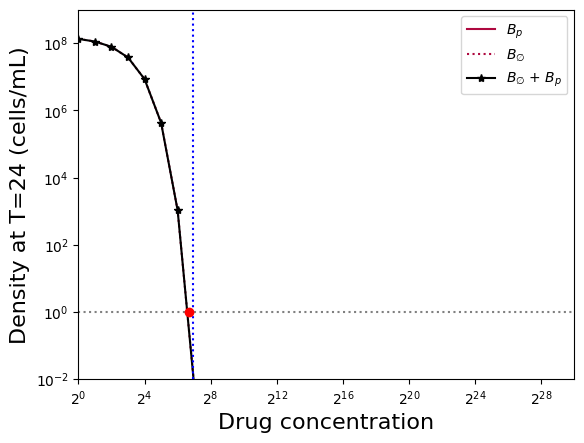

* best_kappa=0.0009765625
	*expe_MIC = 32768.0	model_MIC = 27144.939803316152	kappa = (0.25, 0.0009765625) -> 0.25*
	**expe_MIC = 32768.0	model_MIC = 106.44303866249683	kappa = (0.0009765625, 0.0009765625)


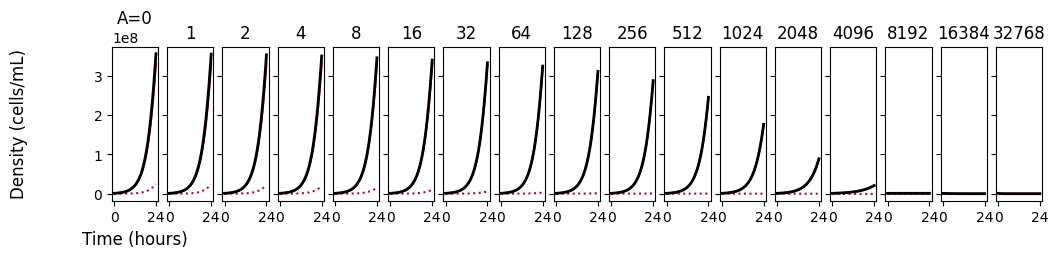

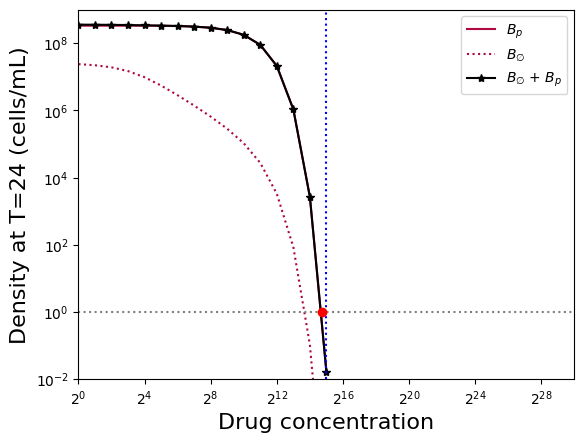

* best_kappa=0.25
Strain 33:
	*expe_MIC = 64.0	model_MIC = 6318.736324944564	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 64.0	model_MIC = 49.365113498137625	kappa = (1.0, 0.00048828125) -> 0.00048828125*


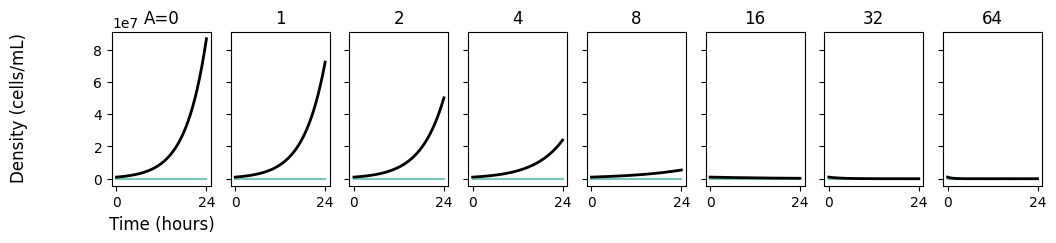

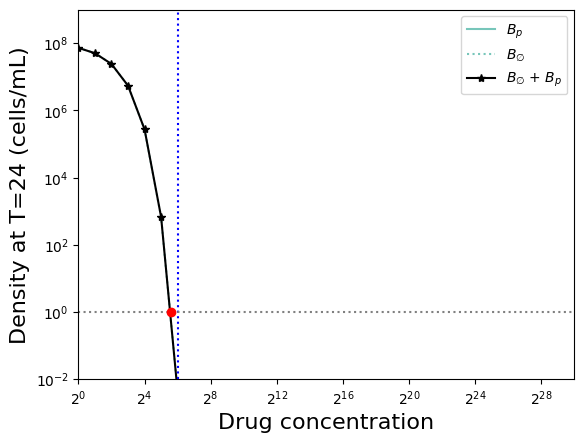

* best_kappa=0.00048828125
	*expe_MIC = 10240.0	model_MIC = 6972.415820062811	kappa = (0.0625, 0.00048828125) -> 0.0625*
	**expe_MIC = 10240.0	model_MIC = 54.624459616928945	kappa = (0.00048828125, 0.00048828125)


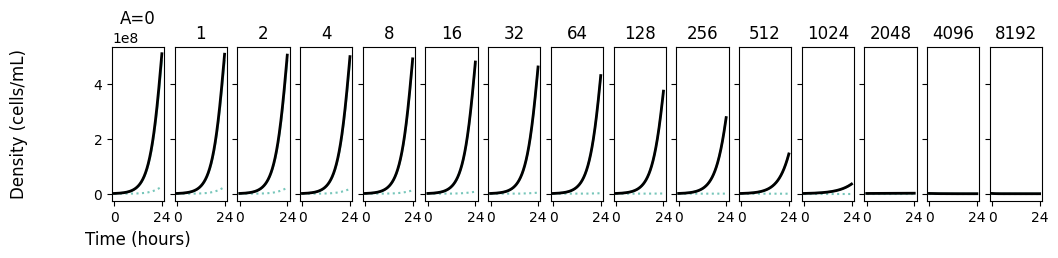

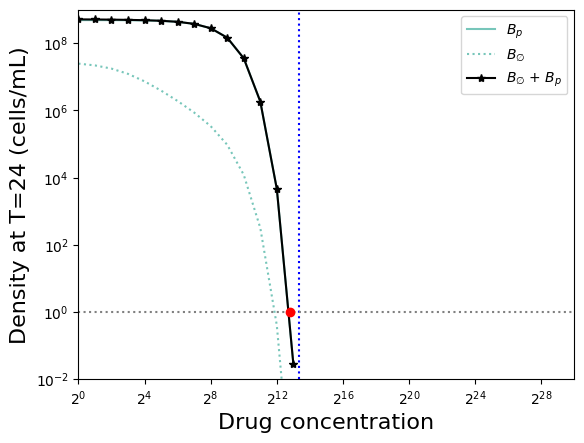

* best_kappa=0.0625
Strain 34:
	*expe_MIC = 128.0	model_MIC = 6745.308198742763	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 128.0	model_MIC = 105.39544060535567	kappa = (1.0, 0.0009765625) -> 0.0009765625*


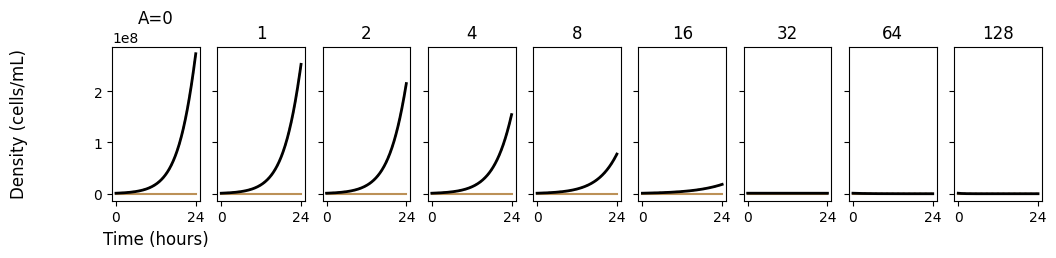

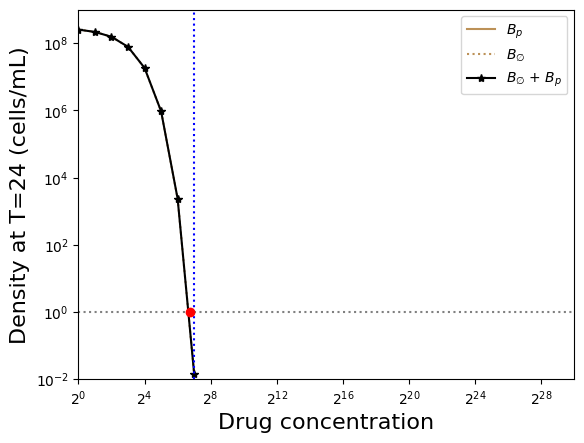

* best_kappa=0.0009765625
	*expe_MIC = 10240.0	model_MIC = 7189.90882202615	kappa = (0.0625, 0.0009765625) -> 0.0625*
	**expe_MIC = 10240.0	model_MIC = 112.63013361745547	kappa = (0.0009765625, 0.0009765625)


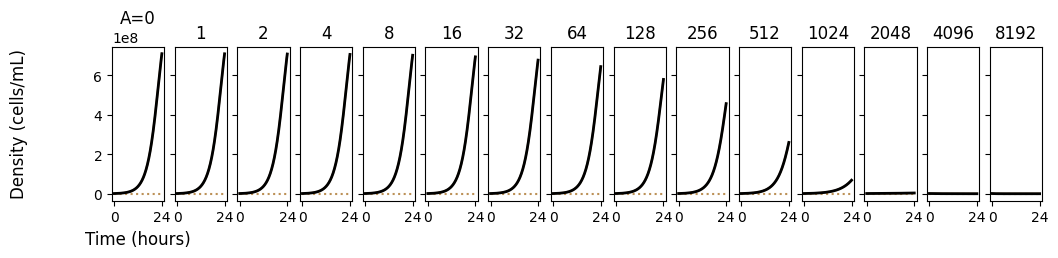

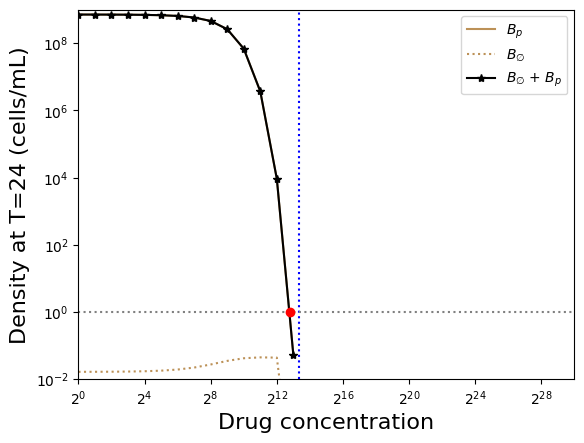

* best_kappa=0.0625
Strain 35:
	*expe_MIC = 128.0	model_MIC = 53965.31414787036	kappa = (1.0, 0.5) -> 0.5*
	*expe_MIC = 128.0	model_MIC = 105.40100424133976	kappa = (1.0, 0.0009765625) -> 0.0009765625*


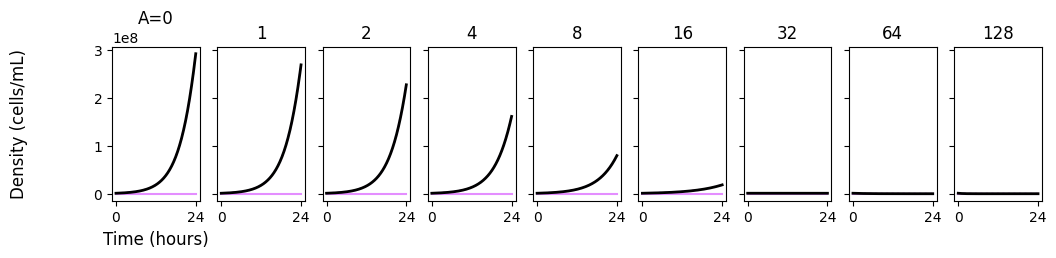

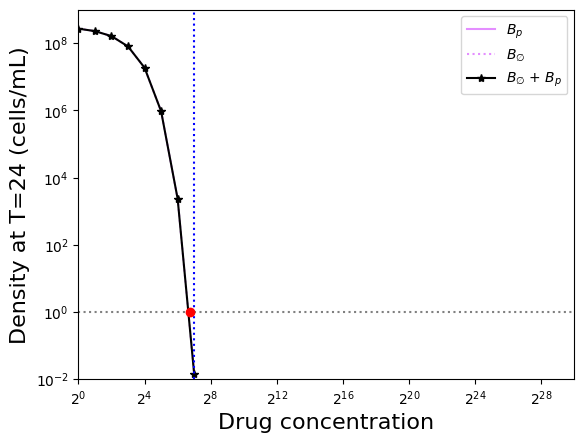

* best_kappa=0.0009765625
	*expe_MIC = 65536.0	model_MIC = 51941.84649617013	kappa = (0.5, 0.0009765625) -> 0.5*
	**expe_MIC = 65536.0	model_MIC = 102.21484407937886	kappa = (0.0009765625, 0.0009765625)


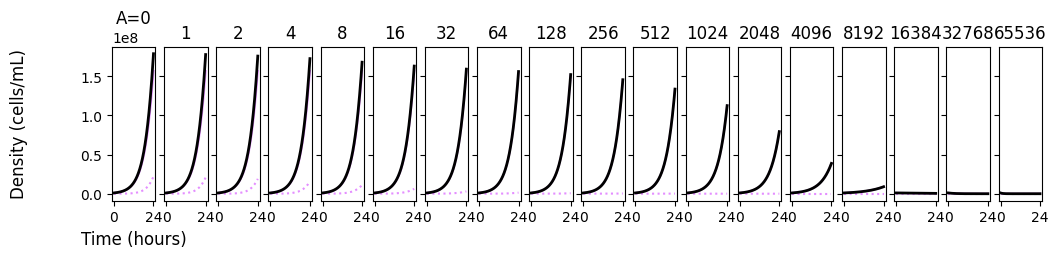

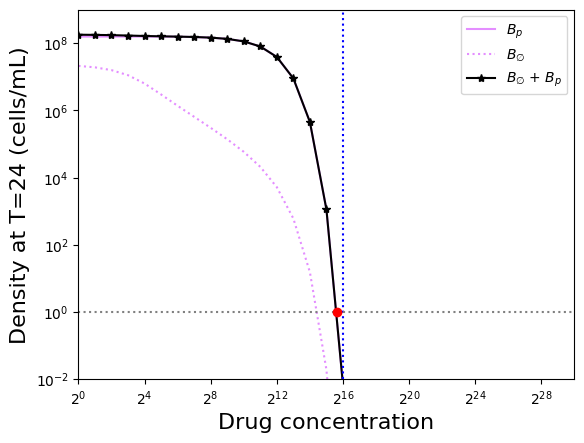

* best_kappa=0.5
Strain 36:
	*expe_MIC = 128.0	model_MIC = 13232.963570459106	kappa = (1.0, 0.125) -> 0.125*
	*expe_MIC = 128.0	model_MIC = 103.38251412100776	kappa = (1.0, 0.0009765625) -> 0.0009765625*


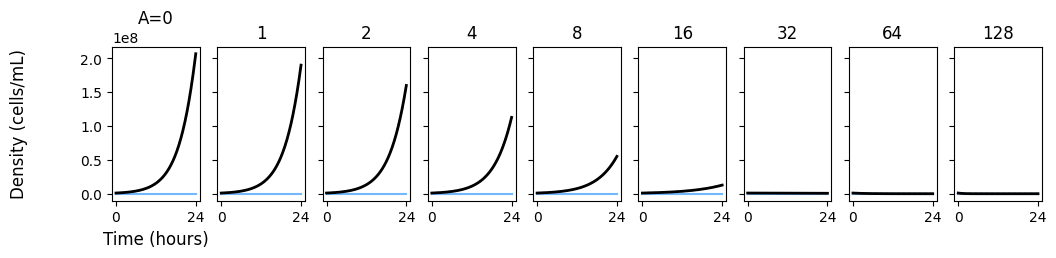

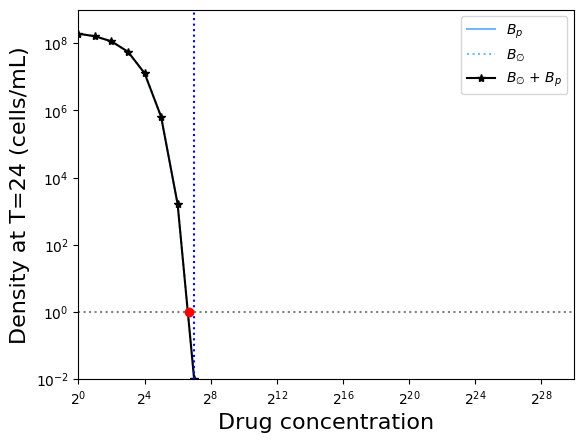

* best_kappa=0.0009765625
	*expe_MIC = 14336.0	model_MIC = 14319.384388975619	kappa = (0.125, 0.0009765625) -> 0.125*
	**expe_MIC = 14336.0	model_MIC = 112.23926536619007	kappa = (0.0009765625, 0.0009765625)


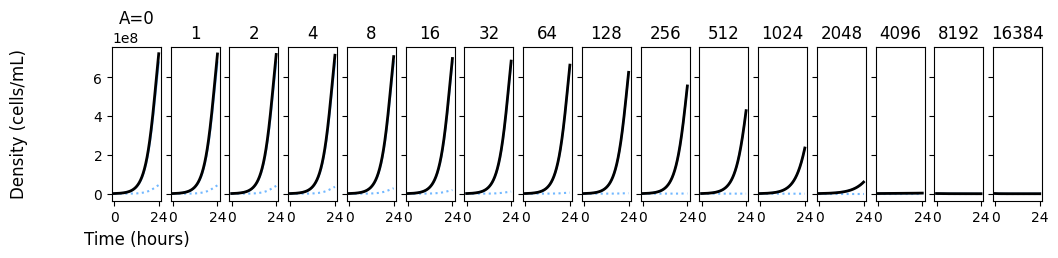

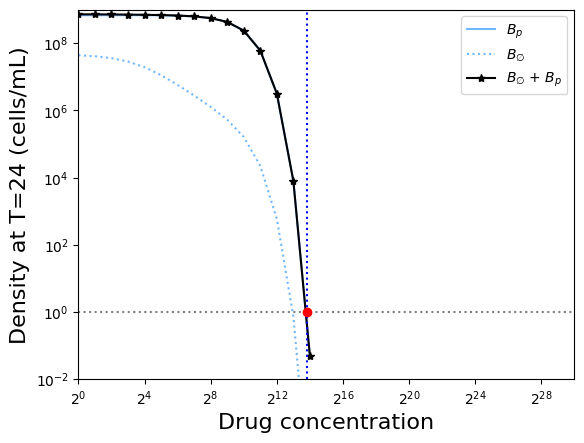

* best_kappa=0.125
Strain 37:
	*expe_MIC = 64.0	model_MIC = 53140.057845862895	kappa = (1.0, 0.5) -> 0.5*
	*expe_MIC = 64.0	model_MIC = 51.894587708373834	kappa = (1.0, 0.00048828125) -> 0.00048828125*


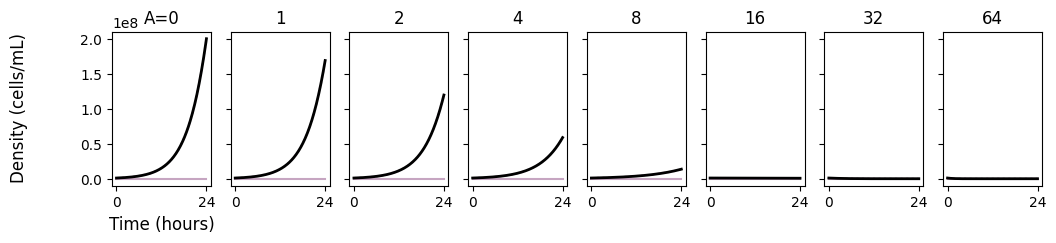

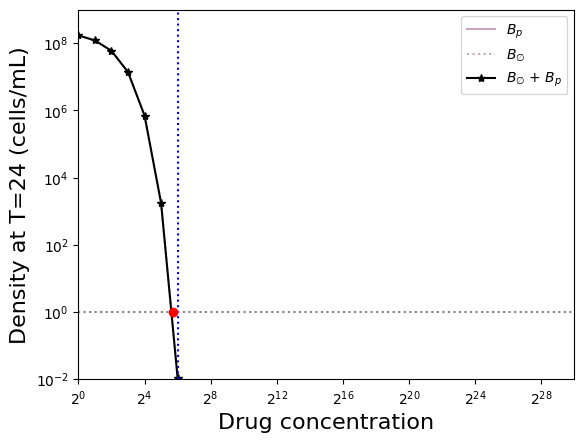

* best_kappa=0.00048828125
	*expe_MIC = 65536.0	model_MIC = 56874.842132399936	kappa = (0.5, 0.00048828125) -> 0.5*
	**expe_MIC = 65536.0	model_MIC = 55.81210724095959	kappa = (0.00048828125, 0.00048828125)


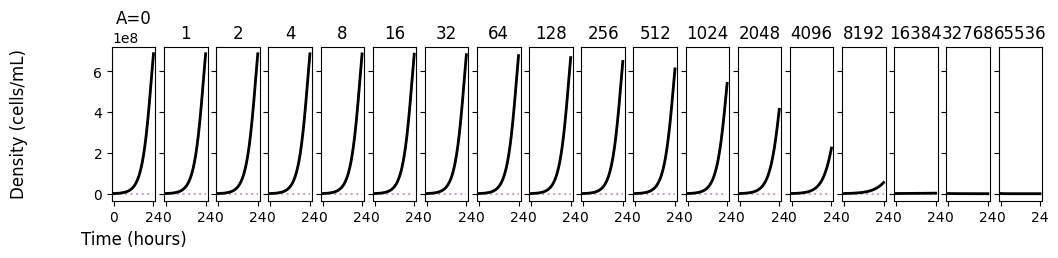

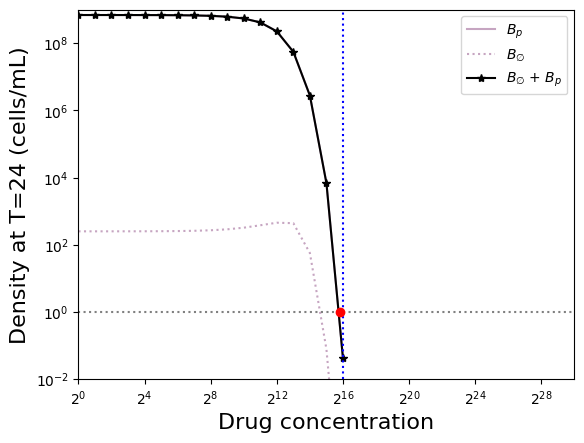

* best_kappa=0.5
Strain 38:
	*expe_MIC = 256.0	model_MIC = 54003.55195238981	kappa = (1.0, 0.5) -> 0.5*
	*expe_MIC = 256.0	model_MIC = 210.9513748140227	kappa = (1.0, 0.001953125) -> 0.001953125*


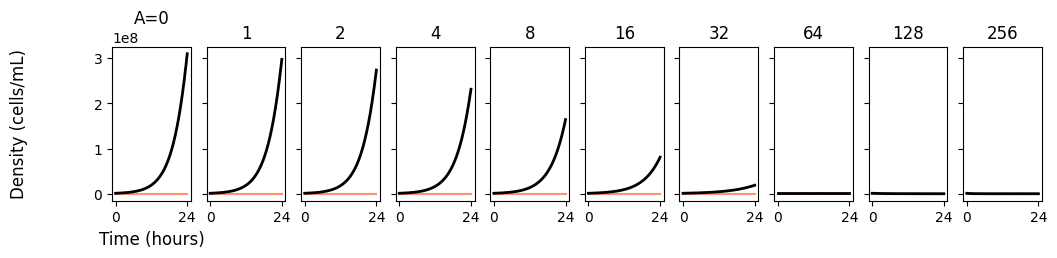

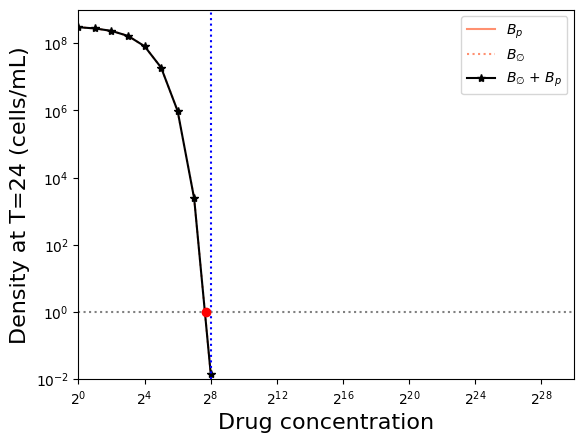

* best_kappa=0.001953125
	*expe_MIC = 65536.0	model_MIC = 54803.314456945656	kappa = (0.5, 0.001953125) -> 0.5*
	**expe_MIC = 65536.0	model_MIC = 214.61508152326127	kappa = (0.001953125, 0.001953125)


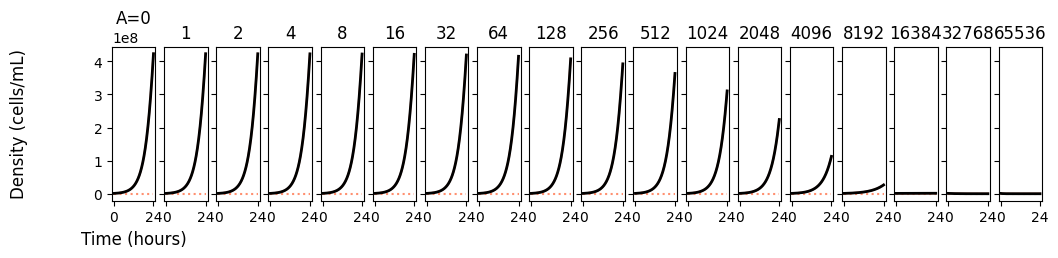

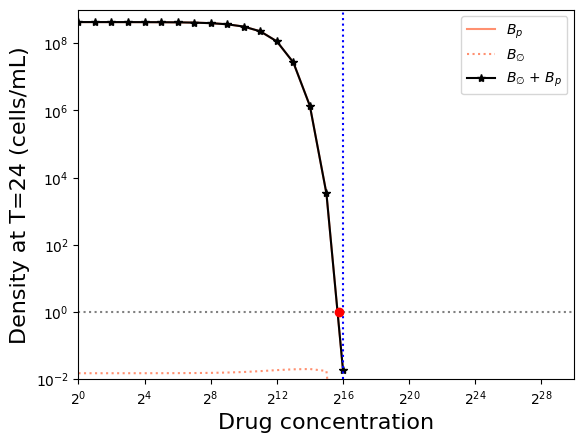

* best_kappa=0.5
Strain 39:
	*expe_MIC = 64.0	model_MIC = 26215.28447110515	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 64.0	model_MIC = 51.20172748262724	kappa = (1.0, 0.00048828125) -> 0.00048828125*


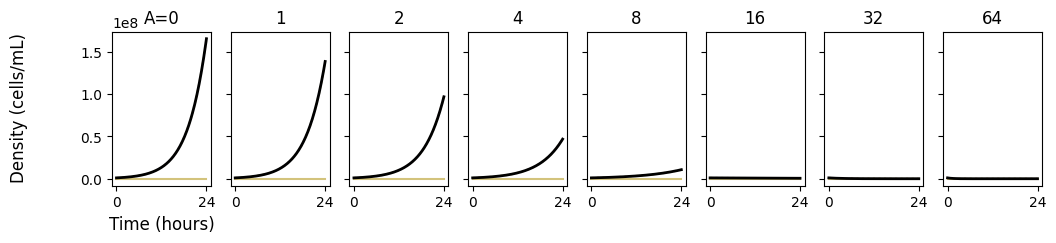

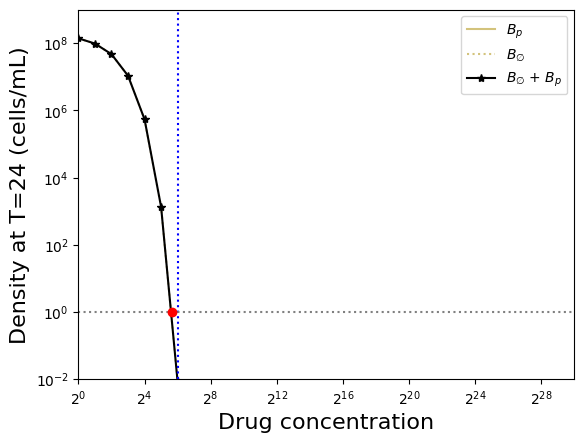

* best_kappa=0.00048828125
	*expe_MIC = 24576.0	model_MIC = 26884.81687761147	kappa = (0.25, 0.00048828125) -> 0.25*
	**expe_MIC = 24576.0	model_MIC = 52.64113044289185	kappa = (0.00048828125, 0.00048828125)


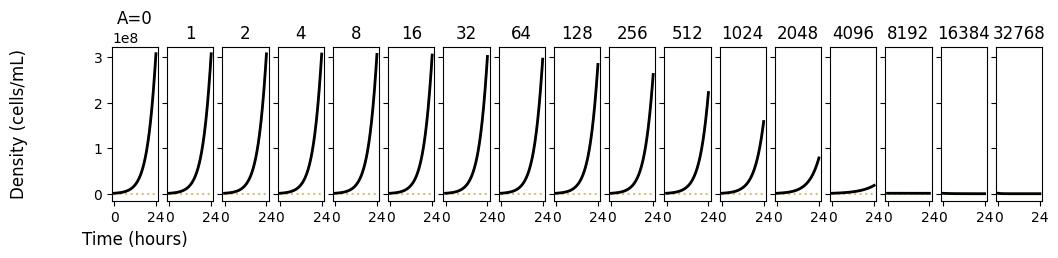

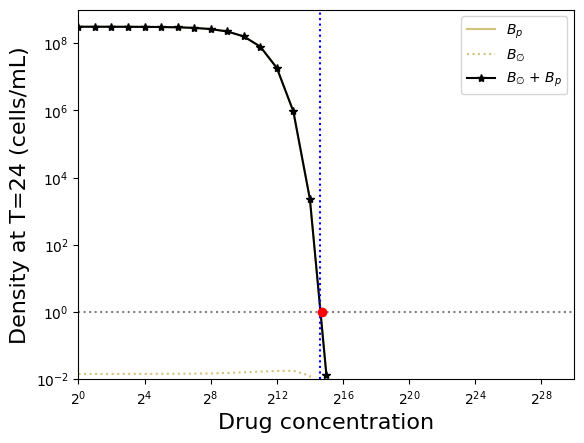

* best_kappa=0.25
Strain 40:
	*expe_MIC = 64.0	model_MIC = 846.9522143518826	kappa = (1.0, 0.0078125) -> 0.0078125*
	*expe_MIC = 64.0	model_MIC = 52.934514530431635	kappa = (1.0, 0.00048828125) -> 0.00048828125*


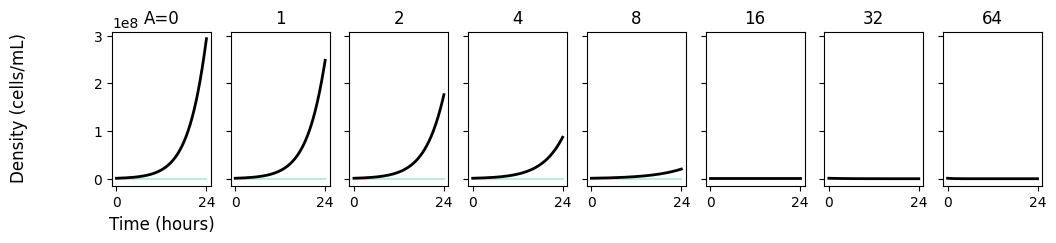

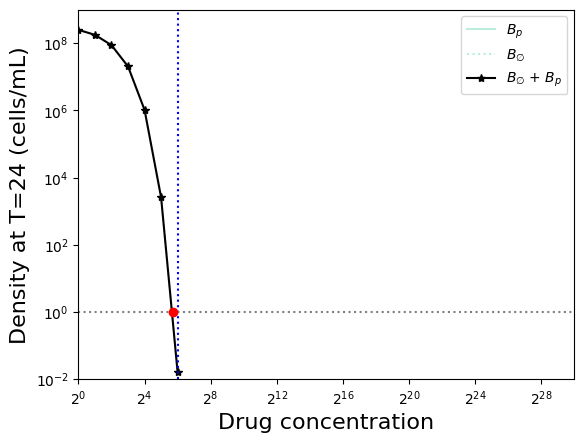

* best_kappa=0.00048828125
	*expe_MIC = 1024.0	model_MIC = 879.6403111546043	kappa = (0.0078125, 0.00048828125) -> 0.0078125*
	**expe_MIC = 1024.0	model_MIC = 55.21851778968799	kappa = (0.00048828125, 0.00048828125)


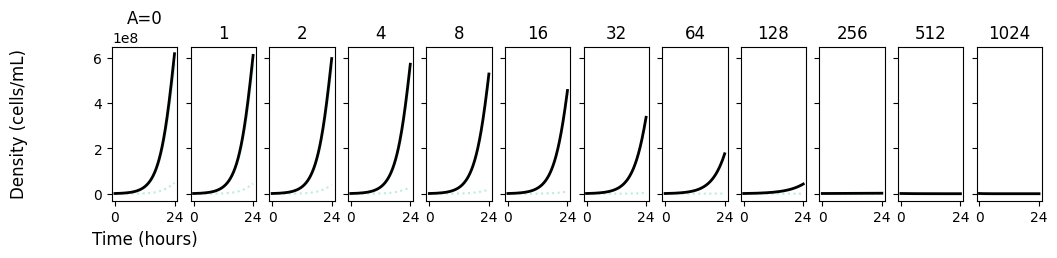

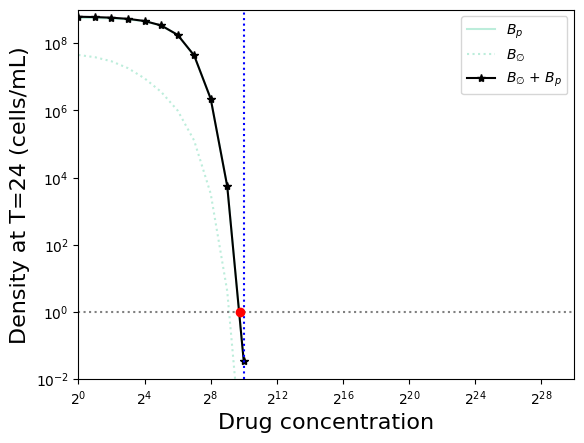

* best_kappa=0.0078125
Strain 41:
	*expe_MIC = 128.0	model_MIC = 13904.230483656695	kappa = (1.0, 0.125) -> 0.125*
	*expe_MIC = 128.0	model_MIC = 108.62679548193475	kappa = (1.0, 0.0009765625) -> 0.0009765625*


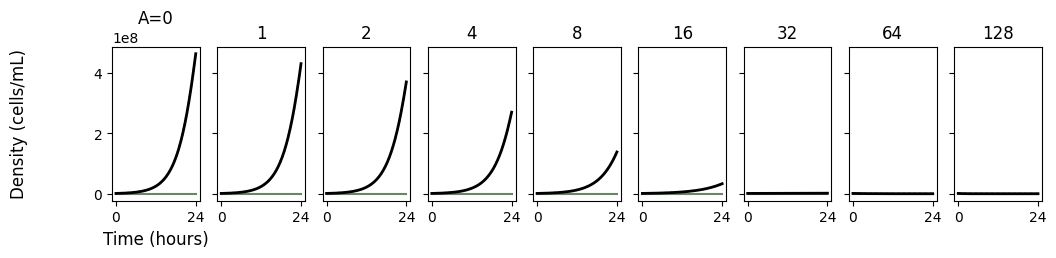

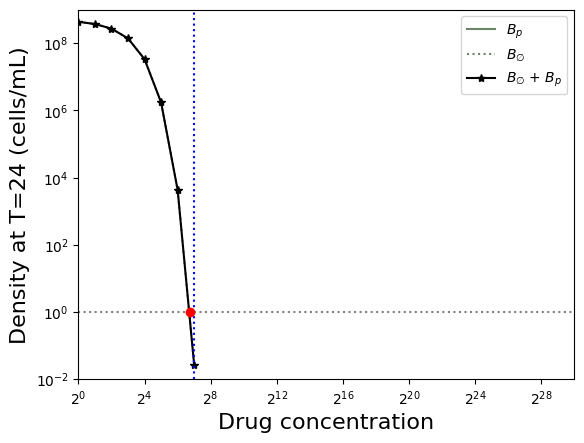

* best_kappa=0.0009765625
	*expe_MIC = 14336.0	model_MIC = 12838.08224820377	kappa = (0.125, 0.0009765625) -> 0.125*
	**expe_MIC = 14336.0	model_MIC = 100.56069316934405	kappa = (0.0009765625, 0.0009765625)


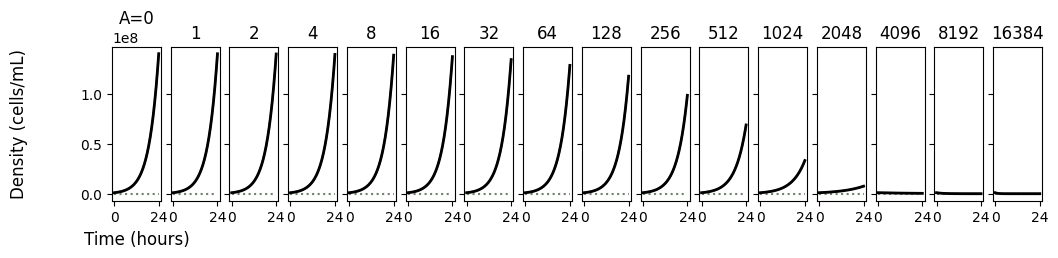

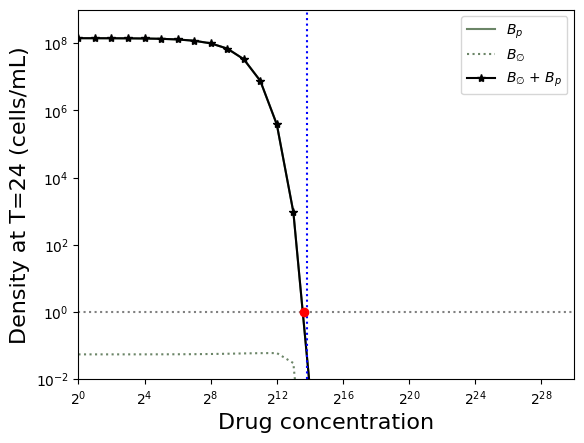

* best_kappa=0.125
Strain 42:
	*expe_MIC = 128.0	model_MIC = 26624.361695428117	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 128.0	model_MIC = 104.00142248874896	kappa = (1.0, 0.0009765625) -> 0.0009765625*


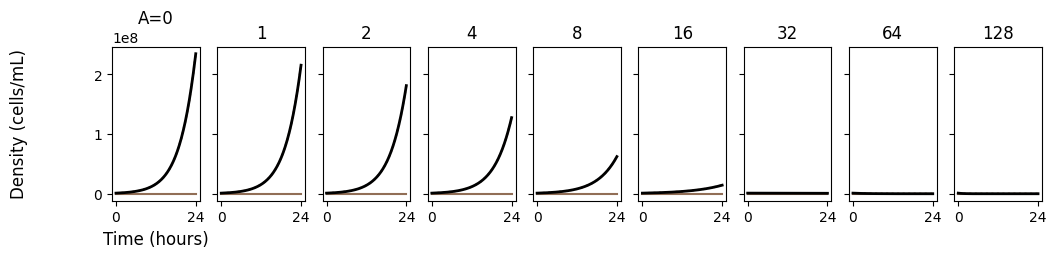

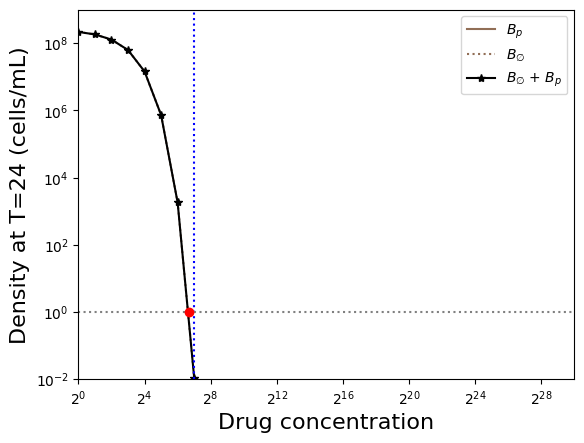

* best_kappa=0.0009765625
	*expe_MIC = 28672.0	model_MIC = 28674.378704426344	kappa = (0.25, 0.0009765625) -> 0.25*
	**expe_MIC = 28672.0	model_MIC = 112.39217469349852	kappa = (0.0009765625, 0.0009765625)


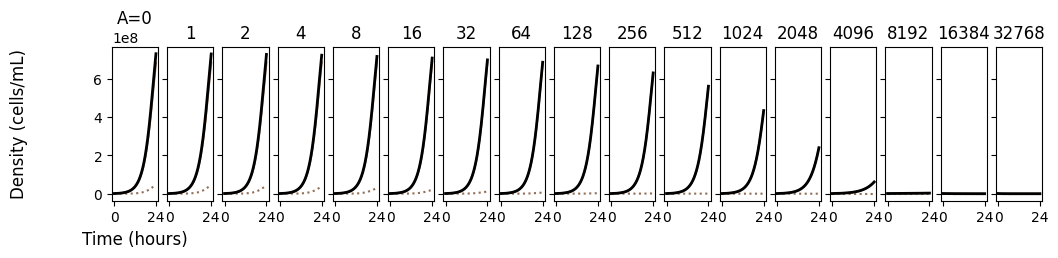

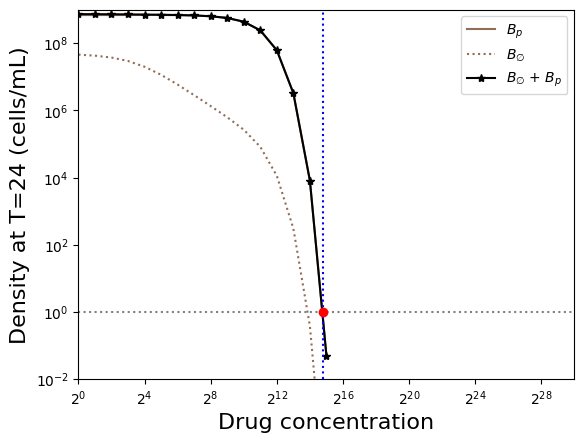

* best_kappa=0.25
Strain 43:
	*expe_MIC = 64.0	model_MIC = 54935.922731473394	kappa = (1.0, 0.5) -> 0.5*
	*expe_MIC = 64.0	model_MIC = 53.64836599701515	kappa = (1.0, 0.00048828125) -> 0.00048828125*


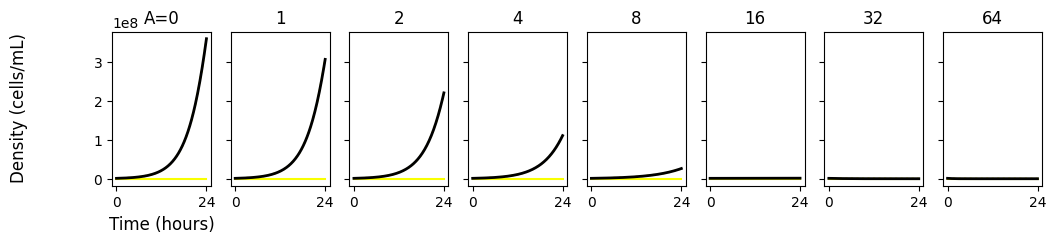

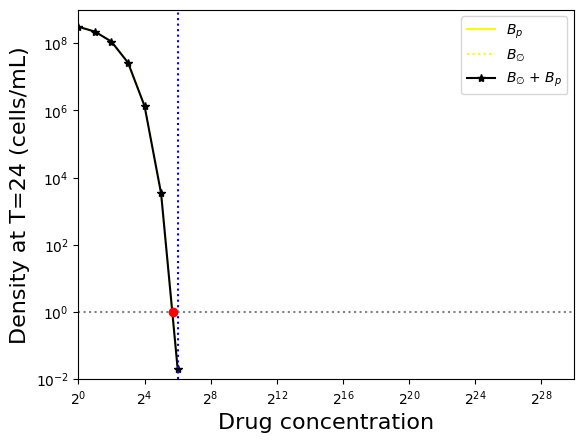

* best_kappa=0.00048828125
	*expe_MIC = 65536.0	model_MIC = 59352.78479955844	kappa = (0.5, 0.00048828125) -> 0.5*
	**expe_MIC = 65536.0	model_MIC = 58.188863487406664	kappa = (0.00048828125, 0.00048828125)


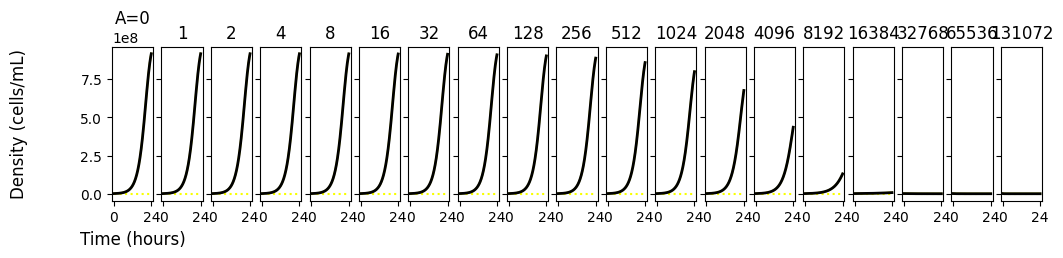

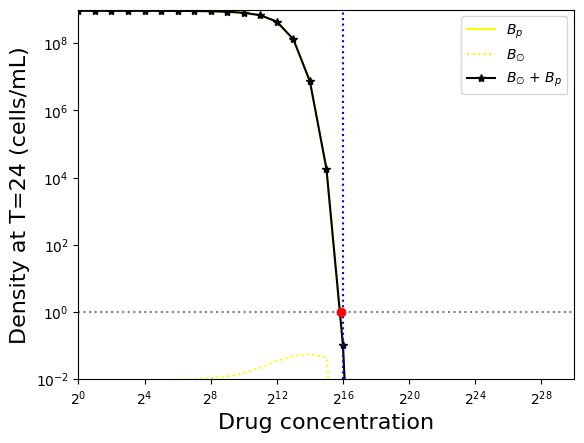

* best_kappa=0.5
Strain 44:
	*expe_MIC = 256.0	model_MIC = 27542.470846099717	kappa = (1.0, 0.25) -> 0.25*
	*expe_MIC = 256.0	model_MIC = 215.1755425254718	kappa = (1.0, 0.001953125) -> 0.001953125*


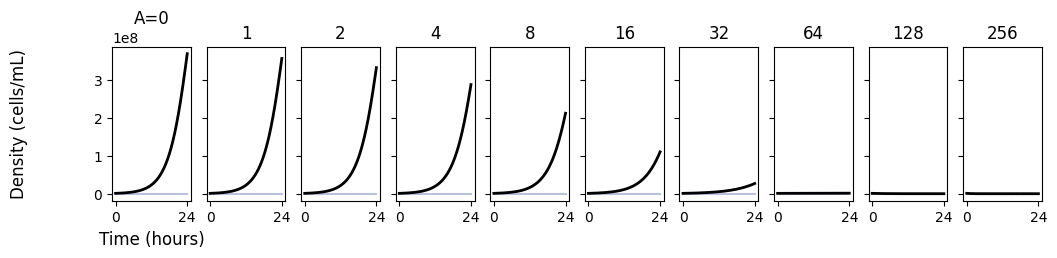

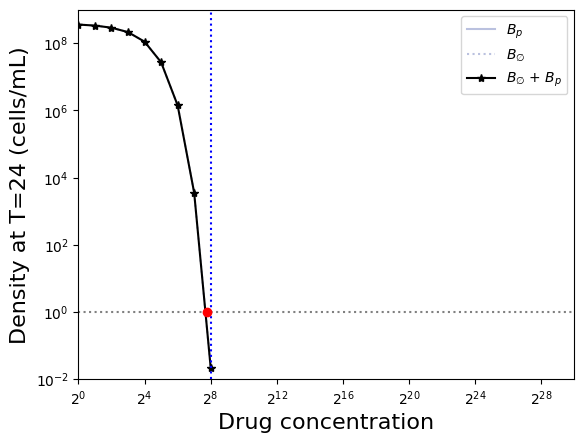

* best_kappa=0.001953125
	*expe_MIC = 32768.0	model_MIC = 27452.844351708838	kappa = (0.25, 0.001953125) -> 0.25*
	**expe_MIC = 32768.0	model_MIC = 215.78067436876955	kappa = (0.001953125, 0.001953125)


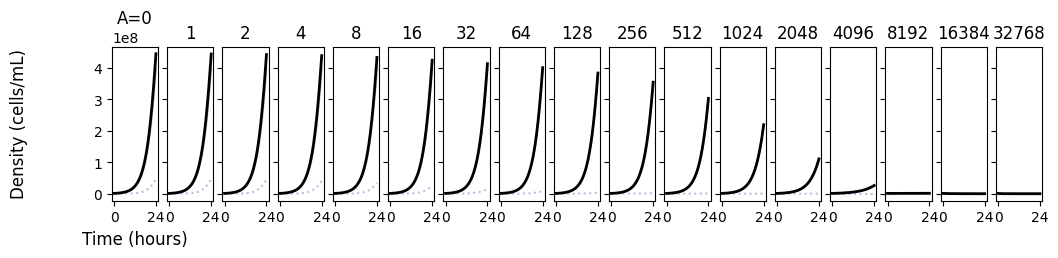

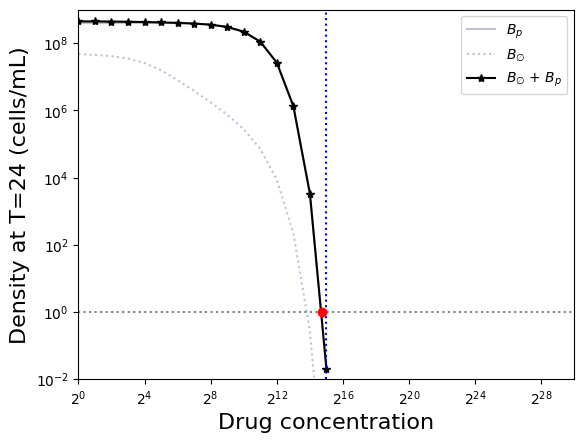

* best_kappa=0.25
Strain 45:
	*expe_MIC = 16.0	model_MIC = 822.6581100747819	kappa = (1.0, 0.0078125) -> 0.0078125*
	*expe_MIC = 16.0	model_MIC = 12.85403341966797	kappa = (1.0, 0.0001220703125) -> 0.0001220703125*


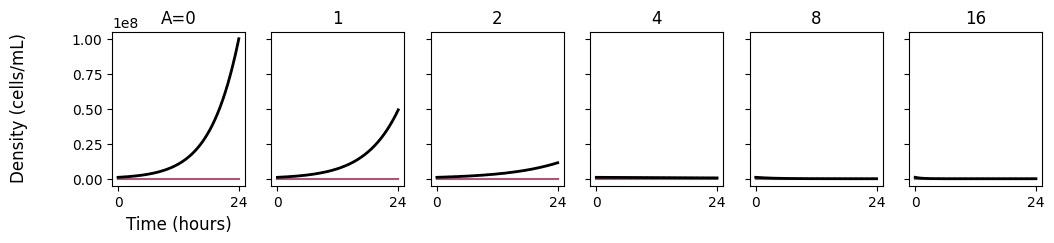

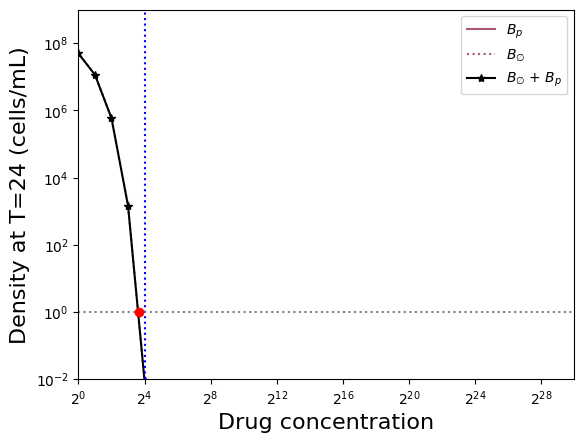

* best_kappa=0.0001220703125
	*expe_MIC = 1024.0	model_MIC = 832.4542973989222	kappa = (0.0078125, 0.0001220703125) -> 0.0078125*
	**expe_MIC = 1024.0	model_MIC = 13.060102623229573	kappa = (0.0001220703125, 0.0001220703125)


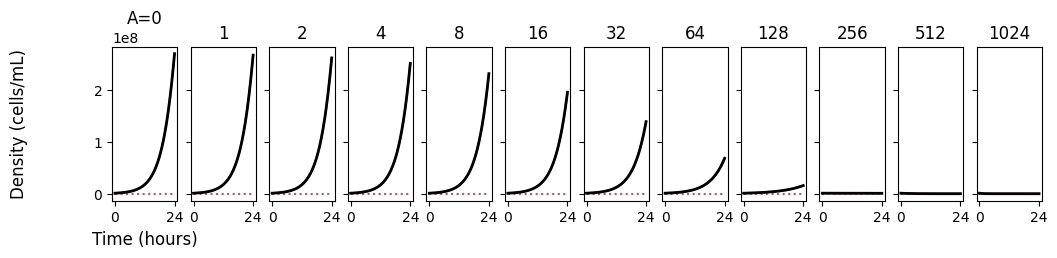

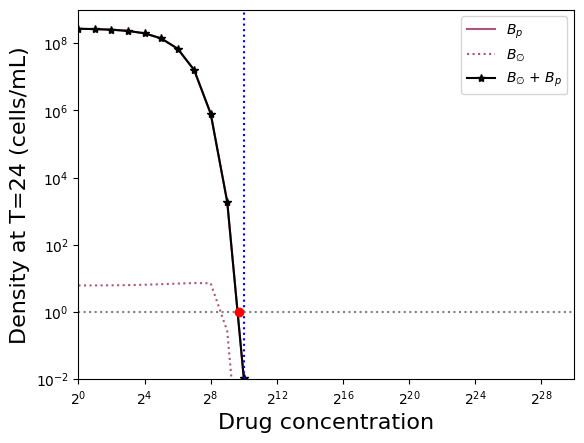

* best_kappa=0.0078125
Strain 46:
	*expe_MIC = 64.0	model_MIC = 6494.57066333595	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 64.0	model_MIC = 50.738820612853935	kappa = (1.0, 0.00048828125) -> 0.00048828125*


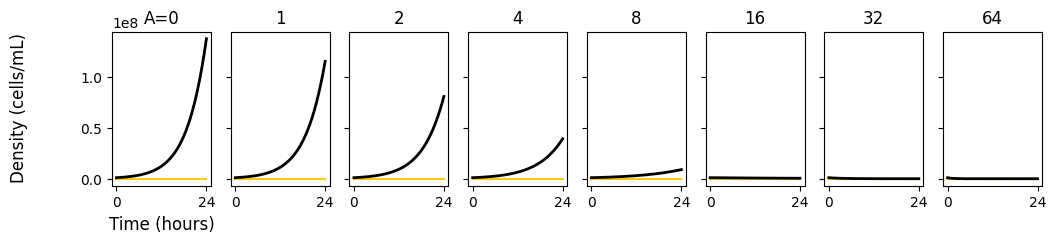

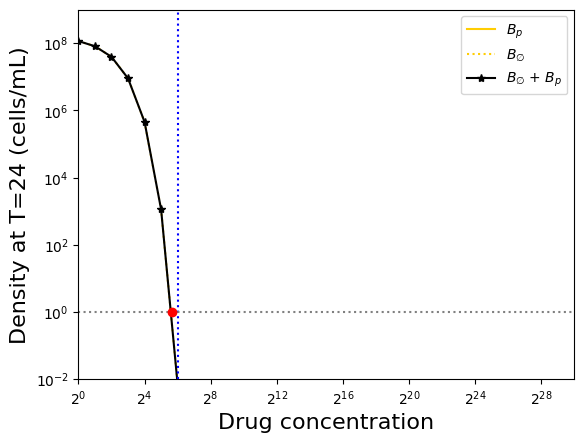

* best_kappa=0.00048828125
	*expe_MIC = 10240.0	model_MIC = 7198.0270832869855	kappa = (0.0625, 0.00048828125) -> 0.0625*
	**expe_MIC = 10240.0	model_MIC = 56.39390666133522	kappa = (0.00048828125, 0.00048828125)


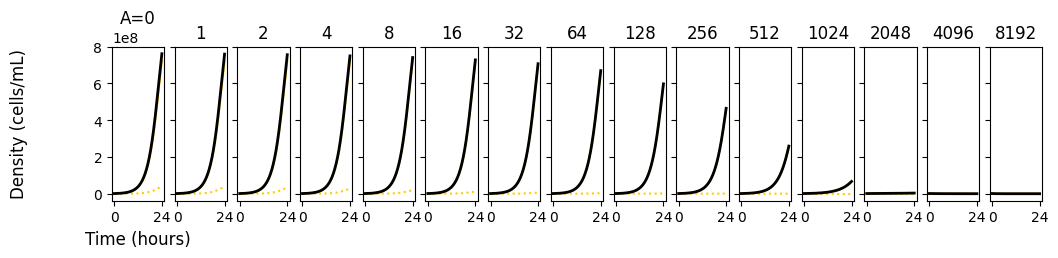

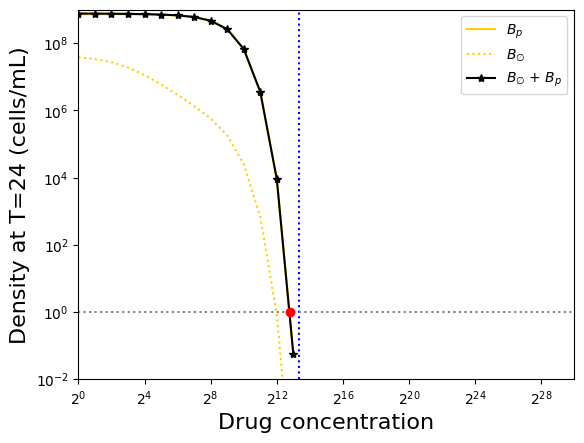

* best_kappa=0.0625
Strain 47:
	*expe_MIC = 256.0	model_MIC = 14117.392371279924	kappa = (1.0, 0.125) -> 0.125*
	*expe_MIC = 256.0	model_MIC = 220.58426014496445	kappa = (1.0, 0.001953125) -> 0.001953125*


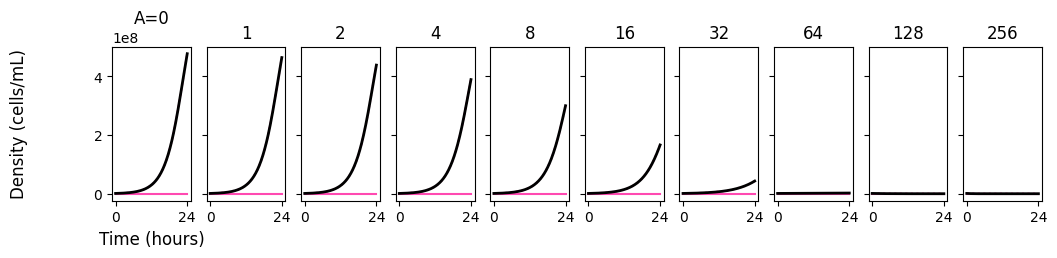

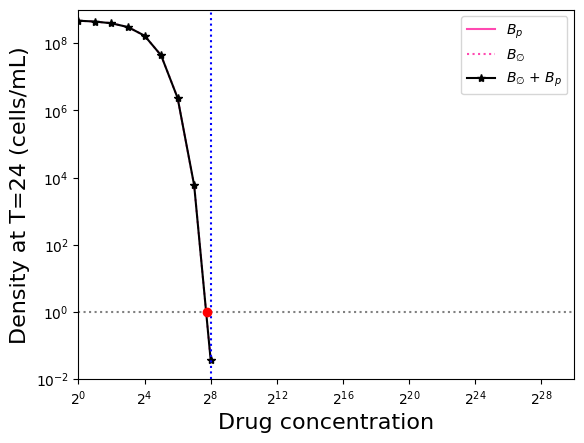

* best_kappa=0.001953125
	*expe_MIC = 14336.0	model_MIC = 13281.704283689454	kappa = (0.125, 0.001953125) -> 0.125*
	**expe_MIC = 14336.0	model_MIC = 209.66179136025687	kappa = (0.001953125, 0.001953125)


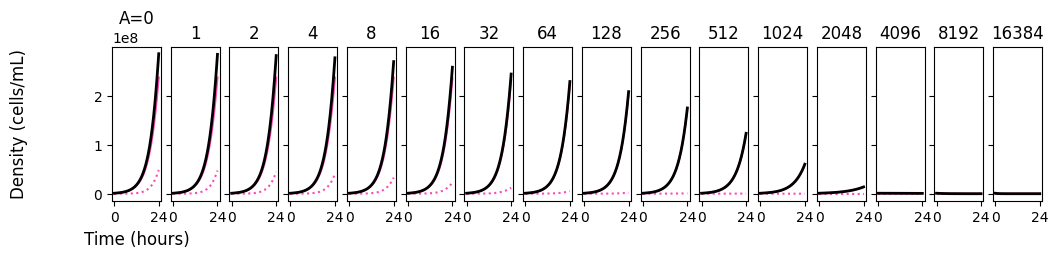

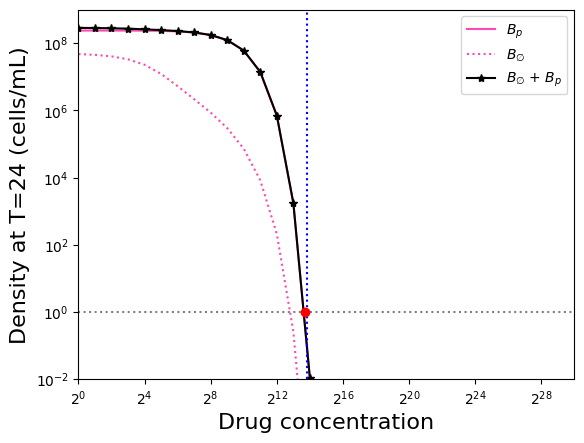

* best_kappa=0.125
Strain 48:
	*expe_MIC = 128.0	model_MIC = 6636.126999340911	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 128.0	model_MIC = 103.68948436470174	kappa = (1.0, 0.0009765625) -> 0.0009765625*


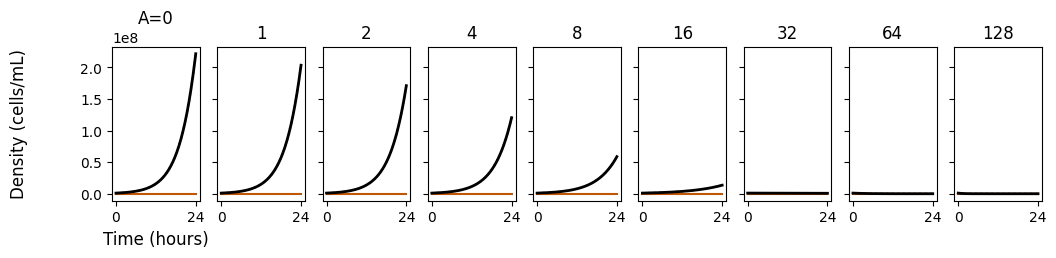

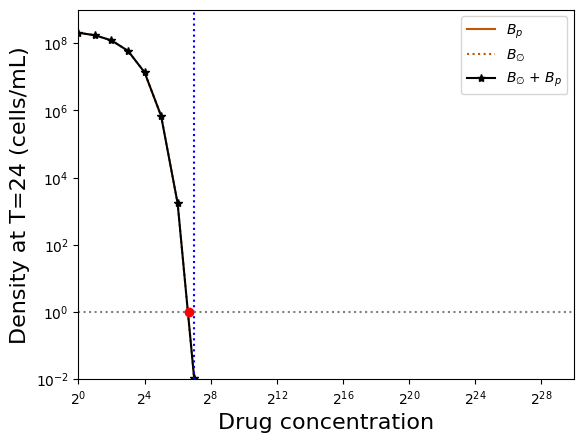

* best_kappa=0.0009765625
	*expe_MIC = 8192.0	model_MIC = 7281.272771050946	kappa = (0.0625, 0.0009765625) -> 0.0625*
	**expe_MIC = 8192.0	model_MIC = 114.11784089768736	kappa = (0.0009765625, 0.0009765625)


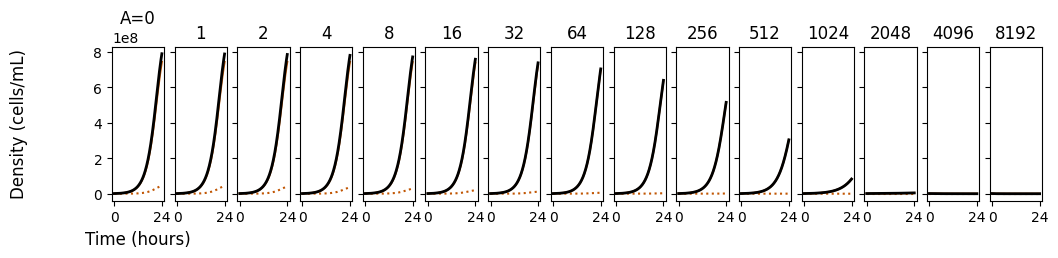

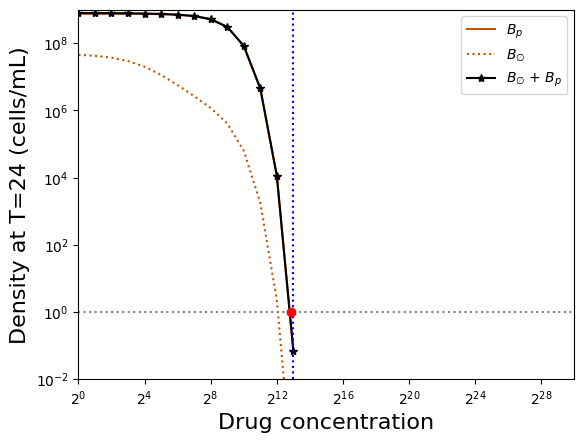

* best_kappa=0.0625
Strain 49:
	*expe_MIC = 32.0	model_MIC = 6442.012547368651	kappa = (1.0, 0.0625) -> 0.0625*
	*expe_MIC = 32.0	model_MIC = 25.164107621756237	kappa = (1.0, 0.000244140625) -> 0.000244140625*


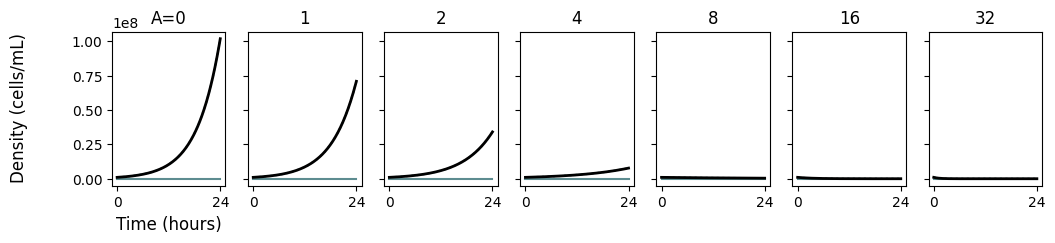

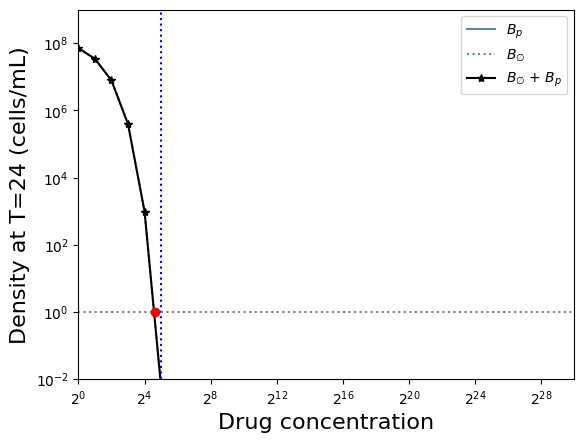

* best_kappa=0.000244140625
	*expe_MIC = 8192.0	model_MIC = 6964.820294526347	kappa = (0.0625, 0.000244140625) -> 0.0625*
	**expe_MIC = 8192.0	model_MIC = 27.293360521782652	kappa = (0.000244140625, 0.000244140625)


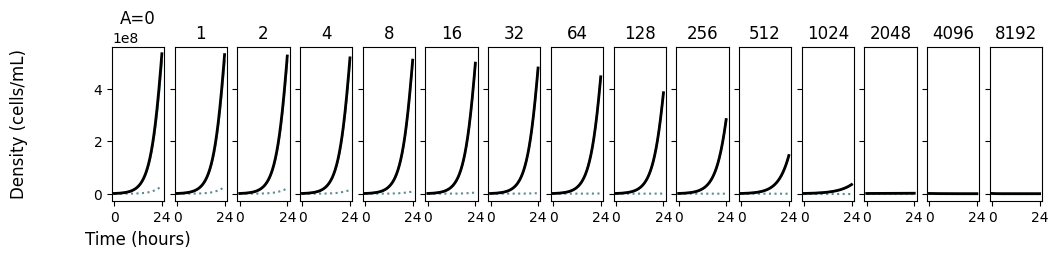

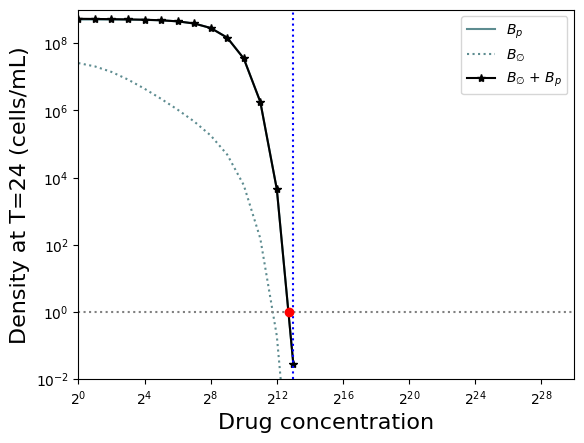

* best_kappa=0.0625


In [51]:
toPlot=True
toFit=False


for this_istrain in np.arange(0,tot_strains): #[6]: #np.arange(0,tot_strains): #strains_subset: #np.arange(0,tot_strains) #strains_subset
  print("Strain %s:"%this_istrain)
  #Perform data fitting
  if toFit:
    powers = np.arange(0.0,30.0)  # array of powers of two exponents
    kappas=1.0 / np.power(2.0, powers)
    #print(kappas)

    best_kappas=fit_kappa(kappas, this_istrain, toPlot)

    assign_strain_kappa(model_params, best_kappas, [this_istrain])
    export_model_params(model_params, "%smodel_params.csv"%(dataPath))
  else:

    powers = np.arange(0.,30.0)  # array of powers of two exponents
    kappas=[model_params['kappa'][this_istrain], model_params['kappa'][this_istrain+tot_strains]]
    fit_kappa(kappas, this_istrain, toPlot)


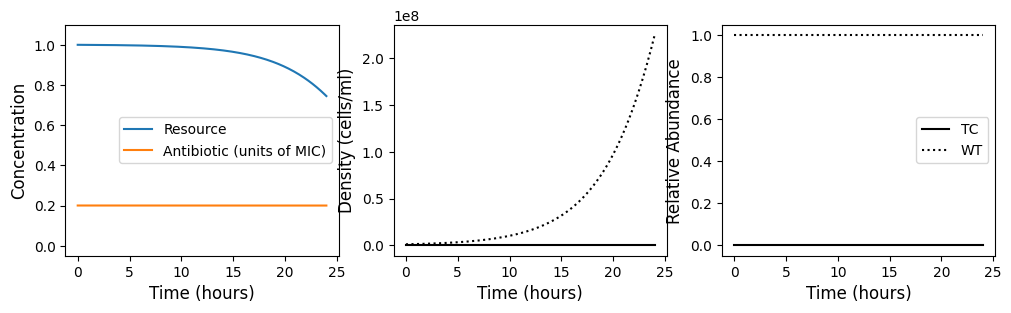

In [52]:
# Run the simulation
A=0.2 #Environmental drug concentration
y0 = np.concatenate(([S0],[A], [0, B0]))
times, ys = simulate_model(model_params, y0)
plot_simulation(times, ys)

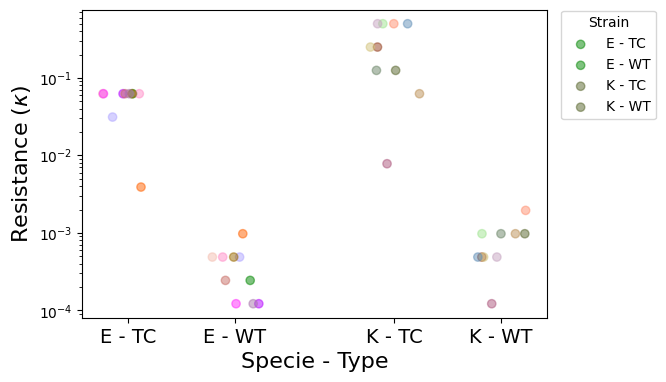

In [53]:
def plot_kappa_scatter(model_params, istrains):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(model_params)

    # Filter DataFrame based on istrains and istrains+tot_strains
    df = df[df.index.isin(np.concatenate([istrains, [i + tot_strains for i in istrains]]))]



    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(6, 4))

    # Define the positions for scatter points
    positions = [0.8, 1.2, 1.8, 2.2]

    # Filter data for each combination of 'specie' and 'type' and plot scatter points
    species = ['E', 'K']
    types = ['TC', 'WT']

    for i, specie in enumerate(species):
        for j, type_ in enumerate(types):
            specie_type_data = df[(df['specie'] == specie) & (df['type'] == type_)]

            # Calculate the jitter for scatter points
            jitter = np.random.uniform(low=-0.1, high=0.1, size=len(specie_type_data))

            # Calculate the x-position for scatter points
            x = positions[i * len(types) + j] + jitter

            # Set the color and alpha based on 'specie' and 'type'
            color = specie_type_data['strain_color']
            alpha = 0.5 if type_ == 'WT' else 0.5

            # Plot the scatter points with y-axis in log2 scale
            ax.scatter(x, specie_type_data['kappa'], label=f'{specie} - {type_}', color=color, alpha=alpha)

    ax.set_xticks(positions)
    ax.set_xticklabels([f'{specie} - {type_}' for specie in species for type_ in types], fontsize=14)
    ax.set_xlabel('Specie - Type', fontsize=16)
    ax.set_ylabel(r'Resistance ($\kappa$)', fontsize=16)

    # Set the y-axis to log2 scale
    ax.set_yscale('log')
    #ax.set_ylim([0,60000])
    #ax.tick_params(axis='y', labelsize=16)
    #ax.yaxis.set_major_locator(LogLocator(base=2))
    #ax.yaxis.set_minor_locator(LogLocator(base=2, subs=np.arange(0.1, 1.0, 0.1), numticks=10))

    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02), title='Strain')

    # Show the plot
    plt.show()

plot_kappa_scatter(model_params, strains_subset)

In [54]:

def display_model_params(model_params):
    table = []
    num_strains=int(len(model_params['specie'])/2)
    for i in range(num_strains): #Plasmid-Free (TC)
        name = model_params['strain_name'][i]
        color = model_params['strain_color'][i]
        specie = model_params['specie'][i]
        strain = model_params['strain'][i]
        ptype = model_params['type'][i]
        pcn = model_params['PCN'][i]
        mic = model_params['MIC'][i]
        conj = model_params['conj_rate'][i]
        VKm = model_params['VKm'][i]
        rho = model_params['rho'][i]
        seg = model_params['seg_rate'][i]
        kappa = model_params['kappa'][i]
        row = [f"{i+1}", name, color, specie, strain, ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    for i in range(num_strains): #Plasmid-bearing (WT)
        name = model_params['strain_name'][i+num_strains]
        color = model_params['strain_color'][i+num_strains]
        specie = model_params['specie'][i+num_strains]
        strain = model_params['strain'][i+num_strains]
        ptype = model_params['type'][i+num_strains]
        pcn = model_params['PCN'][i+num_strains]
        mic = model_params['MIC'][i+num_strains]
        conj = model_params['conj_rate'][i+num_strains]
        VKm = model_params['VKm'][i+num_strains]
        rho = model_params['rho'][i+num_strains]
        seg = model_params['seg_rate'][i+num_strains]
        kappa = model_params['kappa'][i+num_strains]
        row = [f"{num_strains+i+1}", name, color, specie, strain, ptype, pcn, mic, conj, VKm, rho, seg, kappa]
        table.append(row)

    headers = ["", "name", "color","specie", "strain", "type", "PCN", "MIC", "conj_rate", "VKm", "rho", "seg_rate",  "kappa"]
    print(tabulate(table, headers, tablefmt="fancy_grid"))


display_model_params(model_params)

╒═════╤══════════╤═════════╤══════════╤══════════╤════════╤══════════╤═══════╤══════════════╤══════════╤═════════════╤════════════╤═════════════╕
│     │ name     │ color   │ specie   │ strain   │ type   │      PCN │   MIC │    conj_rate │      VKm │         rho │   seg_rate │       kappa │
╞═════╪══════════╪═════════╪══════════╪══════════╪════════╪══════════╪═══════╪══════════════╪══════════╪═════════════╪════════════╪═════════════╡
│   1 │ PF_EC01  │ #d60000 │ E        │ C001     │ TC     │   1.41   │    64 │ nan          │ 4.9e-10  │ 9.8441e+08  │       0.02 │ 0.000488281 │
├─────┼──────────┼─────────┼──────────┼──────────┼────────┼──────────┼───────┼──────────────┼──────────┼─────────────┼────────────┼─────────────┤
│   2 │ PF_EC02  │ #018700 │ E        │ C002     │ TC     │   1.3351 │  8192 │ nan          │ 5.28e-10 │ 8.77564e+08 │       0.02 │ 0.0625      │
├─────┼──────────┼─────────┼──────────┼──────────┼────────┼──────────┼───────┼──────────────┼──────────┼─────────────┼──────